# RNN / LSTM을 이용한 분자 분석
-------
이번 시간에는 recurrent neural network / long-short term memory에 대해서 알아봅시다.


## Recurrent neural network
------
Recurrent neural network (RNN)은 순차적 데이터, sequential data를 다룰 때 사용된다.

recurrent neural network의 구조는 다음과 같다.



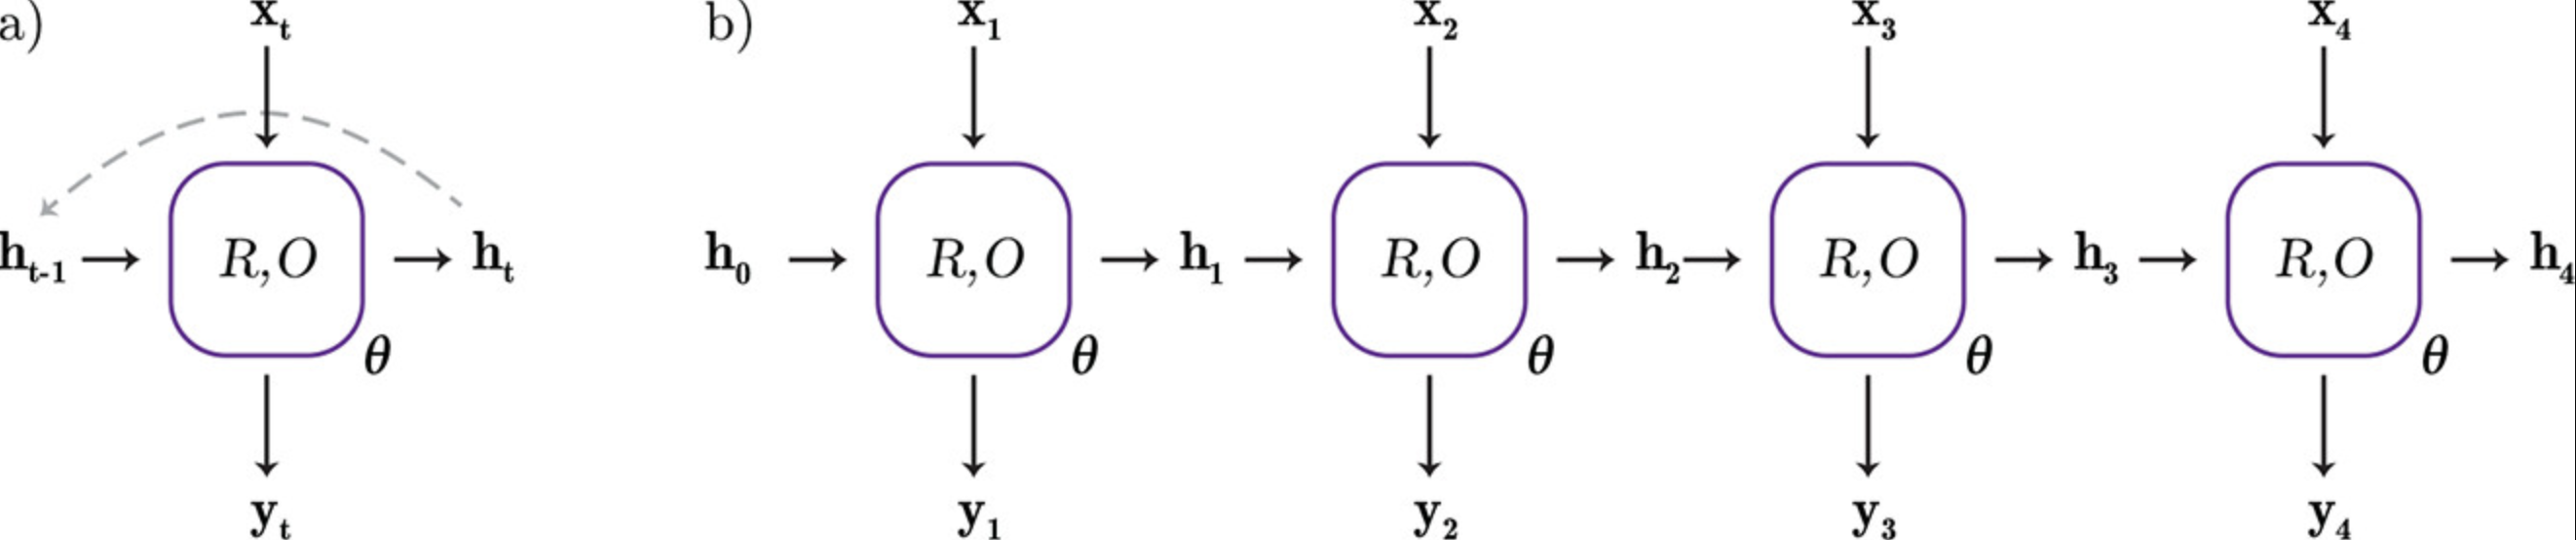

위 그림에서 $x_t$는 t번째 입력 데이터이고, $h_t$는 t번째의 cell에서 나오는 encoded vector, $y_t$는 t번째 cell의 output에 해당한다.

ref: ACS Cent. Sci. 2018, 4, 1, 120–131, https://pubs.acs.org/doi/10.1021/acscentsci.7b00512

Typical RNN structure


<img src="https://miro.medium.com/v2/resize:fit:1246/format:webp/1*AcY9CMkX-AfpVKzm94c2VQ.png">



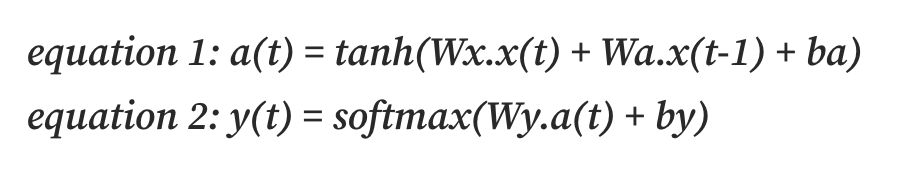

RNN은 다양한 순차 데이터를 다룰 때 사용된다.

현재 사용되는 다양한 chatbot 모델들은 기본적으로 그 전까지 단어, 문자들의 서열을 vector화 시켜 입력으로 받아서 다음 word를 예측하도록 한다.


<img src="https://miro.medium.com/v2/resize:fit:1400/1*phpgEszN4Q6n_Rtd24zpGw.png">

ref: https://miro.medium.com/v2/resize:fit:1400/1*phpgEszN4Q6n_Rtd24zpGw.png

<img src="https://huggingface.co/blog/assets/02_how-to-generate/top_p_sampling.png">

즉, 수학적으로 표현하면 문장 완성은 chain-of-conditional probability라고 할 수 있다.

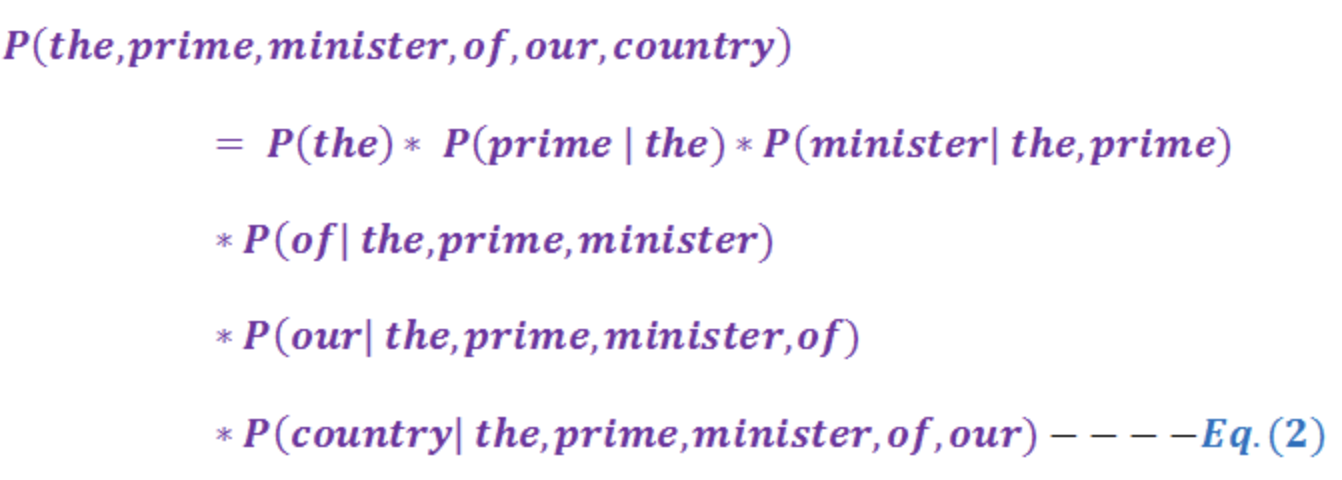

\begin{align}
P(\mathbf{w}) &= P(w_1, w_2, w_3, w_4, \dots , w_n) \\
&=P(w_1)*P(w_2|w_1)*P(w_3|w_1, w_2)*\dots * P(w_n|w_1, w_2, \dots, w_{n-1})\\
&=\prod^n_{i=1} P(w_n|w_1, \dots, w_n)
\end{align}

RNN을 이용하면 다음과 같은 application들이 가능하다.
* one-to-many
* many-to-one
* many-to-many


<img src="https://i.imgur.com/Q8zv6TQ.png">

ref: https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

RNN을 SMILES에 적용하면 다음과 같은 예측을 수행하도록 한다.

RNN에서는 $t$번째 character를 받아서 그 다음 character를 예측하도록 한다.

1. 첫번째 character를 입력으로 받는다.
2. 첫번째 cell에서는 C 뒤에 따라오는 1을 예측한다.
3. 두번째 cell에서는 1과 $h_1$ vector를 입력으로 받아서 그 다음 character인 C를 예측한다.
4. 이를 계속 반복하다가 "\n (end of smiles)"를 만나면 출력을 종료한다.



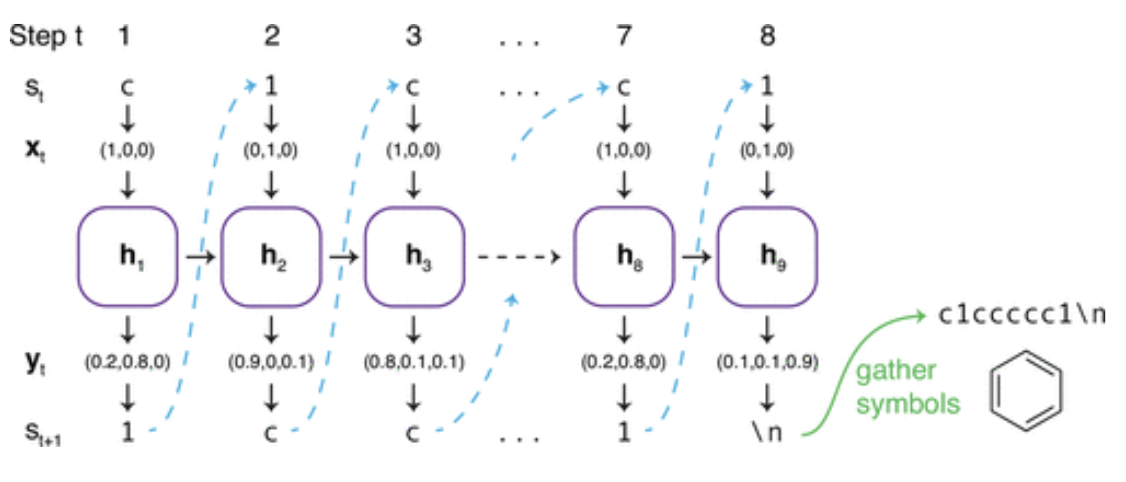

이 때, 각 cell은 모두 동일한 RNN cell이라는 것을 기억하자.


이러한 학습을 통해서 $y_t$ 벡터들은 주어진 입력과 encoded vector(hidden vector)를 기반으로 출력을 예측하도록 한다.

이 때는 일반적으로 multi-class classification이 수행된다.



그리고 $t$번째 cell에서 얻어지는 encoded vector(hidden vector)은 $1$ 번째에서 $t-1$ 번째 까지 입력의 내용을 vector로 표현한 것이다.

다른 말로 얘기하면 $t-1$ 번째까지의 문맥을 벡터로 가지고 있다고 할 수 있다. 따라서 이는 문맥 벡터(context vector)라고도 부른다.


<img src="https://lilianweng.github.io/posts/2018-06-24-attention/encoder-decoder-example.png" width=600>

ref: https://lilianweng.github.io/posts/2018-06-24-attention/encoder-decoder-example.png

Recurrent neural network은 서열 데이터 예측에 매우 성공적이었으나, 긴 서열의 경우, memory를 잃어버리는 문제가 있다.

즉, 문장이 매우 길어지면 앞 쪽에서 나왔던 내용을 기억하는 문제가 있었다.

이를 해결하기 위해서 Long short-term memory(LSTM) 이라는 모델이 1997년 Hochreiter에 의해서 제안되었으며, 그 뒤 조금 더 계산량이 적은 Gated recurrent unit(GRU)라는 모델이 2014년 뉴욕대의 조경현 교수에 의해서 제안되었다.

* LSTM: Sepp Hochreiter; Jürgen Schmidhuber (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780.

* GRU: Cho, Kyunghyun; van Merrienboer, Bart; Gulcehre, Caglar; Bahdanau, Dzmitry; Bougares, Fethi; Schwenk, Holger; Bengio, Yoshua (2014). "Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation". arXiv:1406.1078

<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*QFOzE0TEMFERg3G5_5HiPA.png">

## LSTM을 이용한 docking score 예측
-------
이번 시간에는 LSTM을 이용해서 SMILES의 내용을 학습하고 이를 기반으로 분자의 docking score를 예측하는 모델을 만들어보자.

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 51.4 MB/s eta 0:00:00


In [ ]:
# General Imports
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
#zinc250_file = "https://www.dropbox.com/s/ijojmproum057qp/zinc250k.csv?dl=1"
#zinc250_df = pd.read_csv(zinc250_file, delimiter = ',')

In [ ]:
#MAPK_docking_result = "https://www.dropbox.com/s/1u8au8agn10sg43/vdock_screening.dock.report.tsv?dl=1"
#data = pd.read_csv(MAPK_docking_result, delimiter = '\t')

이번 시간에는 [MAPK1](https://en.wikipedia.org/wiki/MAPK1)에 [ZINC](https://zinc.docking.org/) DB로 부터 무작위로 샘플링한 1000개의 분자를 Autodock을 이용해서 docking 한 결과를 이용한다.

이를 기반으로 SMILES 정보만 가지고 실제 docking 을 수행하지 않고 docking 결과를 예측할 수 있는지 확인해본다.

만일 이것이 가능하다면 매우 큰 분자 라이브러리를 기반으로 단백질과의 상호작용을 훨씬 빠르게 예측할 수 있기 때문이다.

In [ ]:
MAPK_docking_result="https://www.dropbox.com/s/og41qexiujn5gp3/Dock2.report.tsv?dl=1"
data = pd.read_csv(MAPK_docking_result, delimiter = '\t')

In [ ]:
data

UID         TID CMPD_ID  BINDING_E_RANK  BINDING_E_MODEL  BINDING_E  \
0    *****  Ligand_571   *****               1                5     -21.11   
1    *****   Ligand_80   *****               2                8     -11.30   
2    *****  Ligand_971   *****               3               12     -11.16   
3    *****  Ligand_863   *****               4                5     -11.06   
4    *****  Ligand_634   *****               5               40     -10.94   
..     ...         ...     ...             ...              ...        ...   
971  *****  Ligand_253   *****             972               37      -4.45   
972  *****  Ligand_446   *****             973               24      -4.33   
973  *****  Ligand_671   *****             974               41      -4.22   
974  *****  Ligand_117   *****             975               37      -4.18   
975  *****  Ligand_951   *****             976               24      -3.29   

     CLUSTER_E_RANK  CLUSTER_E_MODEL  CLUSTER_E  COLONY_E_MODEL  \
0                 1               43     -21.07              39   
1                 2                8     -11.30               3   
2                13               47     -10.32              16   
3                 3                5     -11.06              49   
4                15                6     -10.25               5   
..              ...              ...        ...             ...   
971             966               39      -4.44              23   
972             969                7      -4.25              46   
973             972               49      -3.72              38   
974             974               14      -3.57              37   
975             976               30      -3.24              30   

                        INCHIKEY  \
0    FXOBIDROVMXPBW-UHFFFAOYSA-N   
1    JTGOPMIRBSJKPT-UHFFFAOYSA-N   
2    LMZWGQLRHOPQAH-UHFFFAOYSA-O   
3    KVWUDSYFKCDNTL-UHFFFAOYSA-N   
4    KLYHWLCBJIWLGU-LJQANCHMSA-N   
..                           ...   
971  PXCQZJSWAAJVCA-UHFFFAOYSA-N   
972  BVTHFOVKIPJRKC-SECBINFHSA-O   
973  JTKNCPCQONNTTO-ZETCQYMHSA-N   
974  JFMJNQREGALOMC-UHFFFAOYSA-N   
975  GESDMGIWABKNBW-UHFFFAOYSA-O   

                                          CANON_SMILES  
0    CC1CC(=O)C2C(O)(C1)CC(O)C13OC1c1c(O)cccc1C(=O)...  
1    Nc1c(C(=O)NC2CCCCC2)nsc1C(=O)N(CC(=O)NC1CCCC1)...  
2    Cn1c(CN2CC[NH+](Cc3ccccc3)CC2)nc2cc(NC(=O)c3cc...  
3    CCN1CCN(S(=O)(=O)c2ccc(NC(=O)c3ccc4c(c3)C(=O)c...  
4    O=C(c1cc(-c2ccc(Cl)cc2)nc2ccccc12)N1CCC[C@@H](...  
..                                                 ...  
971                                   COc1cc(Cl)cnc1Cl  
972                    CC(C)OC(=O)OC[C@@H]1CCC[NH2+]C1  
973        CN(CC(=O)NCC(F)(F)F)C(=O)[C@](C)(N)C(F)(F)F  
974              CCC(CC)N(CCOC)C(=O)Nc1ccc2c(c1)OCCCO2  
975                    CC(=O)N1CCC[N@@H+](CCCSCC#N)CC1  

[976 rows x 12 columns]

In [ ]:
data = data[:10000]

In [ ]:
import sklearn

SMILES를 입력으로 받아서 autodock 결과를 예측하는 목적 값으로 한다.

In [ ]:
#smiles_array = data["smiles"]
smiles_array = data["CANON_SMILES"]
target_prop = data["BINDING_E"]

실제 RNN/LSTM 계산을 수행하기 전에 다음의 처리를 해주어야 한다.

1. 모든 분자들의 SMILES 길이가 모두 다르기 때문에 SMILES string의 길이를 동일하게 만들어 주어야 한다. 이를 위해서 가장 긴 SMILES의 길이를 알아낸다.

2. 길이가 짧은 SMILES는 padding을 수행한다.

2. 각 character를 정수로 mapping한다. 즉, character -> int // int -> character로 mapping 해주는 dictionary를 만들어야 한다. 이를 다른 말로 tokenization이라고 부른다.

3. Start token과 end token을 추가한다.

**Natural language processing에서의 tokenization**

<img src="https://vaclavkosar.com/images/transformer-tokenization-and-embeddings.drawio.svg">

In [ ]:
charset = set("".join(list(smiles_array))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
max_len = max([len(smile) for smile in smiles_array])
embed = max_len+5
print(char_to_int)
print("Character set: ", str(charset))
print(f"Number of all characters: {len(charset)}")
print(f"Length of padded SMILES: {embed}")

{'-': 0, ']': 1, 'C': 2, '@': 3, '/': 4, 'r': 5, 'N': 6, 'P': 7, '2': 8, 'S': 9, 'l': 10, 'F': 11, 'E': 12, 'o': 13, 'H': 14, '1': 15, '4': 16, '3': 17, 'n': 18, '\\': 19, 'B': 20, '(': 21, 's': 22, 'I': 23, '5': 24, 'c': 25, '+': 26, '[': 27, 'O': 28, '!': 29, '=': 30, '#': 31, ')': 32}
Character set:  {'-', ']', 'C', '@', '/', 'r', 'N', 'P', '2', 'S', 'l', 'F', 'E', 'o', 'H', '1', '4', '3', 'n', '\\', 'B', '(', 's', 'I', '5', 'c', '+', '[', 'O', '!', '=', '#', ')'}
Number of all characters: 33
Length of padded SMILES: 90


현재 우리가 가진 SMILES는 33개의 character로 이루어져있고, 최대 90개의 character로 이루어진 string으로 되어 있다.

SMILES의 왼쪽에 padding을 붙인다.

In [ ]:
def add_padding(smi):
  new_smi = 'E'*(embed-1 - len(smi)) + smi + '!'
  return new_smi

In [ ]:
smiles_list = []
for smi in smiles_array:
  padded_smi = add_padding(smi)
  #print(smi)
  smiles_list.append(padded_smi)
print(smiles_list[0])
print(smiles_list[1])

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEECC1CC(=O)C2C(O)(C1)CC(O)C13OC1c1c(O)cccc1C(=O)C23O!
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEENc1c(C(=O)NC2CCCCC2)nsc1C(=O)N(CC(=O)NC1CCCC1)c1ccccc1!


Training set과 test set을 분리한다.

In [ ]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test, y_train, y_test = train_test_split(smiles_list, target_prop, random_state=42, test_size=0.2)
print("No. of training SMILES:", len(smiles_train))
print("No. of test SMILES:    ", len(smiles_test))

No. of training SMILES: 780
No. of test SMILES:     196


각 character를 정수로 mapping하고 이를 다시 one-hot encoding을 수행한다.

In [ ]:
def vectorize(smiles):
  int_vec_list = []
  one_hot =  np.zeros((len(smiles), embed , len(charset)), dtype=np.int8)
  for i,smile in enumerate(smiles):
    #encode SMILES
    int_vec = []
    for j,c in enumerate(smile):
      try:
        one_hot[i,j,char_to_int[c]] = 1
        int_vec.append(char_to_int[c])
      except:
        one_hot[i,j,char_to_int['E']]=1
        int_vec.append(char_to_int['E'])
    int_vec_list.append(int_vec)
  return one_hot, int_vec_list

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEECCCc1ncc(C(=O)N(C)Cc2nnc(C3CC3)n2C)s1!
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 2, 2, 25, 15, 18, 25, 25, 21, 2, 21, 30, 28, 32, 6, 21, 2, 32, 2, 25, 8, 18, 18, 25, 21, 2, 17, 2, 2, 17, 32, 18, 8, 2, 32, 22, 15, 29]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(780, 90, 33)


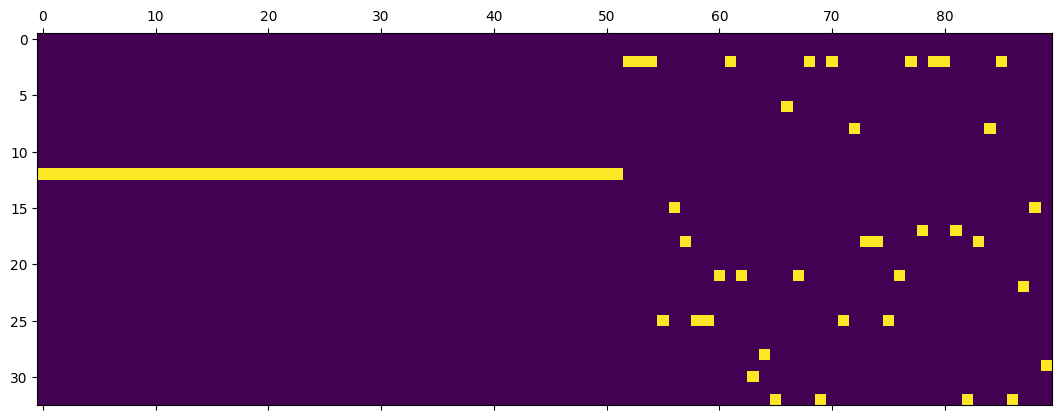

In [ ]:
X_train, X_train_int = vectorize(smiles_train)
X_test, X_test_int = vectorize(smiles_test)
print(smiles_train[0])
print(X_train_int[0])
print(X_train[0])
plt.matshow(X_train[0].T)
print(X_train.shape)

Dataset Class를 정의한다.

In [ ]:
from torch.utils.data import Dataset

class My_dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float)
    self.Y = 1.0*torch.tensor(Y, dtype=torch.float)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx, :,:], self.Y[idx]

In [ ]:
dataset=My_dataset(X_train, np.array(y_train))

In [ ]:
len(X_train)

780

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=8,
                                          shuffle=True, num_workers=1)

In [ ]:
input_shape = X_train.shape[1:]
output_dim = 1
print("input_shape:", input_shape)
print("output_dim:", output_dim)
latent_dim = 64
lstm_dim = 64

input_shape: (90, 33)
output_dim: 1


In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LSTM 기반의 모델
------

LSTM 기반의 neural net을 다음과 같이 정의해보자.

* hyperparameter로는 token의 개수(one-hot encoding의 차원수), hidden size, layer의 개수 등을 지정해주어야 한다.  

* lstm layer의 입력의 차원은 $(N, L, H_{in})$이 된다. (`batch_first=True`라는 옵션 사용시.) $N$은 batch size, $L$은 sequence length, $H_{in}$은 입력 token의 embedding 차원

* lstm layer의 출력은 output vector, hidden vector, cell-state vector가 된다.

* output vector는 **sequence의 길이 만큼** 출력이 된다, 차원: $(N, L, H_{out})$.

* hidden vector(context vector)는 **마지막 cell에서만 출력** 된다, 차원: $(N, H_{out})$.

In [ ]:
class Net(nn.Module):
    def __init__(self, dims, lstm_size, fc_hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]

        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, fc_hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(fc_hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        #out = self.sigmoid(out)
        return out

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

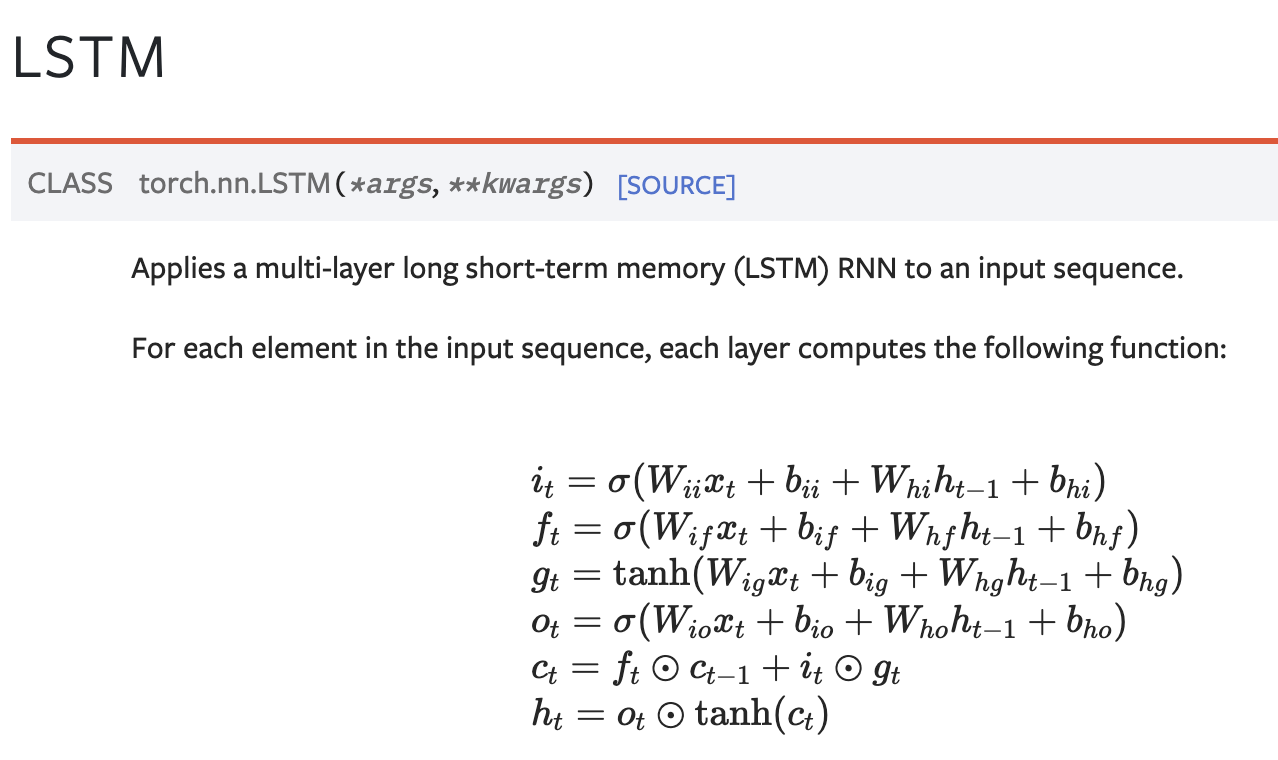

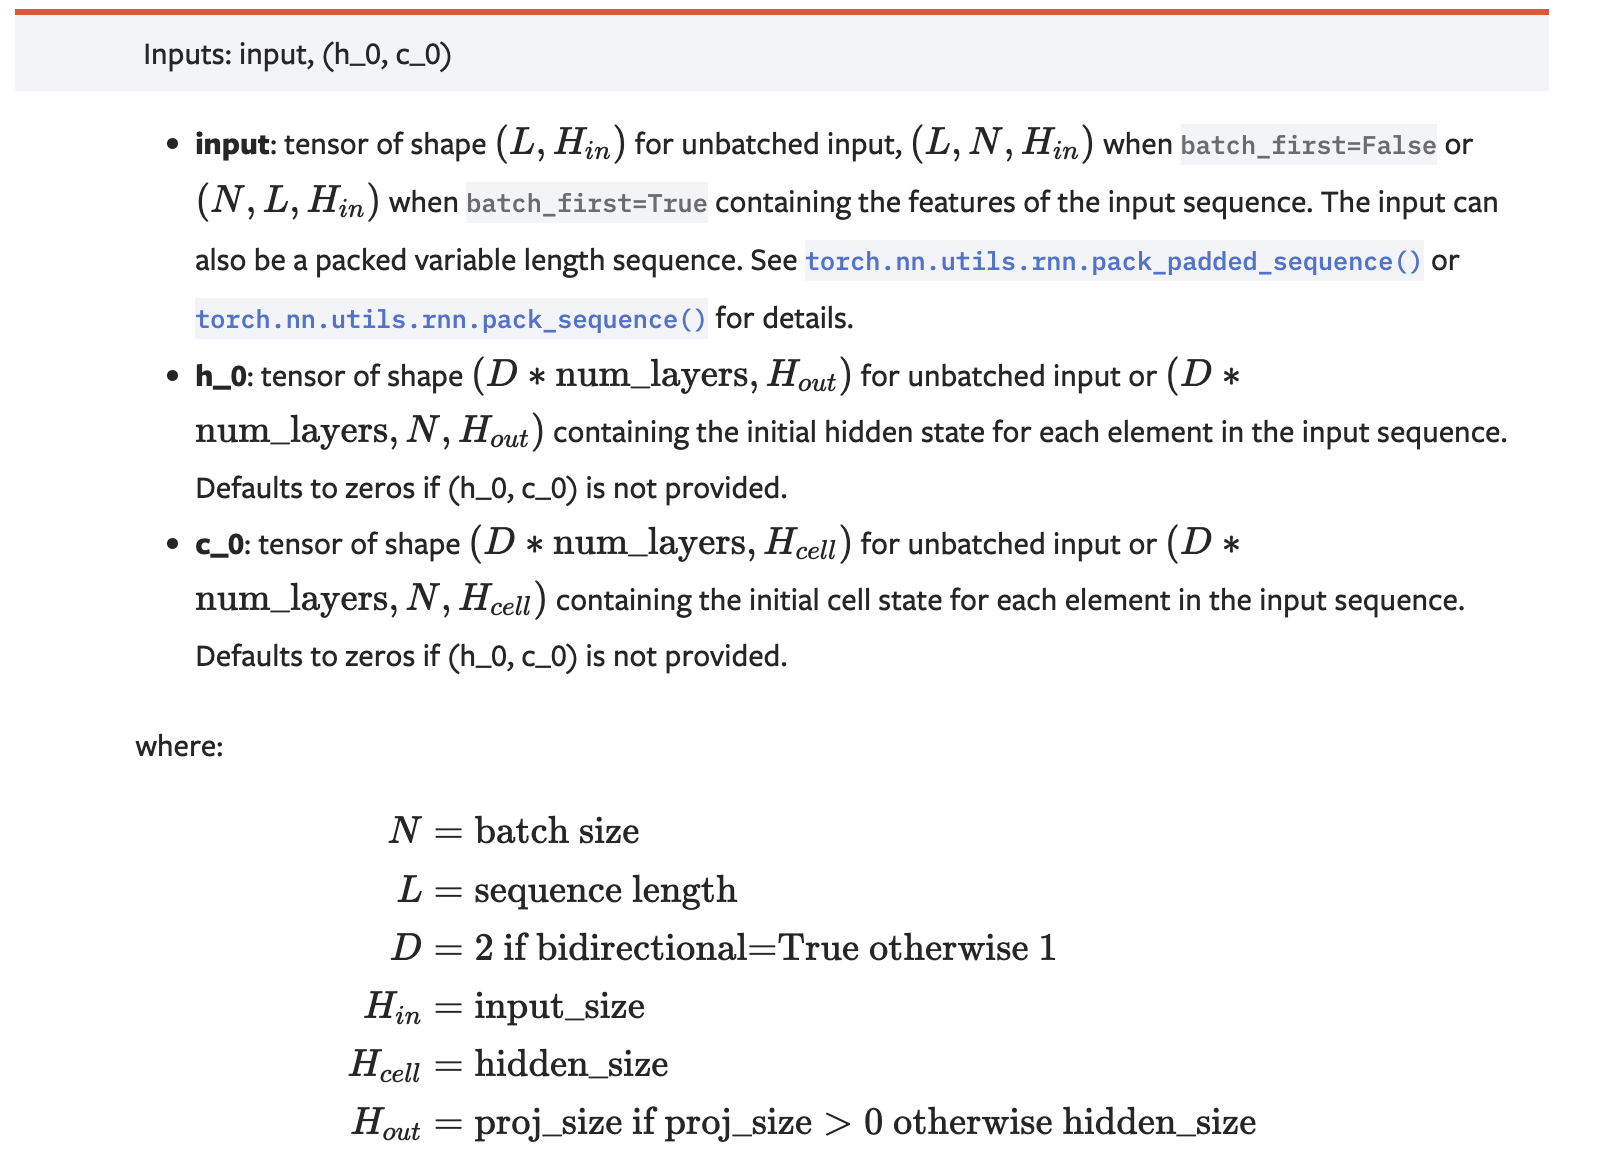

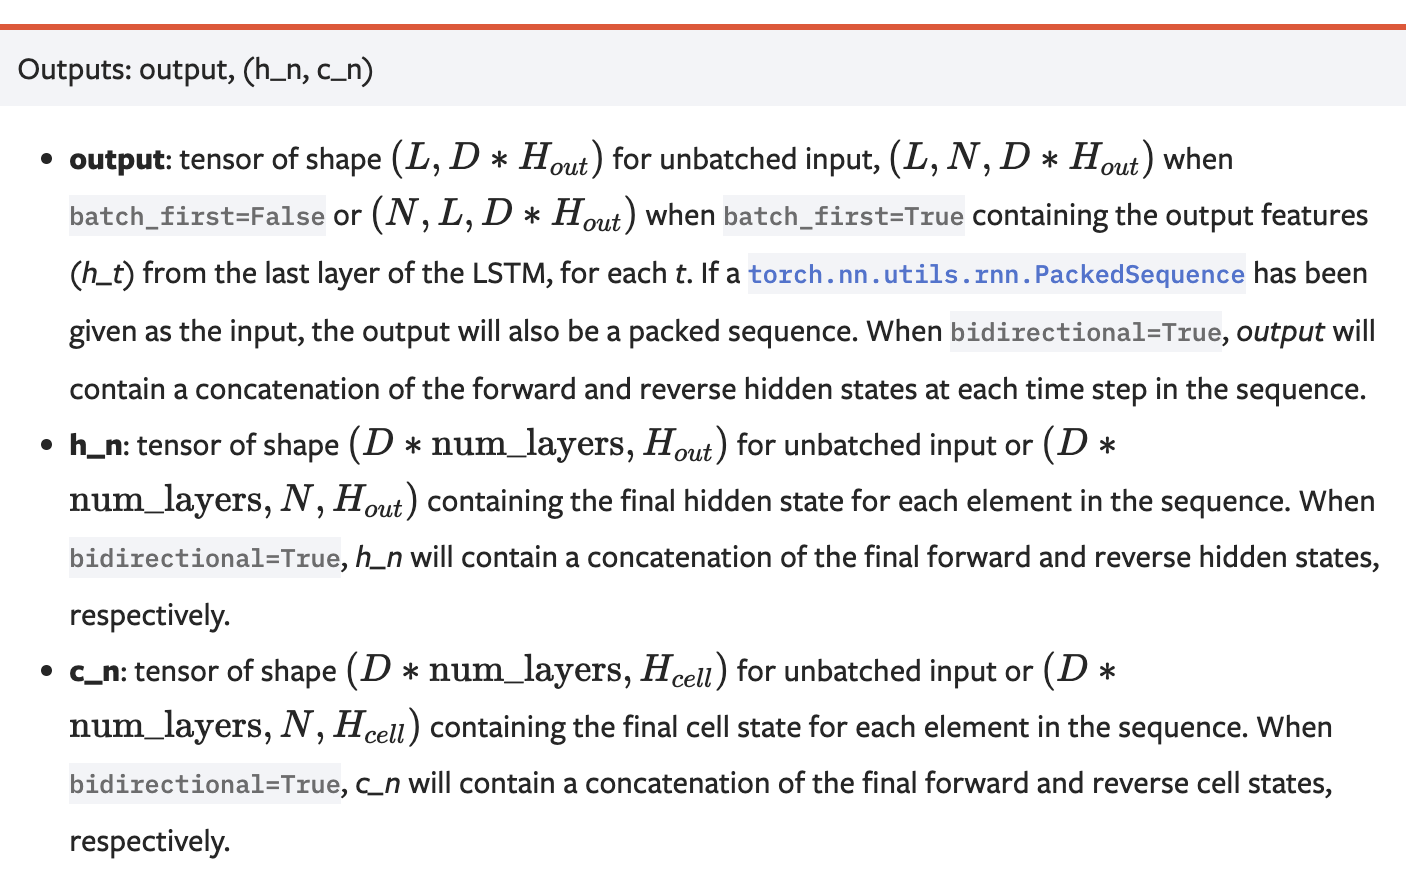

In [ ]:
epochs = 200
dims = input_shape
lstm_size = 64      # The size of the LSTM layer
fc_hidden_size = 128   # The size of the hidden fully-connected layer
dropout_rate = 0.2  # The dropout rate
#output_size = len(charset)    # This is just a single task, so this will be one
output_size = 1
batch_size = 8       # The mini_batch size during training
learning_rate = 0.001  # The initial learning rate for the optimizer

In [ ]:
lstm_model = Net(dims, lstm_size, fc_hidden_size, dropout_rate, output_size)
lstm_model.to(device)

Net(
  (lstm): LSTM(33, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

In [ ]:
print(X_train.shape)
print(X_train[0].shape)

(780, 90, 33)
(90, 33)


In [ ]:
print(device)

cuda


Docking energy를 예측하는 모델이므로 MSELoss를 사용한다.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

#lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
#                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
import sys
for x, y in train_loader:
  x = x.to(device)
  y = y.to(device)
  print(lstm_model(x), y)
  break

tensor([[[-0.0587],
         [-0.0421],
         [-0.0588],
         [-0.0632],
         [-0.0142],
         [-0.0524],
         [-0.0354],
         [-0.0620]]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([-5.6600, -8.7100, -9.1600, -6.3500, -7.1200, -8.7100, -7.6500, -9.3700],
       device='cuda:0')


## LSTM 모델 학습 수행
------

In [ ]:
from tqdm import tqdm
epochs = 200
lstm_model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []

for e in range(epochs):
  running_loss = 0.0

  for input, labels in tqdm(train_loader):
      input = input.to(device)
      labels = labels.to(device)

      # Training pass
      optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass
      #print("input:")
      #print(input.shape)

      output = lstm_model(input) #Forward pass of the mini-batch
      output = output.squeeze(0).squeeze(-1)

      #print("output:")
      #print(output.shape)
      #print("labels:")
      #print(labels.shape)
      loss = criterion(output, labels) #Computing the loss
      loss.backward() # calculate the backward pass
      #print(loss.item())

      torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1)
      optimizer.step() # Optimize the weights

      running_loss += loss.item()
  print(output)
  print(labels)
  print(f"Epoch: {e} Running Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 98/98 [00:01<00:00, 86.91it/s] 


tensor([-7.3186, -7.7081, -6.2650, -6.9143], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7500, -9.4200, -9.8000, -7.5200], device='cuda:0')
Epoch: 0 Running Loss: 16.0919


100%|██████████| 98/98 [00:00<00:00, 224.29it/s]


tensor([-8.0623, -8.0853, -7.9697, -6.6489], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.4600, -9.9800, -6.5300, -6.1000], device='cuda:0')
Epoch: 1 Running Loss: 2.5118


100%|██████████| 98/98 [00:00<00:00, 218.93it/s]


tensor([-6.4004, -7.1400, -8.3144, -7.3220], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.6700, -7.0400, -8.1200, -8.5200], device='cuda:0')
Epoch: 2 Running Loss: 2.2375


100%|██████████| 98/98 [00:00<00:00, 221.73it/s]


tensor([-6.8018, -7.1355, -8.0473, -7.6165], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.6200, -8.6600, -6.1500, -8.6000], device='cuda:0')
Epoch: 3 Running Loss: 2.4056


100%|██████████| 98/98 [00:00<00:00, 225.13it/s]


tensor([-9.7075, -7.7235, -8.6145, -7.2035], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -6.0200,  -7.1800, -10.3200,  -6.8500], device='cuda:0')
Epoch: 4 Running Loss: 2.3330


100%|██████████| 98/98 [00:00<00:00, 229.41it/s]


tensor([-7.7987, -7.2343, -8.2796, -6.6732], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8400, -6.1700, -6.5400, -8.2500], device='cuda:0')
Epoch: 5 Running Loss: 2.0455


100%|██████████| 98/98 [00:00<00:00, 228.36it/s]


tensor([-8.1008, -6.9977, -8.3606, -7.4393], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8800, -8.3600, -6.6200, -9.7300], device='cuda:0')
Epoch: 6 Running Loss: 2.2541


100%|██████████| 98/98 [00:00<00:00, 229.61it/s]


tensor([-6.7017, -7.6274, -6.4619, -6.9907], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7600, -6.4900, -8.1500, -7.9900], device='cuda:0')
Epoch: 7 Running Loss: 2.2153


100%|██████████| 98/98 [00:00<00:00, 224.86it/s]


tensor([-7.1661, -8.5934, -8.4629, -7.8192], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5000, -8.0000, -7.7200, -7.8800], device='cuda:0')
Epoch: 8 Running Loss: 2.2417


100%|██████████| 98/98 [00:00<00:00, 213.84it/s]


tensor([-8.8213, -9.2940, -7.7094, -7.9929], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7500, -6.7300, -7.8700, -8.8900], device='cuda:0')
Epoch: 9 Running Loss: 2.1799


100%|██████████| 98/98 [00:00<00:00, 219.56it/s]


tensor([-7.1280, -7.1288, -6.9290, -6.3645], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.3600, -7.3900, -8.1000, -7.5900], device='cuda:0')
Epoch: 10 Running Loss: 2.2157


100%|██████████| 98/98 [00:00<00:00, 188.76it/s]


tensor([-7.8264, -8.3587, -6.5939, -7.7993], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4300, -6.8500, -7.2300, -5.0000], device='cuda:0')
Epoch: 11 Running Loss: 1.9750


100%|██████████| 98/98 [00:00<00:00, 180.37it/s]


tensor([-7.4217, -6.6234, -6.8736, -7.5617], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.7300, -7.6000, -6.4400, -7.8700], device='cuda:0')
Epoch: 12 Running Loss: 2.2315


100%|██████████| 98/98 [00:00<00:00, 198.69it/s]


tensor([-6.9614, -6.8601, -7.5840, -7.6288], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4500, -9.1900, -7.3400, -7.9600], device='cuda:0')
Epoch: 13 Running Loss: 2.2752


100%|██████████| 98/98 [00:00<00:00, 209.18it/s]


tensor([-6.9613, -7.0190, -6.9267, -7.0476], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.7300, -7.4800, -8.3800, -7.4400], device='cuda:0')
Epoch: 14 Running Loss: 2.0715


100%|██████████| 98/98 [00:00<00:00, 226.17it/s]


tensor([-7.0377, -7.7220, -7.9139, -7.1962], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.0700, -8.5200, -7.8900, -8.5500], device='cuda:0')
Epoch: 15 Running Loss: 2.0479


100%|██████████| 98/98 [00:00<00:00, 222.20it/s]


tensor([-7.9711, -8.7539, -7.4710, -7.2962], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5200, -7.6000, -8.5800, -8.5000], device='cuda:0')
Epoch: 16 Running Loss: 2.1220


100%|██████████| 98/98 [00:00<00:00, 226.60it/s]


tensor([-7.8283, -7.5703, -7.5115, -7.9078], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.6200, -8.5300, -6.6000, -9.9300], device='cuda:0')
Epoch: 17 Running Loss: 2.3105


100%|██████████| 98/98 [00:00<00:00, 221.49it/s]


tensor([-7.3972, -7.3092, -7.6363, -6.5567], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4600, -7.8400, -8.1800, -8.9800], device='cuda:0')
Epoch: 18 Running Loss: 2.0999


100%|██████████| 98/98 [00:00<00:00, 220.01it/s]


tensor([-7.9194, -8.3678, -9.4146, -7.0490], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.7700, -7.8100, -8.1500, -8.2300], device='cuda:0')
Epoch: 19 Running Loss: 2.1515


100%|██████████| 98/98 [00:00<00:00, 223.60it/s]


tensor([-8.1534, -8.1132, -8.2559, -8.4914], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1600, -5.9900, -8.1700, -7.5300], device='cuda:0')
Epoch: 20 Running Loss: 2.0810


100%|██████████| 98/98 [00:00<00:00, 226.50it/s]


tensor([-7.9060, -7.8844, -6.7488, -8.1416], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8400, -7.6500, -8.0700, -8.9300], device='cuda:0')
Epoch: 21 Running Loss: 1.6634


100%|██████████| 98/98 [00:00<00:00, 228.40it/s]


tensor([-7.0127, -7.1775, -7.7967, -6.7529], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -9.2000,  -7.4400, -10.3500,  -6.8900], device='cuda:0')
Epoch: 22 Running Loss: 1.5513


100%|██████████| 98/98 [00:00<00:00, 222.37it/s]


tensor([-7.4200, -8.1182, -9.4165, -5.5593], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1000, -9.0300, -8.6300, -7.1400], device='cuda:0')
Epoch: 23 Running Loss: 1.3846


100%|██████████| 98/98 [00:00<00:00, 218.46it/s]


tensor([-7.3994, -8.3841, -8.2277, -8.5099], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9400, -8.0000, -8.1600, -9.1400], device='cuda:0')
Epoch: 24 Running Loss: 1.3864


100%|██████████| 98/98 [00:00<00:00, 218.73it/s]


tensor([ -9.1459, -10.1308,  -9.3715,  -8.1033], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5600, -9.4200, -7.6300, -7.9900], device='cuda:0')
Epoch: 25 Running Loss: 1.3088


100%|██████████| 98/98 [00:00<00:00, 216.71it/s]


tensor([-7.3357, -9.5179, -8.4807, -7.2647], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.1800, -10.6300,  -7.6500,  -7.4400], device='cuda:0')
Epoch: 26 Running Loss: 1.1441


100%|██████████| 98/98 [00:00<00:00, 218.95it/s]


tensor([-8.8738, -8.6195, -7.4242, -7.4713], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7300, -5.9900, -6.9800, -7.8700], device='cuda:0')
Epoch: 27 Running Loss: 1.3589


100%|██████████| 98/98 [00:00<00:00, 228.28it/s]


tensor([-7.0462, -7.2000, -6.9064, -9.3433], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1500, -5.8400, -8.0000, -8.2500], device='cuda:0')
Epoch: 28 Running Loss: 1.1383


100%|██████████| 98/98 [00:00<00:00, 231.49it/s]


tensor([-6.0322, -6.5199, -6.2199, -7.7597], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.4600, -6.0200, -5.3100, -8.5200], device='cuda:0')
Epoch: 29 Running Loss: 1.1133


100%|██████████| 98/98 [00:00<00:00, 220.87it/s]


tensor([-7.8567, -6.8919, -6.8515, -7.5635], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7400, -7.5400, -6.4600, -7.0800], device='cuda:0')
Epoch: 30 Running Loss: 1.2104


100%|██████████| 98/98 [00:00<00:00, 224.90it/s]


tensor([-7.1724, -8.7447, -7.9582, -7.1670], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.7700, -8.5200, -7.8100, -6.6300], device='cuda:0')
Epoch: 31 Running Loss: 1.2101


100%|██████████| 98/98 [00:00<00:00, 220.00it/s]


tensor([-8.5989, -6.5665, -6.7840, -6.3504], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.0400, -7.8400, -6.9100, -6.7100], device='cuda:0')
Epoch: 32 Running Loss: 1.0736


100%|██████████| 98/98 [00:00<00:00, 227.40it/s]


tensor([-8.1203, -7.1485, -7.9201, -8.3553], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4900, -7.0600, -8.8000, -8.3700], device='cuda:0')
Epoch: 33 Running Loss: 1.0790


100%|██████████| 98/98 [00:00<00:00, 226.42it/s]


tensor([-7.1152, -9.1674, -7.6861, -7.1211], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.0800, -8.8900, -8.7300, -8.1600], device='cuda:0')
Epoch: 34 Running Loss: 0.9384


100%|██████████| 98/98 [00:00<00:00, 230.58it/s]


tensor([-7.5110, -6.4694, -8.3409, -7.4312], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.6900, -8.0300, -7.3500, -5.9600], device='cuda:0')
Epoch: 35 Running Loss: 1.0036


100%|██████████| 98/98 [00:00<00:00, 225.71it/s]


tensor([-6.9083, -8.0140, -7.4491, -8.0651], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.6900, -9.3600, -8.1500, -5.5600], device='cuda:0')
Epoch: 36 Running Loss: 1.1100


100%|██████████| 98/98 [00:00<00:00, 210.07it/s]


tensor([-6.5544, -7.8330, -7.7756, -7.4253], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7700, -8.2100, -7.9400, -6.6400], device='cuda:0')
Epoch: 37 Running Loss: 0.8954


100%|██████████| 98/98 [00:00<00:00, 197.81it/s]


tensor([-7.5557, -7.9069, -8.6216, -7.2298], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.9000, -7.4300, -8.1900, -6.9100], device='cuda:0')
Epoch: 38 Running Loss: 0.9916


100%|██████████| 98/98 [00:00<00:00, 204.04it/s]


tensor([-6.4238, -7.9857, -7.9310, -5.7926], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.6900, -7.6500, -9.0400, -7.2600], device='cuda:0')
Epoch: 39 Running Loss: 0.9696


100%|██████████| 98/98 [00:00<00:00, 212.80it/s]


tensor([ -7.2635,  -7.5595, -10.0039,  -7.9866], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -7.0500,  -7.6900, -11.1600,  -7.8200], device='cuda:0')
Epoch: 40 Running Loss: 0.8949


100%|██████████| 98/98 [00:00<00:00, 217.43it/s]


tensor([-7.3670, -6.6564, -8.4536, -6.5210], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.0500, -7.1300, -6.3800, -8.1200], device='cuda:0')
Epoch: 41 Running Loss: 0.9451


100%|██████████| 98/98 [00:00<00:00, 225.81it/s]


tensor([-6.7487, -9.0831, -6.9029, -6.1222], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1900, -9.7700, -7.2800, -6.1500], device='cuda:0')
Epoch: 42 Running Loss: 0.9827


100%|██████████| 98/98 [00:00<00:00, 224.22it/s]


tensor([ -8.6300,  -6.3297,  -6.4809, -12.2555], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.2100,  -7.0500,  -4.9100, -10.4900], device='cuda:0')
Epoch: 43 Running Loss: 0.9952


100%|██████████| 98/98 [00:00<00:00, 222.07it/s]


tensor([-7.5307, -9.6517, -7.9180, -6.5867], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.2500, -9.0200, -7.2200, -6.9900], device='cuda:0')
Epoch: 44 Running Loss: 0.9103


100%|██████████| 98/98 [00:00<00:00, 227.49it/s]


tensor([-6.4387, -7.4601, -8.6334, -7.6210], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.8200, -9.3700, -9.6000, -7.8200], device='cuda:0')
Epoch: 45 Running Loss: 1.0290


100%|██████████| 98/98 [00:00<00:00, 227.81it/s]


tensor([-7.4050, -5.3963, -8.8252, -6.6976], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.3600,  -4.7700, -10.3700,  -6.4200], device='cuda:0')
Epoch: 46 Running Loss: 0.9197


100%|██████████| 98/98 [00:00<00:00, 227.00it/s]


tensor([-8.9136, -8.5045, -7.3016, -8.7142], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.3700, -7.6300, -8.5200, -9.9300], device='cuda:0')
Epoch: 47 Running Loss: 0.9101


100%|██████████| 98/98 [00:00<00:00, 224.49it/s]


tensor([-7.1630, -7.6793, -9.4433, -9.0581], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5600, -5.5600, -9.3700, -8.4900], device='cuda:0')
Epoch: 48 Running Loss: 0.9666


100%|██████████| 98/98 [00:00<00:00, 232.18it/s]


tensor([-8.7668, -8.0360, -8.9020, -6.4349], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-21.1100,  -6.1000,  -8.1100,  -5.6600], device='cuda:0')
Epoch: 49 Running Loss: 1.0939


100%|██████████| 98/98 [00:00<00:00, 227.27it/s]


tensor([-7.7884, -6.3700, -8.3655, -7.7292], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.8800, -5.8400, -9.6900, -8.4200], device='cuda:0')
Epoch: 50 Running Loss: 0.8781


100%|██████████| 98/98 [00:00<00:00, 229.21it/s]


tensor([-6.0442, -7.4658, -6.2989, -6.6300], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.8500, -8.2100, -5.7200, -7.8000], device='cuda:0')
Epoch: 51 Running Loss: 0.9263


100%|██████████| 98/98 [00:00<00:00, 228.70it/s]


tensor([-5.8228, -6.8888, -8.5211, -7.4390], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5000, -6.2800, -8.5000, -6.9300], device='cuda:0')
Epoch: 52 Running Loss: 0.8851


100%|██████████| 98/98 [00:00<00:00, 225.04it/s]


tensor([-8.9439, -7.1390, -8.2420, -6.3060], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.8300, -7.4100, -7.1500, -5.9500], device='cuda:0')
Epoch: 53 Running Loss: 0.9017


100%|██████████| 98/98 [00:00<00:00, 232.66it/s]


tensor([-7.1930, -8.3509, -7.0065, -8.0696], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5100, -6.6200, -8.1200, -8.4700], device='cuda:0')
Epoch: 54 Running Loss: 0.8344


100%|██████████| 98/98 [00:00<00:00, 227.62it/s]


tensor([-9.1226, -8.1523, -8.6151, -7.3715], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.9200,  -7.2800,  -9.2200,  -7.0500], device='cuda:0')
Epoch: 55 Running Loss: 0.8571


100%|██████████| 98/98 [00:00<00:00, 232.30it/s]


tensor([-7.5775, -9.4015, -8.6585, -7.7879], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.3300, -9.1400, -8.2400, -6.3300], device='cuda:0')
Epoch: 56 Running Loss: 0.8498


100%|██████████| 98/98 [00:00<00:00, 220.21it/s]


tensor([-7.6976, -6.9206, -5.8847, -7.1159], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.8600, -7.8400, -6.1500, -6.9900], device='cuda:0')
Epoch: 57 Running Loss: 0.8239


100%|██████████| 98/98 [00:00<00:00, 223.96it/s]


tensor([-7.1853, -8.4346, -8.9526, -5.7804], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9900, -8.9700, -9.7100, -6.5700], device='cuda:0')
Epoch: 58 Running Loss: 0.8129


100%|██████████| 98/98 [00:00<00:00, 223.31it/s]


tensor([-6.4671, -8.0933, -6.6297, -9.1434], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.7100, -8.2100, -6.9000, -7.8200], device='cuda:0')
Epoch: 59 Running Loss: 0.8616


100%|██████████| 98/98 [00:00<00:00, 229.09it/s]


tensor([-6.1298, -5.6133, -6.2571, -9.9708], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.5600, -5.6000, -5.7200, -8.8000], device='cuda:0')
Epoch: 60 Running Loss: 0.8003


100%|██████████| 98/98 [00:00<00:00, 219.41it/s]


tensor([-7.4939, -7.2900, -7.4548, -8.2366], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.4200, -7.8400, -7.5100, -8.0900], device='cuda:0')
Epoch: 61 Running Loss: 0.9051


100%|██████████| 98/98 [00:00<00:00, 221.18it/s]


tensor([-5.9556, -7.5616, -7.5992, -8.0520], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.2900, -7.4500, -7.9700, -8.1900], device='cuda:0')
Epoch: 62 Running Loss: 0.8404


100%|██████████| 98/98 [00:00<00:00, 214.83it/s]


tensor([-7.0779, -8.2827, -9.7090, -7.3341], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8400, -8.9400, -8.5500, -7.8100], device='cuda:0')
Epoch: 63 Running Loss: 0.8543


100%|██████████| 98/98 [00:00<00:00, 206.14it/s]


tensor([-9.0486, -8.2914, -7.6377, -8.6379], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.6700, -8.3000, -7.3300, -7.8900], device='cuda:0')
Epoch: 64 Running Loss: 0.8293


100%|██████████| 98/98 [00:00<00:00, 195.92it/s]


tensor([-8.1240, -9.7560, -7.2608, -9.2871], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9000, -9.8900, -7.3500, -8.9500], device='cuda:0')
Epoch: 65 Running Loss: 0.7833


100%|██████████| 98/98 [00:00<00:00, 212.64it/s]


tensor([-8.6428, -7.3154, -7.1481, -8.7679], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.2400, -8.6700, -4.8300, -8.3700], device='cuda:0')
Epoch: 66 Running Loss: 0.8273


100%|██████████| 98/98 [00:00<00:00, 231.05it/s]


tensor([-6.5852, -8.9546, -8.0093, -8.9191], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.2000, -8.7800, -7.7700, -9.0100], device='cuda:0')
Epoch: 67 Running Loss: 0.7557


100%|██████████| 98/98 [00:00<00:00, 226.58it/s]


tensor([-9.8383, -5.5242, -7.8883, -7.5533], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.4500, -5.9200, -8.0100, -7.6500], device='cuda:0')
Epoch: 68 Running Loss: 0.7702


100%|██████████| 98/98 [00:00<00:00, 227.18it/s]


tensor([-8.4793, -7.4484, -8.9002, -9.0735], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4300, -7.1400, -5.5100, -9.0200], device='cuda:0')
Epoch: 69 Running Loss: 0.8138


100%|██████████| 98/98 [00:00<00:00, 234.14it/s]


tensor([-7.5442, -8.8183, -8.8004, -7.4086], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.6500, -9.9300, -9.2300, -7.7500], device='cuda:0')
Epoch: 70 Running Loss: 0.8364


100%|██████████| 98/98 [00:00<00:00, 214.87it/s]


tensor([-8.1973, -6.1357, -5.9084, -7.6609], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5100, -6.4000, -6.9200, -6.9900], device='cuda:0')
Epoch: 71 Running Loss: 0.8158


100%|██████████| 98/98 [00:00<00:00, 219.87it/s]


tensor([-8.5775, -7.5283, -8.2436, -7.2960], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.2600, -7.7400, -7.6500, -7.6800], device='cuda:0')
Epoch: 72 Running Loss: 0.7069


100%|██████████| 98/98 [00:00<00:00, 221.01it/s]


tensor([-8.2456, -7.7459, -7.6124, -7.2178], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5000, -7.5600, -6.9800, -7.7300], device='cuda:0')
Epoch: 73 Running Loss: 0.8136


100%|██████████| 98/98 [00:00<00:00, 226.81it/s]


tensor([-7.7291, -7.1955, -7.1025, -5.1842], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7700, -7.6200, -5.8500, -4.3300], device='cuda:0')
Epoch: 74 Running Loss: 0.8032


100%|██████████| 98/98 [00:00<00:00, 222.33it/s]


tensor([-7.3088, -8.4388, -6.4081, -7.7891], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.4500, -8.1200, -6.0200, -6.8500], device='cuda:0')
Epoch: 75 Running Loss: 0.7312


100%|██████████| 98/98 [00:00<00:00, 221.17it/s]


tensor([-9.2248, -9.1401, -8.9563, -7.3321], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9800, -6.8300, -8.5700, -7.3300], device='cuda:0')
Epoch: 76 Running Loss: 0.8098


100%|██████████| 98/98 [00:00<00:00, 226.87it/s]


tensor([-8.4432, -7.5768, -7.1219, -8.1341], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.6500, -7.8100, -8.1500, -7.3000], device='cuda:0')
Epoch: 77 Running Loss: 0.7979


100%|██████████| 98/98 [00:00<00:00, 217.38it/s]


tensor([-7.5630, -8.1934, -9.0278, -6.7575], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4900, -8.4900, -9.7700, -6.6200], device='cuda:0')
Epoch: 78 Running Loss: 0.7359


100%|██████████| 98/98 [00:00<00:00, 226.73it/s]


tensor([-8.0251, -6.9951, -5.2415, -9.0036], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.0100,  -6.7500,  -5.7900, -10.3500], device='cuda:0')
Epoch: 79 Running Loss: 0.6959


100%|██████████| 98/98 [00:00<00:00, 221.55it/s]


tensor([ -8.3478, -10.0987,  -6.7475,  -7.6816], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5000, -9.6000, -7.3300, -7.3300], device='cuda:0')
Epoch: 80 Running Loss: 0.7449


100%|██████████| 98/98 [00:00<00:00, 223.74it/s]


tensor([-8.6096, -6.3157, -7.4510, -8.1548], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7300, -6.9000, -7.4400, -7.6200], device='cuda:0')
Epoch: 81 Running Loss: 0.8164


100%|██████████| 98/98 [00:00<00:00, 226.27it/s]


tensor([-7.3155, -8.5274, -7.7046, -6.9106], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8800, -6.3800, -8.4100, -6.3900], device='cuda:0')
Epoch: 82 Running Loss: 0.7493


100%|██████████| 98/98 [00:00<00:00, 232.14it/s]


tensor([-8.3451, -8.7301, -6.9138, -7.1050], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5800, -8.5700, -6.9600, -7.2200], device='cuda:0')
Epoch: 83 Running Loss: 0.6852


100%|██████████| 98/98 [00:00<00:00, 232.56it/s]


tensor([-7.8099, -5.8079, -5.7208, -9.4683], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -9.2100,  -6.4100,  -5.7200, -10.5800], device='cuda:0')
Epoch: 84 Running Loss: 0.7277


100%|██████████| 98/98 [00:00<00:00, 226.00it/s]


tensor([-9.2693, -7.7664, -7.4912, -7.6109], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.0200, -7.9900, -8.2000, -7.8400], device='cuda:0')
Epoch: 85 Running Loss: 0.6961


100%|██████████| 98/98 [00:00<00:00, 222.94it/s]


tensor([-6.2677, -5.8690, -7.4026, -5.5865], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.6200, -6.7300, -7.3900, -5.4800], device='cuda:0')
Epoch: 86 Running Loss: 0.7136


100%|██████████| 98/98 [00:00<00:00, 200.23it/s]


tensor([-8.7991, -6.5922, -7.3872, -8.3742], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1700, -6.4100, -7.6500, -8.4000], device='cuda:0')
Epoch: 87 Running Loss: 0.7253


100%|██████████| 98/98 [00:00<00:00, 213.36it/s]


tensor([-9.7381, -7.9264, -8.3819, -6.9503], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.8300, -7.4800, -8.5200, -6.3900], device='cuda:0')
Epoch: 88 Running Loss: 0.7580


100%|██████████| 98/98 [00:00<00:00, 191.01it/s]


tensor([-7.2299, -5.4728, -6.7827, -8.1279], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4500, -5.1900, -6.9800, -7.4800], device='cuda:0')
Epoch: 89 Running Loss: 0.7611


100%|██████████| 98/98 [00:00<00:00, 214.99it/s]


tensor([-7.1025, -8.8219, -6.8866, -7.2406], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.9400, -8.8300, -7.2100, -8.2400], device='cuda:0')
Epoch: 90 Running Loss: 0.6792


100%|██████████| 98/98 [00:00<00:00, 193.02it/s]


tensor([ -7.9713, -10.3542,  -7.7371,  -6.6429], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -7.8800, -10.3700,  -7.8100,  -6.8800], device='cuda:0')
Epoch: 91 Running Loss: 0.7216


100%|██████████| 98/98 [00:00<00:00, 198.44it/s]


tensor([ -7.7107, -11.0238, -10.0365,  -7.0010], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.5900, -10.1900,  -9.9600,  -6.6200], device='cuda:0')
Epoch: 92 Running Loss: 0.7303


100%|██████████| 98/98 [00:00<00:00, 223.17it/s]


tensor([-5.7087, -8.0658, -7.6283, -7.5167], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.6000, -7.6200, -7.8400, -6.6600], device='cuda:0')
Epoch: 93 Running Loss: 0.6822


100%|██████████| 98/98 [00:00<00:00, 224.83it/s]


tensor([-10.4647,  -4.2892,  -7.0482,  -6.6884], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.8200, -4.9000, -7.5400, -6.5600], device='cuda:0')
Epoch: 94 Running Loss: 0.7245


100%|██████████| 98/98 [00:00<00:00, 221.33it/s]


tensor([-7.2555, -7.1572, -7.6159, -6.7532], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.3300, -8.2700, -9.1300, -7.0900], device='cuda:0')
Epoch: 95 Running Loss: 0.6832


100%|██████████| 98/98 [00:00<00:00, 227.98it/s]


tensor([-8.4822, -7.1238, -8.4652, -6.8274], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1000, -7.8400, -8.9700, -6.8400], device='cuda:0')
Epoch: 96 Running Loss: 0.7483


100%|██████████| 98/98 [00:00<00:00, 225.10it/s]


tensor([-7.2283, -8.9812, -9.9013, -8.5905], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -7.8200,  -8.8200, -10.1600,  -9.0100], device='cuda:0')
Epoch: 97 Running Loss: 0.7045


100%|██████████| 98/98 [00:00<00:00, 215.53it/s]


tensor([-8.0990, -8.6573, -8.6304, -7.9940], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.6200, -8.8100, -8.6800, -7.7700], device='cuda:0')
Epoch: 98 Running Loss: 0.7258


100%|██████████| 98/98 [00:00<00:00, 218.08it/s]


tensor([-7.2384, -9.1626, -8.1076, -8.2092], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.3300, -9.0200, -5.9900, -8.4000], device='cuda:0')
Epoch: 99 Running Loss: 0.6857


100%|██████████| 98/98 [00:00<00:00, 224.54it/s]


tensor([-8.8501, -7.4680, -8.8190, -7.4426], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5900, -5.8100, -9.0400, -8.5500], device='cuda:0')
Epoch: 100 Running Loss: 0.6406


100%|██████████| 98/98 [00:00<00:00, 228.54it/s]


tensor([-9.6072, -7.6553, -6.8623, -9.6707], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.9600, -8.3800, -5.5700, -9.4200], device='cuda:0')
Epoch: 101 Running Loss: 0.6875


100%|██████████| 98/98 [00:00<00:00, 220.18it/s]


tensor([-6.3923, -7.2583, -6.4298, -8.4224], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.2400, -5.5700, -6.8400, -9.4100], device='cuda:0')
Epoch: 102 Running Loss: 0.6603


100%|██████████| 98/98 [00:00<00:00, 216.19it/s]


tensor([-8.0009, -8.6096, -8.6658, -6.0896], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5600, -8.0200, -9.1400, -6.6000], device='cuda:0')
Epoch: 103 Running Loss: 0.6936


100%|██████████| 98/98 [00:00<00:00, 219.65it/s]


tensor([-7.1212, -8.1293, -7.8082, -7.9865], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.9100, -7.3800, -9.2000, -7.9600], device='cuda:0')
Epoch: 104 Running Loss: 0.7050


100%|██████████| 98/98 [00:00<00:00, 220.81it/s]


tensor([-6.9280, -9.3083, -9.5339, -6.7332], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -6.6000,  -8.5000, -10.0300,  -6.4100], device='cuda:0')
Epoch: 105 Running Loss: 0.6658


100%|██████████| 98/98 [00:00<00:00, 217.55it/s]


tensor([-5.2178, -6.9141, -8.1231, -6.5824], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-4.9100, -7.5200, -8.4800, -5.9800], device='cuda:0')
Epoch: 106 Running Loss: 0.6605


100%|██████████| 98/98 [00:00<00:00, 213.97it/s]


tensor([-5.9147, -7.2260, -8.6206, -7.4813], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.4900, -7.9600, -8.1900, -7.4400], device='cuda:0')
Epoch: 107 Running Loss: 0.7226


100%|██████████| 98/98 [00:00<00:00, 219.67it/s]


tensor([-7.4009, -6.2928, -9.4037, -7.9583], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -6.9300,  -7.4000, -10.5200,  -8.1500], device='cuda:0')
Epoch: 108 Running Loss: 0.6409


100%|██████████| 98/98 [00:00<00:00, 215.29it/s]


tensor([-7.3000, -4.7983, -9.2089, -8.8398], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5100, -5.4600, -8.9600, -9.0800], device='cuda:0')
Epoch: 109 Running Loss: 0.6732


100%|██████████| 98/98 [00:00<00:00, 215.04it/s]


tensor([-8.0906, -6.3546, -8.0776, -9.1214], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5800, -6.2100, -8.7000, -7.0800], device='cuda:0')
Epoch: 110 Running Loss: 0.6581


100%|██████████| 98/98 [00:00<00:00, 221.37it/s]


tensor([-10.3602,  -6.4940,  -9.1746,  -8.5620], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-11.3000,  -6.4600,  -8.0700,  -7.8400], device='cuda:0')
Epoch: 111 Running Loss: 0.6510


100%|██████████| 98/98 [00:00<00:00, 226.80it/s]


tensor([-7.4278, -7.8633, -8.7262, -7.2759], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.2200, -7.2800, -9.6300, -5.5700], device='cuda:0')
Epoch: 112 Running Loss: 0.6946


100%|██████████| 98/98 [00:00<00:00, 222.59it/s]


tensor([-9.2213, -7.6782, -6.7984, -9.8151], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.8800,  -8.9000,  -6.9800, -10.1900], device='cuda:0')
Epoch: 113 Running Loss: 0.6475


100%|██████████| 98/98 [00:00<00:00, 171.21it/s]


tensor([-9.4025, -7.6991, -7.5698, -8.3464], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.0200, -7.4600, -8.5600, -8.1300], device='cuda:0')
Epoch: 114 Running Loss: 0.6498


100%|██████████| 98/98 [00:00<00:00, 207.52it/s]


tensor([-8.8456, -7.3868, -8.1017, -8.5077], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.9400, -8.7800, -7.9100, -9.0200], device='cuda:0')
Epoch: 115 Running Loss: 0.6649


100%|██████████| 98/98 [00:00<00:00, 199.58it/s]


tensor([-9.0501, -9.0525, -7.9081, -7.8017], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.7800,  -9.2400,  -6.3300, -21.1100], device='cuda:0')
Epoch: 116 Running Loss: 0.8508


100%|██████████| 98/98 [00:00<00:00, 203.91it/s]


tensor([-9.7928, -6.8076, -6.7371, -8.5677], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.1800,  -7.0500,  -6.9200,  -8.5600], device='cuda:0')
Epoch: 117 Running Loss: 0.6475


100%|██████████| 98/98 [00:00<00:00, 231.67it/s]


tensor([-7.6047, -7.1635, -7.8371, -9.4398], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.4400,  -7.6500,  -8.1500, -10.6300], device='cuda:0')
Epoch: 118 Running Loss: 0.6176


100%|██████████| 98/98 [00:00<00:00, 222.45it/s]


tensor([ -7.2955,  -7.6037, -10.1889,  -9.5957], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.0500, -6.9300, -8.6700, -8.5900], device='cuda:0')
Epoch: 119 Running Loss: 0.6559


100%|██████████| 98/98 [00:00<00:00, 228.09it/s]


tensor([-8.8334, -7.9661, -5.6808, -7.5405], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.9600, -6.8500, -5.9100, -5.5600], device='cuda:0')
Epoch: 120 Running Loss: 0.6739


100%|██████████| 98/98 [00:00<00:00, 222.19it/s]


tensor([-9.1263, -7.2757, -8.4435, -7.8713], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.1600,  -7.8900,  -9.0300,  -8.4600], device='cuda:0')
Epoch: 121 Running Loss: 0.6376


100%|██████████| 98/98 [00:00<00:00, 217.64it/s]


tensor([-6.8529, -7.5961, -8.0318, -7.9931], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.5400, -7.9500, -8.8200, -7.7600], device='cuda:0')
Epoch: 122 Running Loss: 0.6029


100%|██████████| 98/98 [00:00<00:00, 219.94it/s]


tensor([-7.8048, -7.4241, -8.7287, -6.7561], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.6500, -8.1600, -9.8100, -7.2600], device='cuda:0')
Epoch: 123 Running Loss: 0.6194


100%|██████████| 98/98 [00:00<00:00, 224.51it/s]


tensor([-5.6349, -7.6968, -8.7442, -7.6386], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.4200, -8.3900, -8.0400, -7.7500], device='cuda:0')
Epoch: 124 Running Loss: 0.6764


100%|██████████| 98/98 [00:00<00:00, 222.26it/s]


tensor([-7.3995, -7.1093, -7.7242, -9.8907], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.0500, -6.7900, -7.6000, -8.5100], device='cuda:0')
Epoch: 125 Running Loss: 0.6484


100%|██████████| 98/98 [00:00<00:00, 220.95it/s]


tensor([-8.6750, -8.7482, -7.4743, -8.4576], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.4900, -9.3700, -6.3200, -8.0500], device='cuda:0')
Epoch: 126 Running Loss: 0.6753


100%|██████████| 98/98 [00:00<00:00, 222.27it/s]


tensor([-7.3935, -8.3395, -8.0271, -7.0893], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7200, -8.3500, -8.4900, -7.6600], device='cuda:0')
Epoch: 127 Running Loss: 0.5813


100%|██████████| 98/98 [00:00<00:00, 228.47it/s]


tensor([-5.7234, -8.2339, -7.9853, -6.0012], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.7600, -8.3400, -5.5100, -6.9500], device='cuda:0')
Epoch: 128 Running Loss: 0.5888


100%|██████████| 98/98 [00:00<00:00, 231.75it/s]


tensor([-8.7656, -8.2103, -5.5243, -8.3513], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.2000, -8.1600, -5.6900, -5.9900], device='cuda:0')
Epoch: 129 Running Loss: 0.5919


100%|██████████| 98/98 [00:00<00:00, 228.62it/s]


tensor([-8.6455, -5.9903, -8.1409, -9.2672], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.5700, -6.2800, -8.9400, -8.5400], device='cuda:0')
Epoch: 130 Running Loss: 0.6675


100%|██████████| 98/98 [00:00<00:00, 225.75it/s]


tensor([-10.4200,  -7.8689,  -8.1915,  -5.1275], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.3500,  -7.6200,  -7.7900,  -5.9100], device='cuda:0')
Epoch: 131 Running Loss: 0.5914


100%|██████████| 98/98 [00:00<00:00, 219.67it/s]


tensor([-7.8866, -6.1115, -7.1028, -7.6466], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.9300, -6.8400, -8.5200, -7.3500], device='cuda:0')
Epoch: 132 Running Loss: 0.5705


100%|██████████| 98/98 [00:00<00:00, 220.64it/s]


tensor([-9.9342, -7.4012, -6.5745, -7.4139], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.3700, -7.3700, -6.9800, -7.1800], device='cuda:0')
Epoch: 133 Running Loss: 0.5845


100%|██████████| 98/98 [00:00<00:00, 224.85it/s]


tensor([-6.8552, -8.4379, -8.2137, -9.6328], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.6900, -7.3400, -8.1300, -8.3200], device='cuda:0')
Epoch: 134 Running Loss: 0.6282


100%|██████████| 98/98 [00:00<00:00, 223.70it/s]


tensor([-6.8992, -8.1230, -4.3315, -7.1491], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4400, -9.0400, -4.9000, -8.3600], device='cuda:0')
Epoch: 135 Running Loss: 0.6234


100%|██████████| 98/98 [00:00<00:00, 219.66it/s]


tensor([-7.4990, -4.9975, -7.2948, -7.7870], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.2100, -5.2200, -7.3500, -8.5800], device='cuda:0')
Epoch: 136 Running Loss: 0.6085


100%|██████████| 98/98 [00:00<00:00, 232.87it/s]


tensor([-7.9410, -9.3110, -8.7551, -8.2954], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5000, -9.2600, -8.5000, -8.9400], device='cuda:0')
Epoch: 137 Running Loss: 0.6356


100%|██████████| 98/98 [00:00<00:00, 231.32it/s]


tensor([-8.7782, -7.6983, -6.6937, -7.5708], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.7200, -7.1300, -6.4500, -6.7600], device='cuda:0')
Epoch: 138 Running Loss: 0.6042


100%|██████████| 98/98 [00:00<00:00, 217.67it/s]


tensor([ -9.2807,  -7.4986,  -7.6021, -10.5351], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.2000, -7.3500, -8.1200, -9.5700], device='cuda:0')
Epoch: 139 Running Loss: 0.6342


100%|██████████| 98/98 [00:00<00:00, 213.30it/s]


tensor([-8.2112, -6.6834, -6.9277, -8.1106], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.1100, -6.8200, -7.1100, -7.9300], device='cuda:0')
Epoch: 140 Running Loss: 0.5786


100%|██████████| 98/98 [00:00<00:00, 205.90it/s]


tensor([-5.6445, -7.1801, -7.8166, -7.3611], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.7000, -7.9400, -7.4800, -8.3400], device='cuda:0')
Epoch: 141 Running Loss: 0.5539


100%|██████████| 98/98 [00:00<00:00, 199.48it/s]


tensor([-6.9563, -7.0950, -7.6564, -7.1606], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.6800, -6.6700, -8.3800, -7.2600], device='cuda:0')
Epoch: 142 Running Loss: 0.5384


100%|██████████| 98/98 [00:00<00:00, 217.95it/s]


tensor([ -8.8146,  -6.8241, -10.8921,  -4.5430], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.5600,  -6.6700, -10.3200,  -4.7700], device='cuda:0')
Epoch: 143 Running Loss: 0.5735


100%|██████████| 98/98 [00:00<00:00, 225.30it/s]


tensor([-6.3508, -6.2344, -6.5791, -6.9949], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.0200, -5.5200, -6.1500, -7.2600], device='cuda:0')
Epoch: 144 Running Loss: 0.5701


100%|██████████| 98/98 [00:00<00:00, 197.87it/s]


tensor([-7.4623, -7.7204, -7.2955, -6.8265], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.1100, -8.7200, -7.1000, -6.7200], device='cuda:0')
Epoch: 145 Running Loss: 0.5805


100%|██████████| 98/98 [00:00<00:00, 185.73it/s]


tensor([-8.0972, -6.9883, -6.9171, -8.0863], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.0700, -8.0000, -7.5100, -8.1300], device='cuda:0')
Epoch: 146 Running Loss: 0.5698


100%|██████████| 98/98 [00:00<00:00, 201.85it/s]


tensor([-7.7041, -6.1536, -7.4974, -7.3824], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.4400, -6.6100, -8.0000, -7.3400], device='cuda:0')
Epoch: 147 Running Loss: 0.5714


100%|██████████| 98/98 [00:00<00:00, 228.26it/s]


tensor([ -8.6838,  -6.7798,  -9.0333, -10.5355], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.2600,  -6.6500,  -8.2500, -10.6600], device='cuda:0')
Epoch: 148 Running Loss: 0.5200


100%|██████████| 98/98 [00:00<00:00, 223.42it/s]


tensor([-8.6431, -7.1302, -8.2935, -7.6873], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.7000, -7.2600, -8.3000, -9.1300], device='cuda:0')
Epoch: 149 Running Loss: 0.5574


100%|██████████| 98/98 [00:00<00:00, 223.60it/s]


tensor([ -6.5879,  -6.0978, -10.7299,  -7.3611], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -6.6200,  -6.2700, -10.9400,  -8.2400], device='cuda:0')
Epoch: 150 Running Loss: 0.5828


100%|██████████| 98/98 [00:00<00:00, 224.43it/s]


tensor([-8.6622, -8.8134, -7.5064, -7.7026], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5700, -7.1000, -7.0600, -8.2600], device='cuda:0')
Epoch: 151 Running Loss: 0.5545


100%|██████████| 98/98 [00:00<00:00, 234.66it/s]


tensor([-10.0973,  -6.5673,  -7.0424,  -8.3091], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.3800, -6.9800, -6.9100, -7.4300], device='cuda:0')
Epoch: 152 Running Loss: 0.6071


100%|██████████| 98/98 [00:00<00:00, 225.37it/s]


tensor([-9.2955, -5.7385, -6.5306, -7.2780], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.6700, -5.2200, -6.9800, -7.1100], device='cuda:0')
Epoch: 153 Running Loss: 0.5664


100%|██████████| 98/98 [00:00<00:00, 224.71it/s]


tensor([-7.1021, -6.4939, -7.8107, -8.3972], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1400, -6.9400, -8.3100, -9.2500], device='cuda:0')
Epoch: 154 Running Loss: 0.5412


100%|██████████| 98/98 [00:00<00:00, 231.70it/s]


tensor([-5.3050, -7.7032, -5.8358, -7.1005], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.6900, -7.4700, -6.2400, -7.1900], device='cuda:0')
Epoch: 155 Running Loss: 0.5987


100%|██████████| 98/98 [00:00<00:00, 225.56it/s]


tensor([-7.4574, -8.1096, -6.8762, -7.5246], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1300, -8.2000, -6.9800, -7.4600], device='cuda:0')
Epoch: 156 Running Loss: 0.5311


100%|██████████| 98/98 [00:00<00:00, 225.64it/s]


tensor([-7.3591, -6.3787, -8.7781, -6.5190], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9200, -6.8400, -8.2800, -5.8500], device='cuda:0')
Epoch: 157 Running Loss: 0.5553


100%|██████████| 98/98 [00:00<00:00, 217.60it/s]


tensor([-7.8445, -7.0078, -7.5799, -6.9806], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8900, -6.7600, -7.7500, -7.1600], device='cuda:0')
Epoch: 158 Running Loss: 0.5206


100%|██████████| 98/98 [00:00<00:00, 232.00it/s]


tensor([-8.3329, -8.2322, -6.5059, -9.3685], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7700, -8.5300, -5.7900, -8.6100], device='cuda:0')
Epoch: 159 Running Loss: 0.5144


100%|██████████| 98/98 [00:00<00:00, 221.36it/s]


tensor([-7.5209, -7.8946, -8.2124, -6.7447], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.9200, -7.3800, -7.9800, -6.9600], device='cuda:0')
Epoch: 160 Running Loss: 0.5337


100%|██████████| 98/98 [00:00<00:00, 226.71it/s]


tensor([-7.4451, -7.5524, -9.6678, -9.1382], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.9200, -7.6700, -8.9400, -9.4100], device='cuda:0')
Epoch: 161 Running Loss: 0.4969


100%|██████████| 98/98 [00:00<00:00, 230.79it/s]


tensor([-6.5913, -9.5529, -7.4146, -6.8511], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1900, -9.9300, -6.6800, -8.0500], device='cuda:0')
Epoch: 162 Running Loss: 0.5197


100%|██████████| 98/98 [00:00<00:00, 228.35it/s]


tensor([-8.7137, -8.7151, -6.9529, -7.7762], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.6000, -10.1800,  -7.3300,  -7.4600], device='cuda:0')
Epoch: 163 Running Loss: 0.5153


100%|██████████| 98/98 [00:00<00:00, 227.68it/s]


tensor([-7.9209, -6.9126, -9.8260, -8.8771], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.4800, -6.8400, -9.7600, -7.9600], device='cuda:0')
Epoch: 164 Running Loss: 0.5415


100%|██████████| 98/98 [00:00<00:00, 206.00it/s]


tensor([-8.4367, -7.1605, -5.9569, -7.4080], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1400, -6.8800, -6.0400, -7.3100], device='cuda:0')
Epoch: 165 Running Loss: 0.5008


100%|██████████| 98/98 [00:00<00:00, 201.61it/s]


tensor([-8.4289, -7.8680, -7.1057, -7.6472], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5100, -8.4800, -7.8400, -7.7900], device='cuda:0')
Epoch: 166 Running Loss: 0.5347


100%|██████████| 98/98 [00:00<00:00, 200.10it/s]


tensor([-8.2176, -6.7367, -5.9675, -6.8932], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.9500, -6.8300, -6.6800, -6.6000], device='cuda:0')
Epoch: 167 Running Loss: 0.4967


100%|██████████| 98/98 [00:00<00:00, 202.46it/s]


tensor([-3.8612, -5.8568, -7.6129, -8.2277], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-4.2200, -5.5700, -7.7700, -8.6700], device='cuda:0')
Epoch: 168 Running Loss: 0.4989


100%|██████████| 98/98 [00:00<00:00, 219.38it/s]


tensor([-6.2890, -8.4001, -7.1464, -6.5448], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.9400, -8.1500, -7.3300, -6.7900], device='cuda:0')
Epoch: 169 Running Loss: 0.5112


100%|██████████| 98/98 [00:00<00:00, 227.62it/s]


tensor([-8.3716, -8.7555, -6.4261, -9.1526], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.1500, -8.3800, -6.7300, -7.9800], device='cuda:0')
Epoch: 170 Running Loss: 0.4953


100%|██████████| 98/98 [00:00<00:00, 224.95it/s]


tensor([-5.3848, -6.4000, -8.3747, -7.5078], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.1200, -5.7300, -7.8800, -6.9400], device='cuda:0')
Epoch: 171 Running Loss: 0.5488


100%|██████████| 98/98 [00:00<00:00, 234.26it/s]


tensor([-9.0288, -6.9190, -9.7464, -7.0282], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.7100, -7.7200, -9.0200, -7.3400], device='cuda:0')
Epoch: 172 Running Loss: 0.4670


100%|██████████| 98/98 [00:00<00:00, 227.43it/s]


tensor([-8.7988, -7.6050, -6.9616, -6.8518], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.7700, -8.1500, -6.4200, -6.7600], device='cuda:0')
Epoch: 173 Running Loss: 0.5001


100%|██████████| 98/98 [00:00<00:00, 223.61it/s]


tensor([-8.0915, -7.4067, -8.5996, -7.5748], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.0400, -8.0100, -7.7500, -7.6200], device='cuda:0')
Epoch: 174 Running Loss: 0.4820


100%|██████████| 98/98 [00:00<00:00, 224.65it/s]


tensor([-5.7427, -9.7182, -8.1994, -6.9274], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.1500, -8.6700, -8.0900, -6.8200], device='cuda:0')
Epoch: 175 Running Loss: 0.4626


100%|██████████| 98/98 [00:00<00:00, 142.23it/s]


tensor([-8.9964, -5.5868, -7.8798, -6.5832], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.6000, -6.0700, -7.6800, -6.9100], device='cuda:0')
Epoch: 176 Running Loss: 0.4969


100%|██████████| 98/98 [00:00<00:00, 144.81it/s]


tensor([-8.5612, -7.0872, -8.7661, -7.2166], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.3600, -7.5600, -8.5800, -8.2000], device='cuda:0')
Epoch: 177 Running Loss: 0.4974


100%|██████████| 98/98 [00:00<00:00, 145.04it/s]


tensor([-8.7910, -9.3270, -8.0440, -8.2309], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.0200, -9.6600, -8.1100, -6.3800], device='cuda:0')
Epoch: 178 Running Loss: 0.5095


100%|██████████| 98/98 [00:00<00:00, 145.84it/s]


tensor([-5.3422, -8.3523, -7.7289, -8.9753], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-5.7600, -8.6800, -8.4800, -9.0200], device='cuda:0')
Epoch: 179 Running Loss: 0.4754


100%|██████████| 98/98 [00:00<00:00, 146.73it/s]


tensor([-8.9121, -8.2456, -7.6590, -6.2095], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.3800, -8.8100, -7.8400, -7.1600], device='cuda:0')
Epoch: 180 Running Loss: 0.4944


100%|██████████| 98/98 [00:00<00:00, 139.91it/s]


tensor([-8.2098, -7.7751, -8.0400, -6.8425], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.8100, -8.1100, -8.5200, -7.4700], device='cuda:0')
Epoch: 181 Running Loss: 0.5189


100%|██████████| 98/98 [00:00<00:00, 111.46it/s]


tensor([-7.7300, -7.2876, -8.4833, -9.1689], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.0300, -6.9800, -8.5800, -9.0100], device='cuda:0')
Epoch: 182 Running Loss: 0.4491


100%|██████████| 98/98 [00:00<00:00, 223.91it/s]


tensor([-9.1840, -8.7533, -7.8315, -6.9387], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.7100, -7.9800, -7.8100, -5.9600], device='cuda:0')
Epoch: 183 Running Loss: 0.4799


100%|██████████| 98/98 [00:00<00:00, 223.49it/s]


tensor([-7.0516, -8.1436, -6.8817, -8.0059], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.2600, -8.7800, -7.2200, -8.5000], device='cuda:0')
Epoch: 184 Running Loss: 0.4792


100%|██████████| 98/98 [00:00<00:00, 221.88it/s]


tensor([-7.7212, -8.6246, -7.3823, -9.5153], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -8.3700,  -8.1900,  -7.2200, -10.5200], device='cuda:0')
Epoch: 185 Running Loss: 0.4573


100%|██████████| 98/98 [00:00<00:00, 226.83it/s]


tensor([-7.9587, -9.4583, -6.4303, -8.9858], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.8100, -8.9700, -6.5600, -9.3800], device='cuda:0')
Epoch: 186 Running Loss: 0.4619


100%|██████████| 98/98 [00:00<00:00, 215.26it/s]


tensor([-6.2242, -9.9268, -7.9146, -7.9848], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ -7.1400, -10.4900,  -8.2500,  -7.4800], device='cuda:0')
Epoch: 187 Running Loss: 0.4660


100%|██████████| 98/98 [00:00<00:00, 207.63it/s]


tensor([-9.5562, -5.7286, -7.2106, -6.1306], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-11.3000,  -5.4800,  -7.7700,  -6.0200], device='cuda:0')
Epoch: 188 Running Loss: 0.4220


100%|██████████| 98/98 [00:00<00:00, 207.70it/s]


tensor([-11.6170,  -8.1745,  -8.5852,  -7.0045], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.9400,  -8.0700,  -8.4600,  -7.1100], device='cuda:0')
Epoch: 189 Running Loss: 0.4518


100%|██████████| 98/98 [00:00<00:00, 218.58it/s]


tensor([-7.3467, -8.2561, -8.9322, -6.2473], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.3400, -9.0300, -9.0800, -5.8900], device='cuda:0')
Epoch: 190 Running Loss: 0.4480


100%|██████████| 98/98 [00:00<00:00, 218.45it/s]


tensor([-7.1622, -9.0995, -8.0264, -7.7498], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.0500, -7.4700, -8.2000, -7.3600], device='cuda:0')
Epoch: 191 Running Loss: 0.4570


100%|██████████| 98/98 [00:00<00:00, 225.12it/s]


tensor([-7.9479, -6.6278, -5.8595, -6.8331], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.1200, -6.9300, -6.5600, -6.6700], device='cuda:0')
Epoch: 192 Running Loss: 0.4610


100%|██████████| 98/98 [00:00<00:00, 221.51it/s]


tensor([-7.0530, -8.3217, -7.2483, -7.8471], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-6.3300, -8.3700, -7.1200, -8.3500], device='cuda:0')
Epoch: 193 Running Loss: 0.4368


100%|██████████| 98/98 [00:00<00:00, 222.31it/s]


tensor([-8.9117, -6.1734, -7.9716, -7.8880], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-9.0300, -6.5600, -8.5800, -8.0100], device='cuda:0')
Epoch: 194 Running Loss: 0.4190


100%|██████████| 98/98 [00:00<00:00, 217.27it/s]


tensor([-8.5861, -7.0342, -7.4462, -5.9424], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.9000, -7.3500, -7.1300, -5.8400], device='cuda:0')
Epoch: 195 Running Loss: 0.4320


100%|██████████| 98/98 [00:00<00:00, 222.00it/s]


tensor([-7.3451, -6.4741, -8.8280, -7.9253], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.6900, -6.6000, -9.2600, -8.8100], device='cuda:0')
Epoch: 196 Running Loss: 0.3944


100%|██████████| 98/98 [00:00<00:00, 215.05it/s]


tensor([-11.1757,  -8.0016,  -8.9061,  -7.2752], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-10.9200,  -7.9700,  -8.3200,  -7.1200], device='cuda:0')
Epoch: 197 Running Loss: 0.4129


100%|██████████| 98/98 [00:00<00:00, 220.35it/s]


tensor([-7.6317, -7.1180, -6.6618, -6.7281], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-7.4600, -7.0500, -7.0600, -5.8100], device='cuda:0')
Epoch: 198 Running Loss: 0.4149


100%|██████████| 98/98 [00:00<00:00, 221.55it/s]

tensor([-9.1303, -7.3688, -8.5729, -6.5474], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-8.5600, -7.2200, -8.1500, -6.4400], device='cuda:0')
Epoch: 199 Running Loss: 0.4103


In [ ]:
test_set = My_dataset(X_test, np.array(y_test))

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=True)

In [ ]:
lstm_preds=[]
lstm_truth=[]
def test(model, loader):
  model.eval()
  running_loss = 0.0
  for input, labels in tqdm(loader):
    input=input.to(device)
    labels=labels.to(device)
    #print(input.shape)
    output = model(input) # Forward pass of the mini-batch
    output = output.squeeze(0).squeeze(-1)
    loss = criterion(output, labels) #Computing the loss
    #print(output, labels)
    running_loss += loss.item()
    lstm_preds.append(output.item())
    lstm_truth.append(labels.item())
  return running_loss/len(loader), lstm_preds, lstm_truth

In [ ]:
loss_val, lstm_preds, lstm_truth = test(lstm_model, test_loader)

100%|██████████| 196/196 [00:00<00:00, 1287.65it/s]


[-7.405896186828613, -7.366764068603516, -8.275291442871094, -6.106340408325195, -8.565757751464844, -7.550290107727051, -6.065985202789307, -7.501181602478027, -9.760814666748047, -9.000691413879395, -6.636659622192383, -8.072318077087402, -5.530646324157715, -8.470914840698242, -6.2087249755859375, -7.335221290588379, -10.176801681518555, -6.4275970458984375, -8.238079071044922, -8.71550464630127, -6.630499839782715, -6.0661821365356445, -8.080156326293945, -7.754718780517578, -7.713496208190918, -8.470231056213379, -7.029684066772461, -7.913610458374023, -7.783477783203125, -6.998220443725586, -8.201495170593262, -7.656983375549316, -7.424324035644531, -8.574681282043457, -7.343071937561035, -7.107037544250488, -7.418163299560547, -8.50866985321045, -8.476564407348633, -11.207185745239258, -4.736242294311523, -7.585619926452637, -6.233205795288086, -7.166248321533203, -7.815675735473633, -5.048708438873291, -7.706486701965332, -7.663455009460449, -5.842211723327637, -7.9702281951904

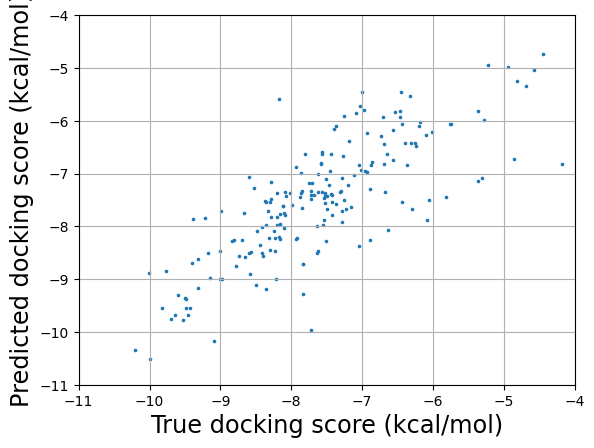

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
print(lstm_preds)
print(lstm_truth)
plt.scatter(lstm_truth, lstm_preds, s=10.0, marker='.')
plt.xlim(xmin=-11, xmax=-4)
plt.ylim(ymin=-11, ymax=-4)
plt.xlabel("True docking score (kcal/mol)", fontsize='xx-large')
plt.ylabel("Predicted docking score (kcal/mol)", fontsize='xx-large')
plt.grid()
#plt.show()

In [ ]:
lstm_pearson = np.corrcoef(lstm_preds, lstm_truth)[0,1]
print(f"Pearson Corr. Coef.: {lstm_pearson:.2f}")

Pearson Corr. Coef.: 0.80


## ZINC DB를 이용한 screening
-----
이제 예측된 docking score predictor를 이용해서 더 큰 library screening을 진행해보자.
실습을 위해서 10,000 개의 분자의 affinity 값을 예측해본다.

In [ ]:
!wget -O zinc10k.smi https://www.dropbox.com/s/57m41ddui9w39c5/zinc10k.smi?dl=1

--2024-11-21 10:20:57--  https://www.dropbox.com/s/57m41ddui9w39c5/zinc10k.smi?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/bg6neg4tx5198wkx74b5l/zinc10k.smi?rlkey=w54qehjdq2invh189jek4k5ia&dl=1 [following]
--2024-11-21 10:20:58--  https://www.dropbox.com/scl/fi/bg6neg4tx5198wkx74b5l/zinc10k.smi?rlkey=w54qehjdq2invh189jek4k5ia&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d9a85a21c5c2546c848b96104.dl.dropboxusercontent.com/cd/0/inline/CewBLI3JxPLGtf9bDrtWp5FvfoWDZ22WPzFeenLljRTUHthjsS85OhehRJXDleZU72SvR5k5G3E0rpvMlnodmHHzy6TH-V2CursVj5kCpqP8dWPSDI04Cc57Nkw0XnmdTYt06zOu281wLH8Dh4eXWcmL/file?dl=1# [following]
--2024-11-21 10:20:59--  https://uc4d9a85a21c5c2546c848b96104.dl.dropboxusercontent

In [ ]:
zinc_list = []
with open("zinc10k.smi") as fp:
  for l in fp:
    zinc_list.append(l.strip())

In [ ]:
padded_zinc_list = []
for smi in zinc_list:
  if len(smi) > max_len: continue
  padded_smi = add_padding(smi)
  padded_zinc_list.append(padded_smi)
print(len(padded_zinc_list))

9995


In [ ]:
X_test, X_test_int = vectorize(padded_zinc_list)

In [ ]:
len(X_test)

9995

In [ ]:
%%time
pred_results=[]
for input, smi in zip(X_test, zinc_list):
  inp = torch.tensor(input, dtype=torch.float).to(device)
  #print(inp)
  output = lstm_model(inp)
  #print(f"{smi}, {output.item():.3f}")
  pred_results.append((smi, output.item()))
pred_results.sort(key=lambda x:x[1])

CPU times: user 4.91 s, sys: 4.31 ms, total: 4.92 s
Wall time: 4.9 s


In [ ]:
from tqdm.auto import tqdm
from rdkit import Chem

## Top candidates의 구조 확인
-------


In [ ]:
mol = Chem.MolFromSmiles(pred_results[0][0])

In [ ]:
pred_results[0][0]

'CCN(C(=O)c1cc(OC)ccc1[N+](=O)[O-])C1CCCC1'

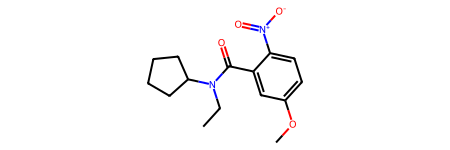

In [ ]:
mol

In [ ]:
top_candidates = []
n_top = 20
for smi, score in pred_results[:n_top]:
  top_candidates.append(
    {
      "smiles": smi,
      "rdkit_molecule": Chem.MolFromSmiles(smi),
      "score": f"Pred Ene:{score:.2f}",
    }
  )
top_mols = pd.DataFrame(top_candidates)

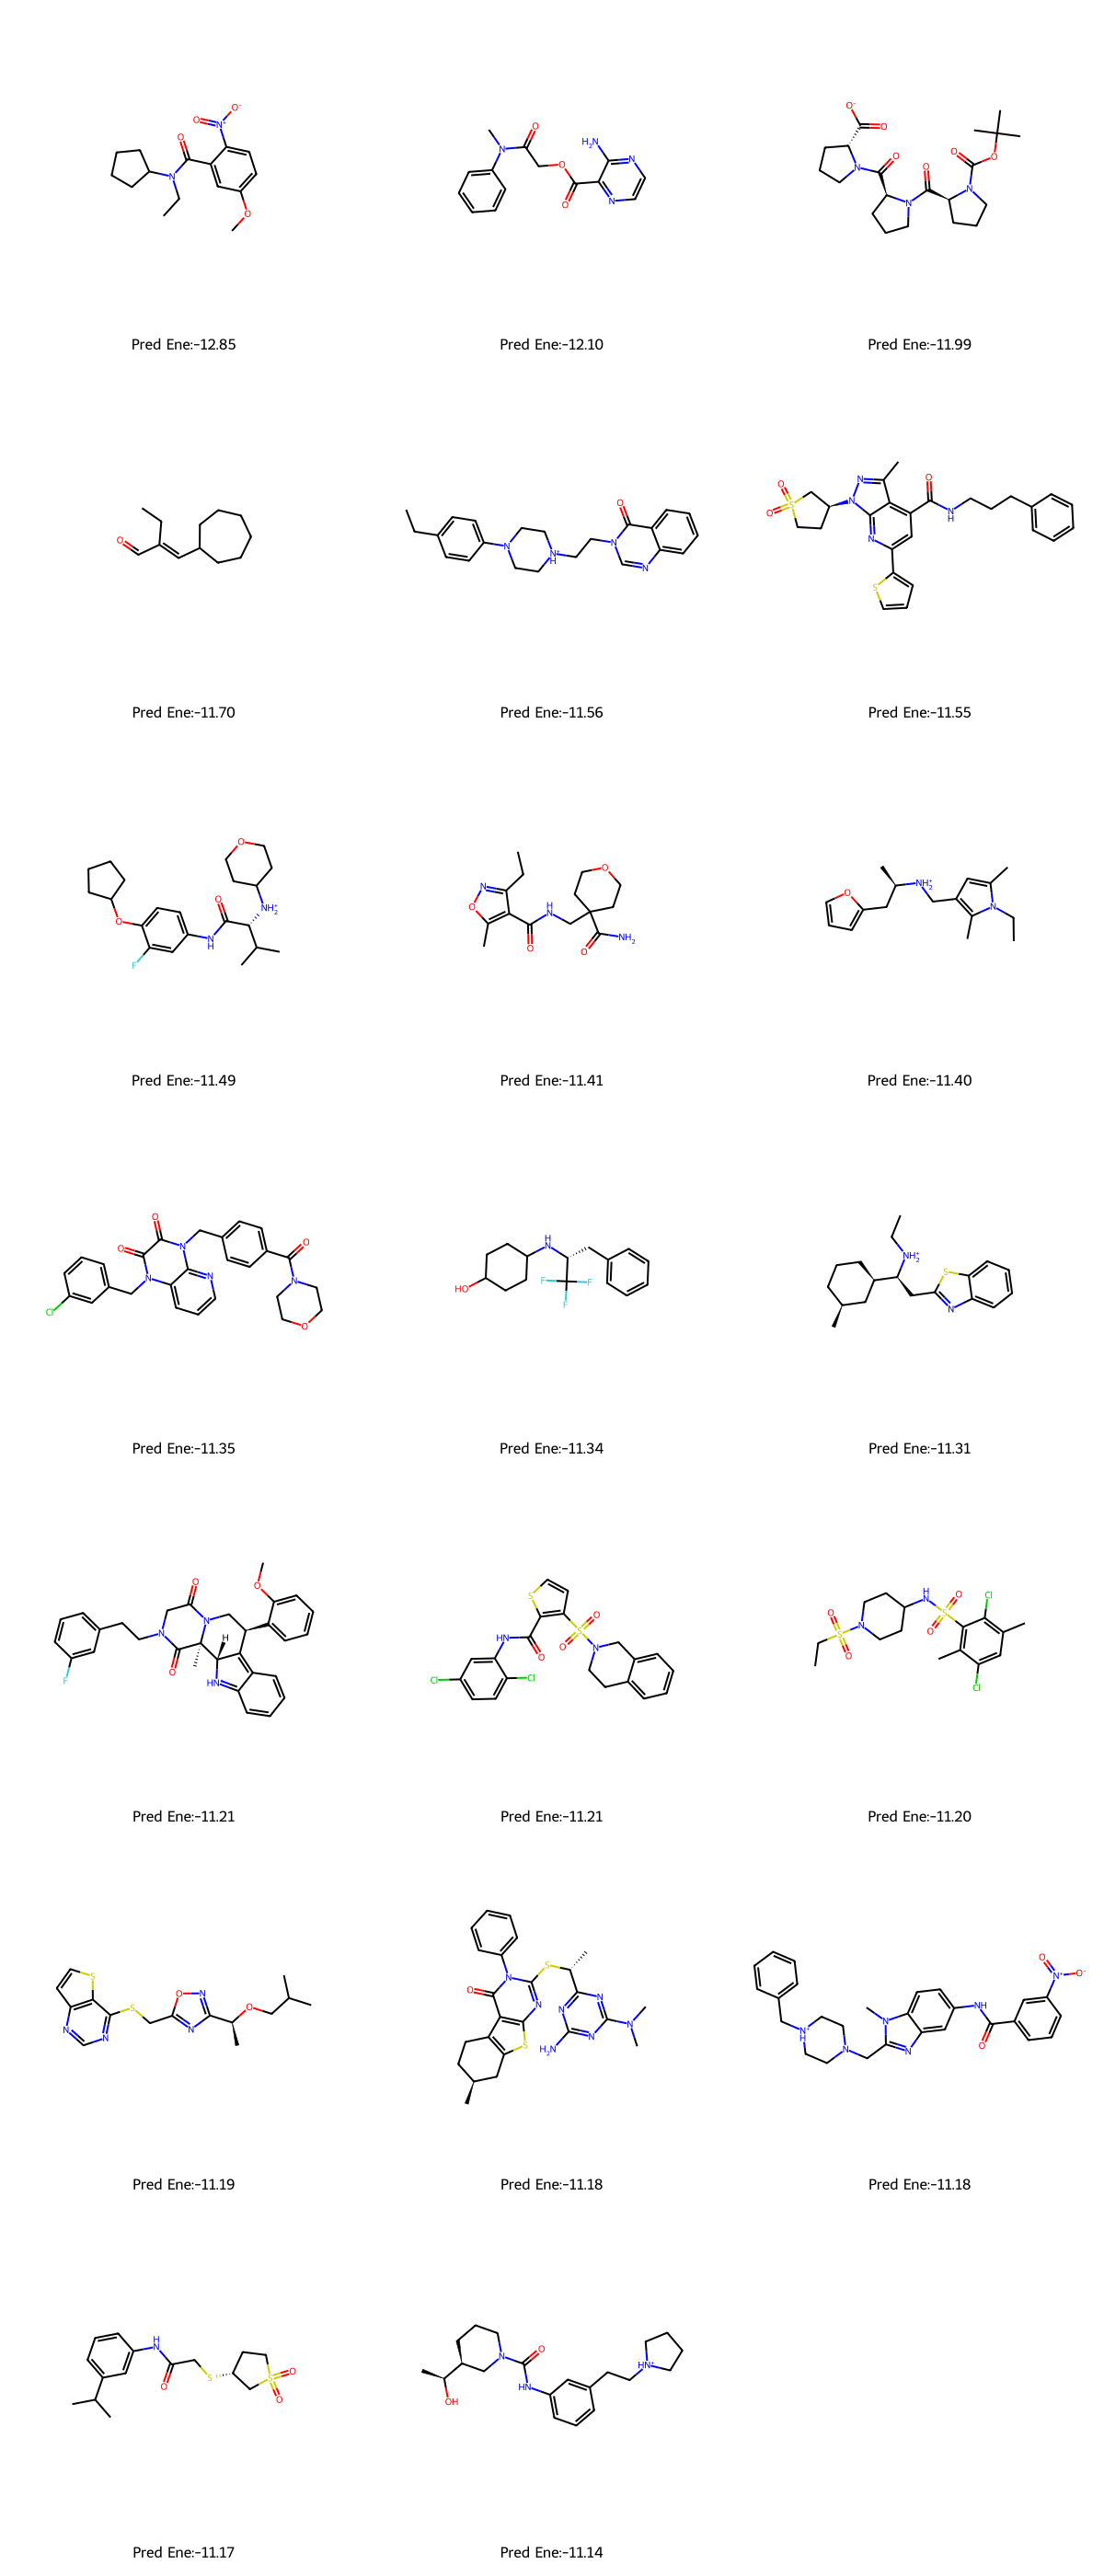

In [ ]:
Chem.Draw.MolsToGridImage(
    list(top_mols.head(n_top).rdkit_molecule),
    legends=list(top_mols.head(n_top)["score"]),
    subImgSize=(400,400),
)

# PAINS filter

**Pan-assay interference compounds (PAINS)** are promiscuous bindiners, which can mislead hit identification efforts.

Pan-assay intererence compounds, PAINS라고 불리는 화합물들은 많은 단백질에 선택성 없이 활성을 나타내는 것으로 알려져있다. 그러므로 실제 drug discovery를 위해서는 PAINS에 해당하는 compound, functional group을 제외할 필요가 있다.

ref: Baell, J., Walters, M. Chemistry: Chemical con artists foil drug discovery. Nature 513, 481–483 (2014). https://doi.org/10.1038/513481a

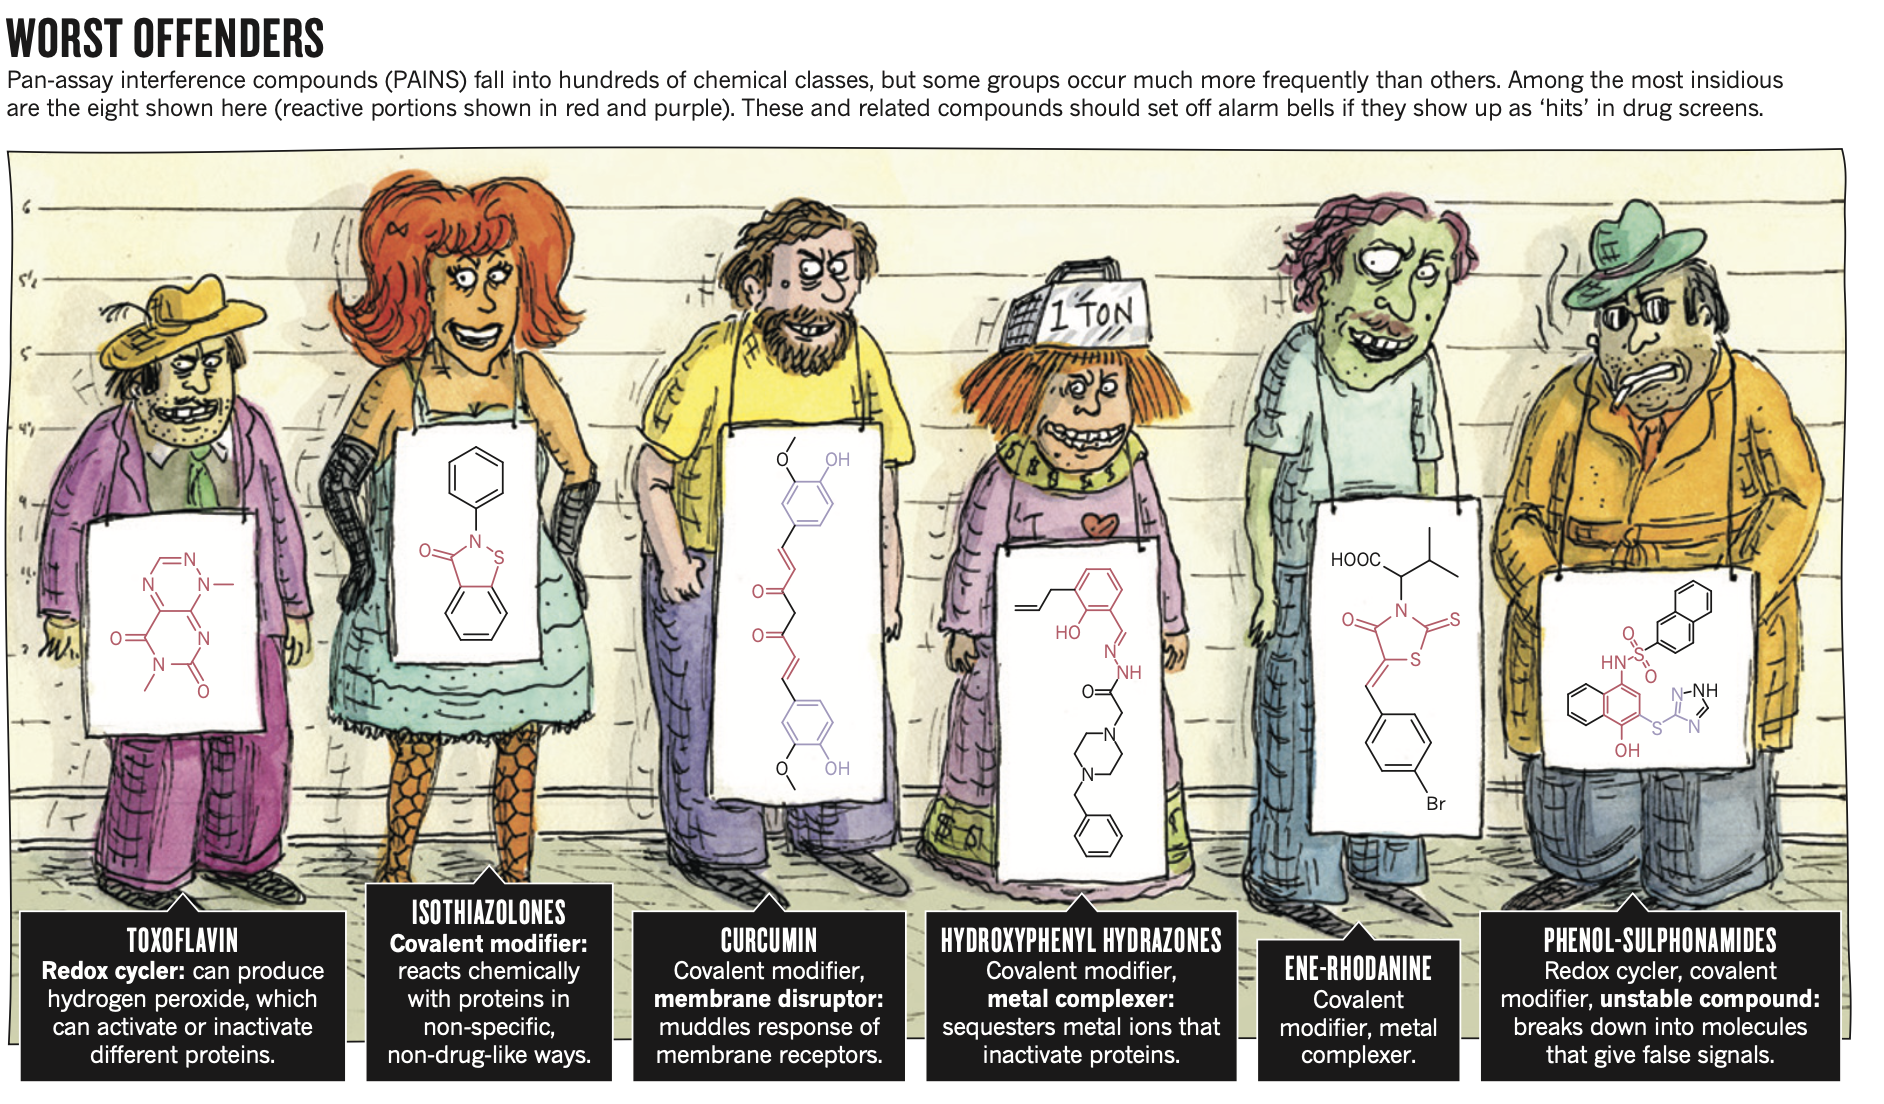

PAINS filter is already implemented in RDKit

In [ ]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [ ]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [ ]:
# search for PAINS
matches = []
clean = []
for smi, score in pred_results:
    molecule = Chem.MolFromSmiles(smi)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "smiles": smi,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append((smi, score))

matches = pd.DataFrame(matches)

In [ ]:
matches

smiles  \
0         CCc1ccc(N2CC[NH+](CCn3cnc4ccccc4c3=O)CC2)cc1   
1    Cc1ccc(C(=O)Nc2ccc3[nH]c(C)c([C@H](c4ccccn4)N4...   
2    N=C1/C(=C/c2ccc(OCc3cccc4ccccc34)cc2)C(=O)N=C2...   
3    Cc1ccc(OCCOc2ccc(/C=C3/C(=O)N(c4ccc(C)cc4)C(=O...   
4               Nc1c(C(=O)NCc2cccnc2)sc(=S)n1-c1ccccc1   
..                                                 ...   
336      Cc1cccc(-n2nnnc2C2(Nc3ccc4c(c3)OCCO4)CCCC2)c1   
337  CCCC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1ccc(Cl)cc1   
338        Cc1[nH]c2ccccc2c1C1CC[NH+](CC(=O)NC2CC2)CC1   
339  Cc1cc(/C=C2/C(=N)N3C=CSC3=NC2=O)c(C)n1-c1cccc(...   
340  Cc1[nH]c2ccc(CNS(=O)(=O)N3C[C@H](C)O[C@H](C)C3...   

                                       rdkit_molecule                 pains  
0    <rdkit.Chem.rdchem.Mol object at 0x78261019cc10>    Anil_di_alk_e(186)  
1    <rdkit.Chem.rdchem.Mol object at 0x78261019c740>    Indol_3yl_alk(461)  
2    <rdkit.Chem.rdchem.Mol object at 0x78261019c660>    Ene_six_het_a(483)  
3    <rdkit.Chem.rdchem.Mol object at 0x78261019c7b0>    Ene_six_het_a(483)  
4    <rdkit.Chem.rdchem.Mol object at 0x78261019c890>       Thiaz_ene_b(17)  
..                                                ...                   ...  
336  <rdkit.Chem.rdchem.Mol object at 0x7825bde11e70>    Anil_di_alk_c(246)  
337  <rdkit.Chem.rdchem.Mol object at 0x7825bde11fc0>  Thio_carbonate_a(15)  
338  <rdkit.Chem.rdchem.Mol object at 0x7825bde12030>    Indol_3yl_alk(461)  
339  <rdkit.Chem.rdchem.Mol object at 0x7825bde12180>    Ene_six_het_a(483)  
340  <rdkit.Chem.rdchem.Mol object at 0x7825bde121f0>    Indol_3yl_alk(461)  

[341 rows x 3 columns]

In [ ]:
print(f"Number of clean molecules: {len(clean)}")

Number of clean molecules: 9654


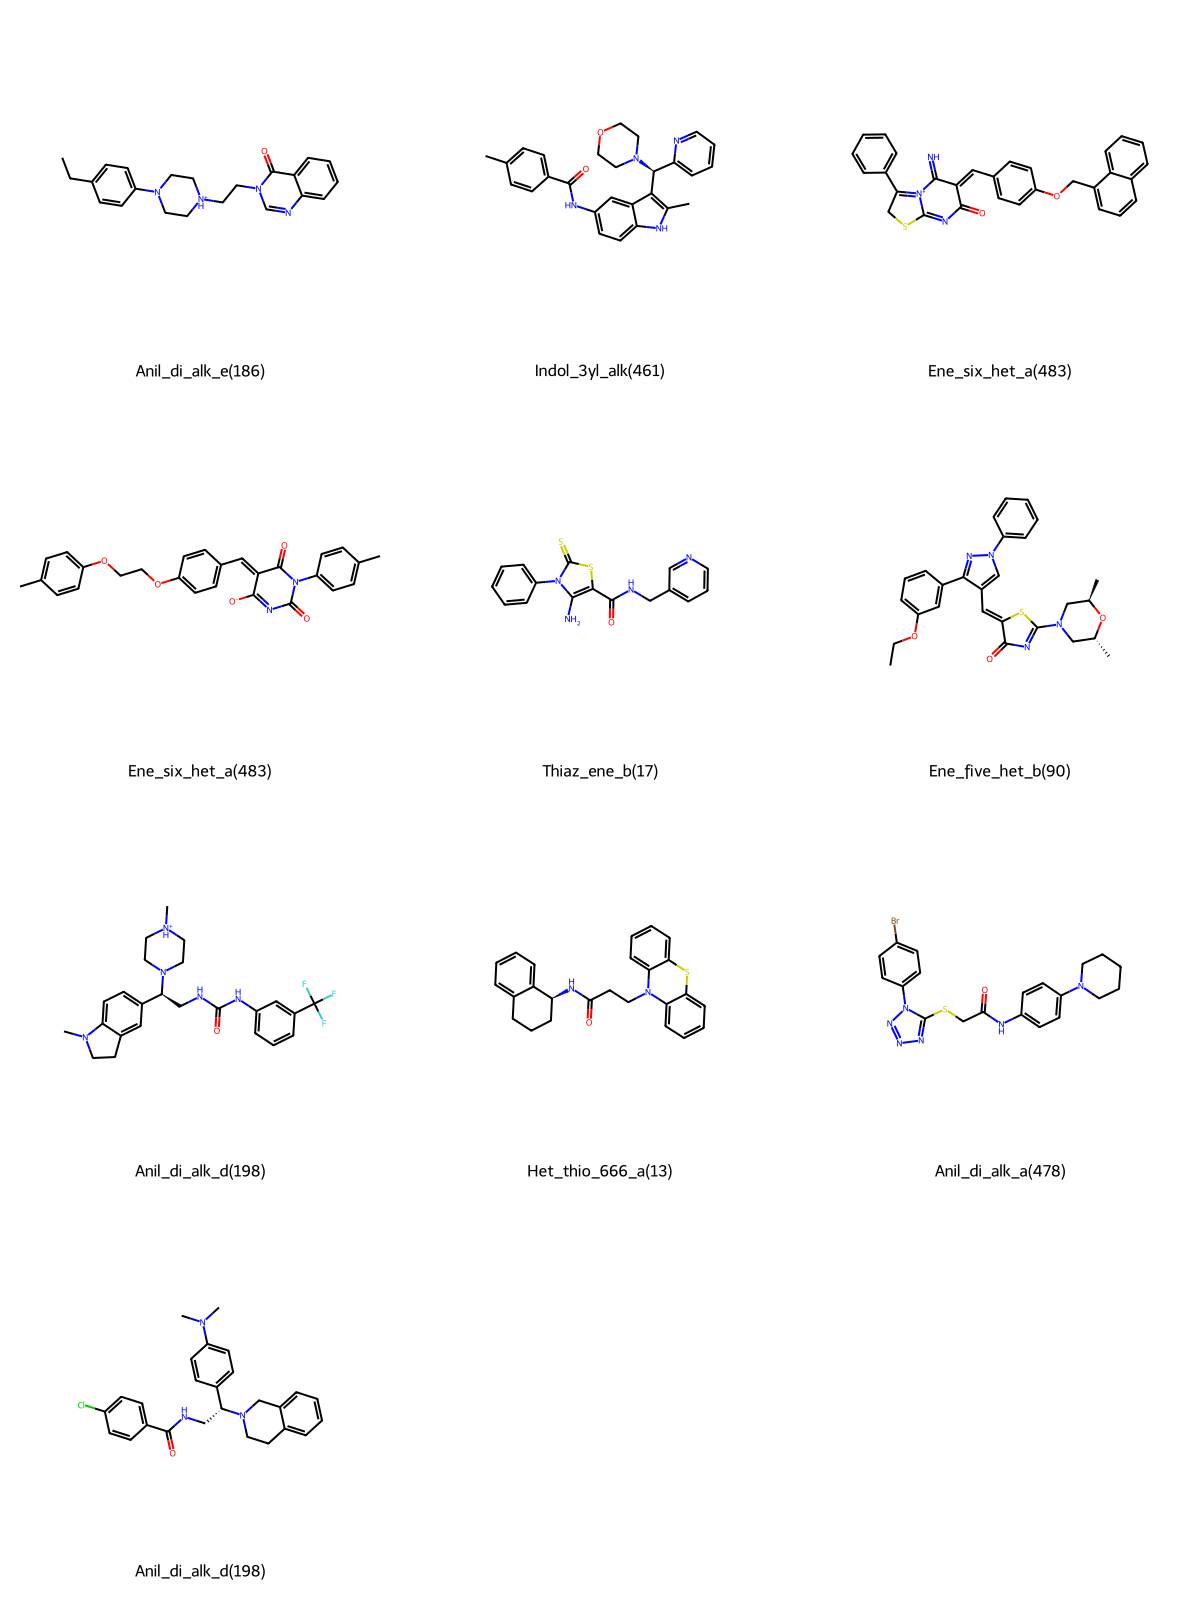

In [ ]:
Chem.Draw.MolsToGridImage(
    list(matches.head(10).rdkit_molecule),
    legends=list(matches.head(10)["pains"]),
    subImgSize=(400,400),
)

## Highlighting PAINS filter
-----

In [ ]:
substructures = pd.read_csv("https://raw.githubusercontent.com/iwatobipen/rdkit_pains/master/pains.txt", sep=' ', header=None)

PAINS patter은 SMARTS pattern으로 표현되어 있다.


<img src="https://pubs.acs.org/cms/10.1021/acs.jcim.9b00249/asset/images/large/ci-2019-00249u_0004.jpeg">

More about SMARTS patterns:

https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html

In [ ]:
substructures["rdkit_molecule"] = substructures[0].apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 481


In [ ]:
substructures

0                     1  \
0    [#6]-1(-[#6](~[!#6&!#1]~[#6]-[!#6&!#1]-[#6]-1=...    ene_six_het_A(483)   
1            c:1:c:c(:c(:c:c:1)-[#6]=[#7]-[#7])-[O;H1]   hzone_phenol_A(479)   
2    [C;H2]N([C;H2])c1cc([$([H]),$([C;H2]),$([O][C;...    anil_di_alk_A(478)   
3    n:1(c(c(c:2:c:1:c:c:c:c:2-[H])-[C;D4]-[H])-[$(...    indol_3yl_alk(461)   
4    [!#6&!#1]=[#6]-1-[#6]=,:[#6]-[#6](=[!#6&!#1])-...        quinone_A(370)   
..                                                 ...                   ...   
476  [#7](-[#1])(-[#1])-[#6]-1=[#6](-[#6]#[#7])-[#6...     dhp_amino_CN_H(1)   
477  [#6](-[#1])(-[#1])-[#8]-c:1:c(:c(:c(:c(:c:1-[#...     het_66_anisole(1)   
478  [#6](-[#1])(-[#1])-[#8]-c:1:c(:c(:c(:c(:c:1-[#...   thiazole_amine_N(1)   
479  [#6]~1~3~[#7](-[#6]:[#6])~[#6]~[#6]~[#6]~[#6]~...  het_pyridiniums_C(1)   
480  [#7]-3(-c:2:c:1:c:c:c:c:c:1:c:c:c:2)-[#7]=[#6]...            het_5_E(1)   

                                       rdkit_molecule  
0    <rdkit.Chem.rdchem.Mol object at 0x7825bde6c7b0>  
1    <rdkit.Chem.rdchem.Mol object at 0x7825bde6c820>  
2    <rdkit.Chem.rdchem.Mol object at 0x7825bde6c890>  
3    <rdkit.Chem.rdchem.Mol object at 0x7825bde6c900>  
4    <rdkit.Chem.rdchem.Mol object at 0x7825bde6c970>  
..                                                ...  
476  <rdkit.Chem.rdchem.Mol object at 0x7825bde8d9a0>  
477  <rdkit.Chem.rdchem.Mol object at 0x7825bde8da10>  
478  <rdkit.Chem.rdchem.Mol object at 0x7825bde8da80>  
479  <rdkit.Chem.rdchem.Mol object at 0x7825bde8daf0>  
480  <rdkit.Chem.rdchem.Mol object at 0x7825bde8db60>  

[481 rows x 3 columns]

PAINS filter에 해당하는 구조가 있는지 `HasSubstructMatch` method를 이용해서 확인한다.

In [ ]:
# search for unwanted substructure
matches = []
clean = []
for smi, score in tqdm(pred_results[:1000]):
  molecule = Chem.MolFromSmiles(smi)
  match = False
  for _, substructure in substructures.iterrows():
    if molecule.HasSubstructMatch(substructure.rdkit_molecule):
        matches.append(
          {
              "smiles": smi,
              "rdkit_molecule": molecule,
              "substructure": substructure.rdkit_molecule,
              "substructure_name": substructure[1],
          }
        )
        match = True
  if not match:
    clean.append(smi)

matches = pd.DataFrame(matches)

  0%|          | 0/1000 [00:00<?, ?it/s]

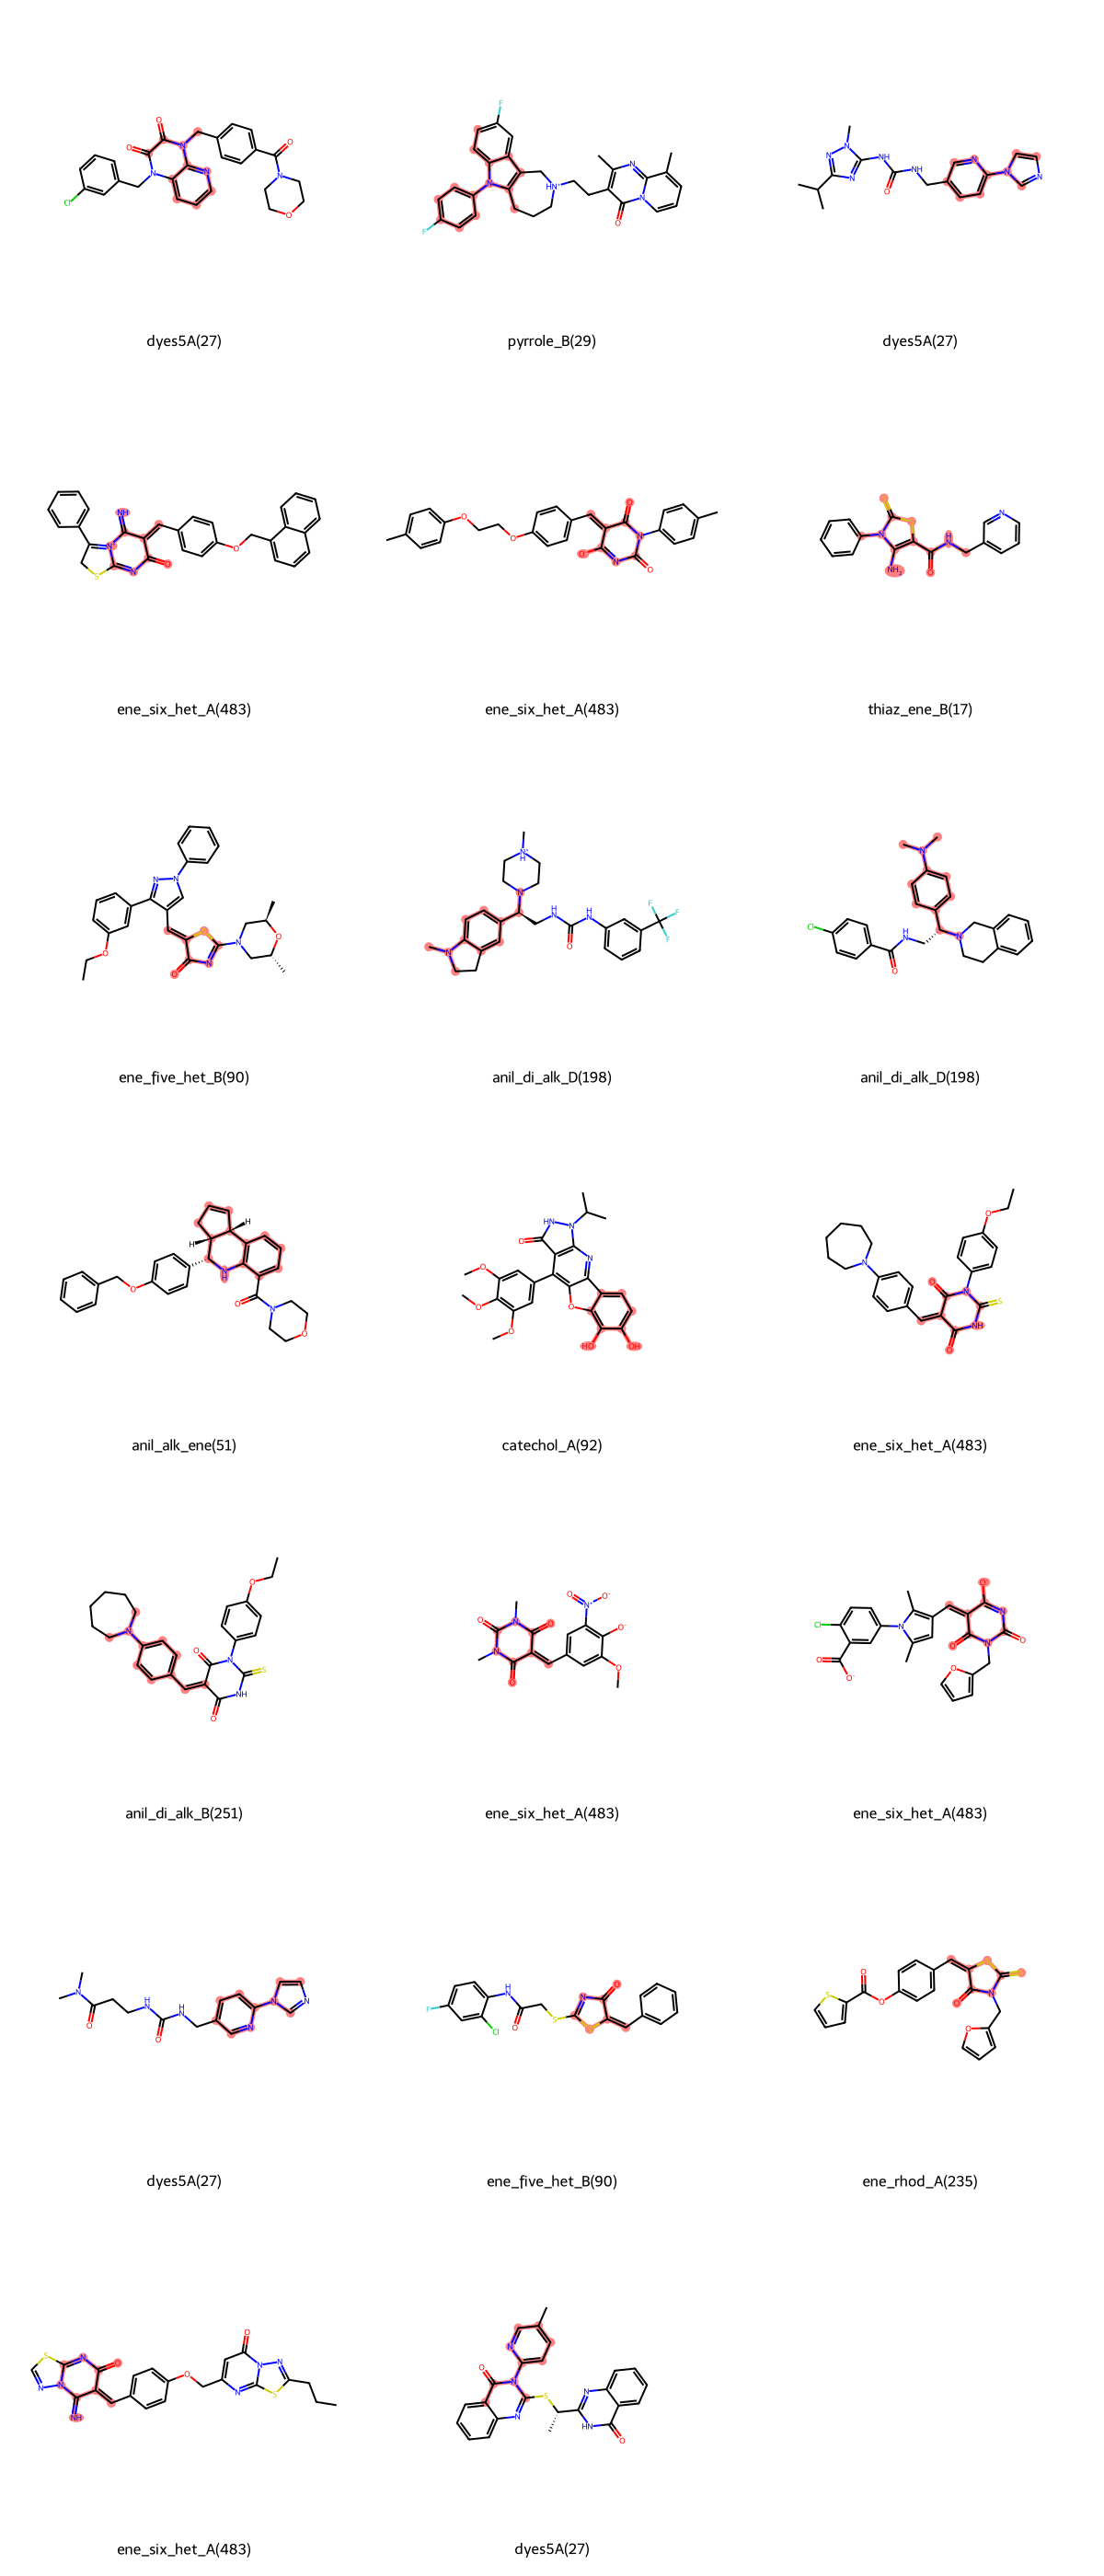

In [ ]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(n_top).iterrows()
]

Chem.Draw.MolsToGridImage(
    list(matches.head(n_top).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(n_top).substructure_name),
    subImgSize=(400,400),
)

In addition to PAINS, there are more filters implemented in RDKit

http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html

<img src="https://chemistry-europe.onlinelibrary.wiley.com/cms/asset/4300c129-ab8c-40b7-a6ef-a2d854a44fd3/mcontent.jpg">

PAINS 이외에 다른 filter들도 많이 존재한다.
* BRENK: https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139
* BMS (Bristol-Myers Squibb): https://pubs.acs.org/doi/10.1021/jm301008n
* Glaxo: https://www.sciencedirect.com/science/article/pii/S135964460503730X
* LINT (by Pfizer): https://www.eurekaselect.com/article/24760
* Dundee: https://pubs.acs.org/doi/pdf/10.1021/ci300382f

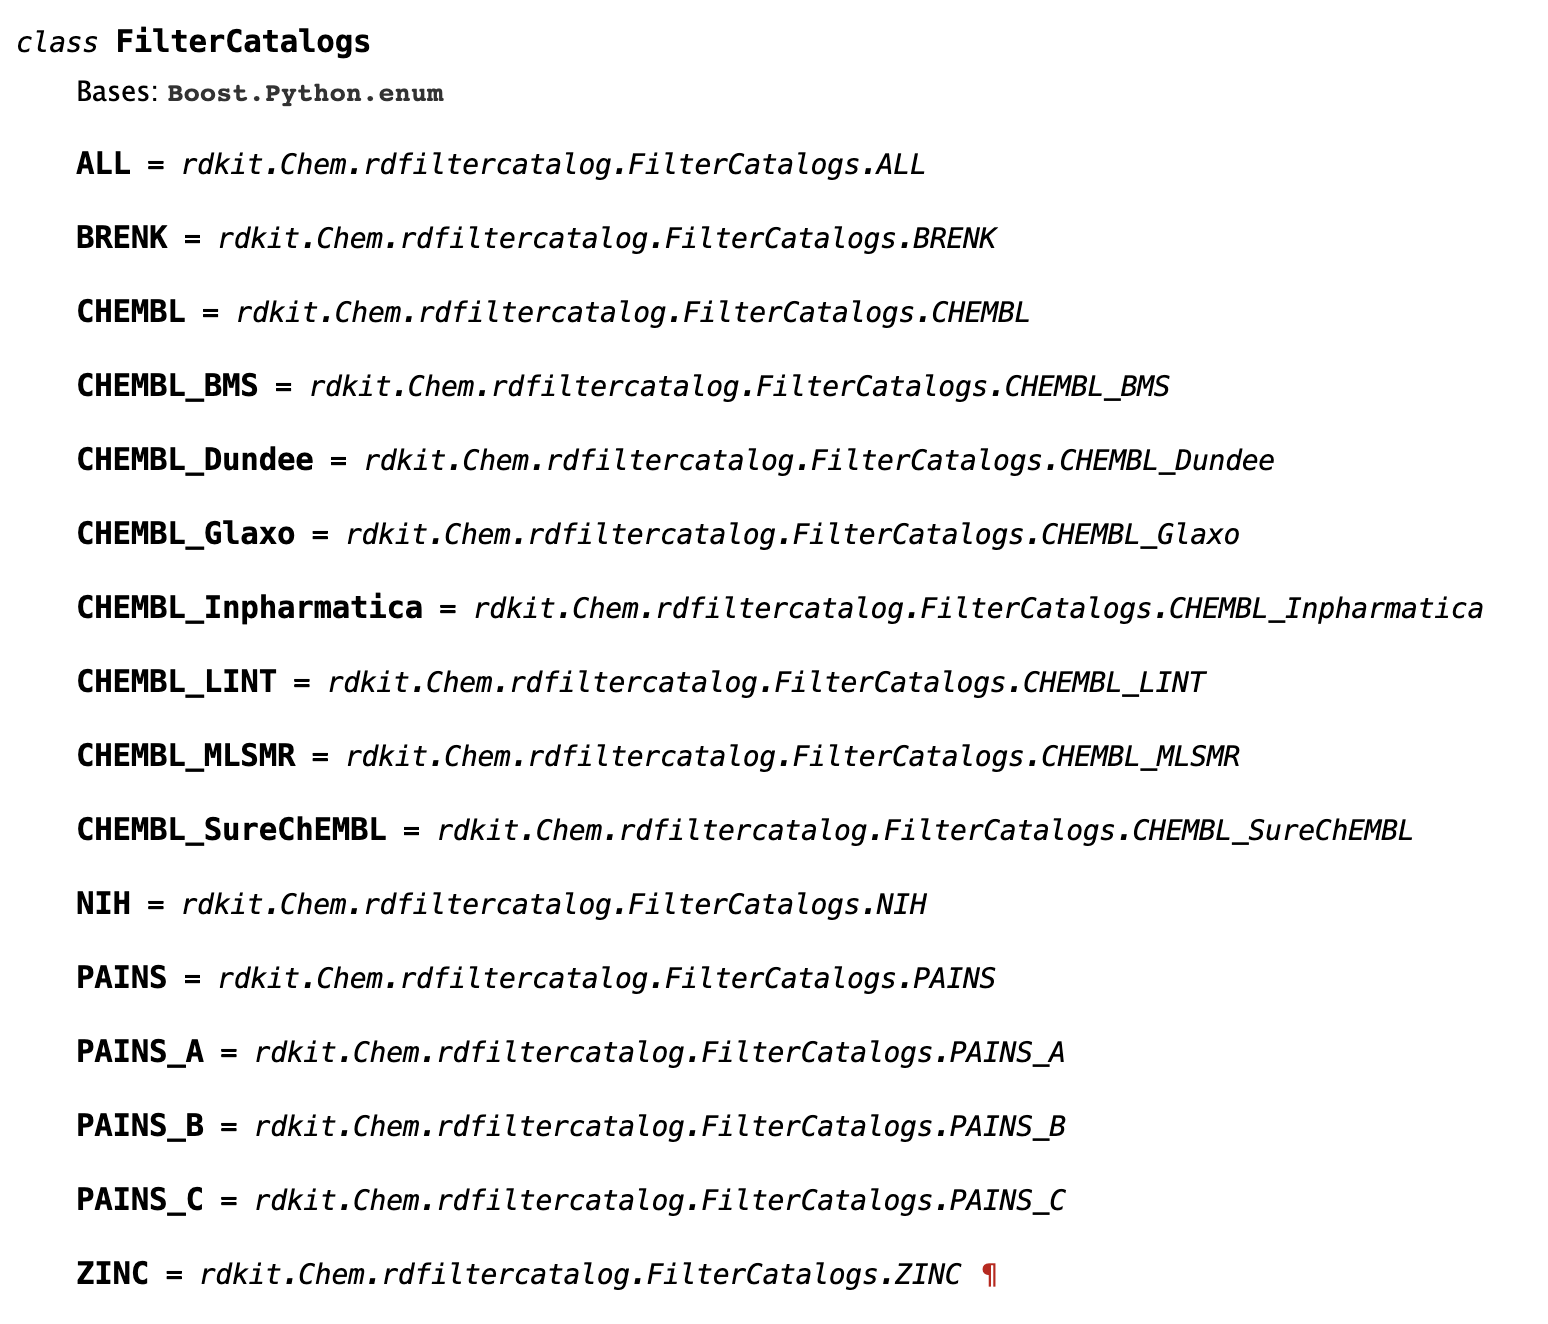

# Homework #1: GRU cell을 이용해서 docking score 예측 모델을 만들고 performance를 비교해보라.

nn.GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, dims, gru_size, fc_hidden_size, dropout_rate, out_size):
        super(GRUNet, self).__init__()

        length = dims[0]
        number_tokens = dims[1]

        self.gru = nn.GRU(input_size=number_tokens, hidden_size=gru_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(gru_size, fc_hidden_size)
        self.activation = nn.ReLU()
        self.fc_out = nn.Linear(fc_hidden_size, out_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, h_n = self.gru(x)
        out = self.dropout(h_n[-1])
        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        return out

gru_size = 64
fc_hidden_size = 128
dropout_rate = 0.2
output_size = 1
learning_rate = 0.001
epochs = 200


gru_model = GRUNet(dims, gru_size, fc_hidden_size, dropout_rate, output_size)
gru_model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


In [ ]:
from tqdm import tqdm

gru_model.train()
train_losses = []

for e in range(epochs):
    running_loss = 0.0

    for input, labels in tqdm(train_loader):
        input = input.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = gru_model(input)
        output = output.squeeze()

        loss = criterion(output, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), 1)
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch: {e+1} Running Loss: {running_loss/len(train_loader):.4f}")

gru_model.eval()


gru_preds = []
gru_truth = []

with torch.no_grad():
    for input, labels in tqdm(test_loader):
        input = input.to(device)
        labels = labels.to(device)

        output = gru_model(input)
        output = output.squeeze()

        gru_preds.append(output.item())
        gru_truth.append(labels.item())


100%|██████████| 98/98 [00:00<00:00, 228.92it/s]


Epoch: 1 Running Loss: 0.1928


100%|██████████| 98/98 [00:00<00:00, 227.18it/s]


Epoch: 2 Running Loss: 0.2141


100%|██████████| 98/98 [00:00<00:00, 230.53it/s]


Epoch: 3 Running Loss: 0.2383


100%|██████████| 98/98 [00:00<00:00, 234.70it/s]


Epoch: 4 Running Loss: 0.1985


100%|██████████| 98/98 [00:00<00:00, 225.93it/s]


Epoch: 5 Running Loss: 0.2402


100%|██████████| 98/98 [00:00<00:00, 233.48it/s]


Epoch: 6 Running Loss: 0.2038


100%|██████████| 98/98 [00:00<00:00, 214.34it/s]


Epoch: 7 Running Loss: 0.1997


100%|██████████| 98/98 [00:00<00:00, 208.95it/s]


Epoch: 8 Running Loss: 0.2038


100%|██████████| 98/98 [00:00<00:00, 186.44it/s]


Epoch: 9 Running Loss: 0.2076


100%|██████████| 98/98 [00:00<00:00, 206.39it/s]


Epoch: 10 Running Loss: 0.1987


100%|██████████| 98/98 [00:00<00:00, 216.94it/s]


Epoch: 11 Running Loss: 0.2013


100%|██████████| 98/98 [00:00<00:00, 224.27it/s]


Epoch: 12 Running Loss: 0.1968


100%|██████████| 98/98 [00:00<00:00, 232.54it/s]


Epoch: 13 Running Loss: 0.2211


100%|██████████| 98/98 [00:00<00:00, 234.48it/s]


Epoch: 14 Running Loss: 0.2093


100%|██████████| 98/98 [00:00<00:00, 233.49it/s]


Epoch: 15 Running Loss: 0.1925


100%|██████████| 98/98 [00:00<00:00, 235.30it/s]


Epoch: 16 Running Loss: 0.2045


100%|██████████| 98/98 [00:00<00:00, 233.78it/s]


Epoch: 17 Running Loss: 0.1952


100%|██████████| 98/98 [00:00<00:00, 230.64it/s]


Epoch: 18 Running Loss: 0.1534


100%|██████████| 98/98 [00:00<00:00, 228.92it/s]


Epoch: 19 Running Loss: 0.1899


100%|██████████| 98/98 [00:00<00:00, 232.16it/s]


Epoch: 20 Running Loss: 0.1841


100%|██████████| 98/98 [00:00<00:00, 230.75it/s]


Epoch: 21 Running Loss: 0.1873


100%|██████████| 98/98 [00:00<00:00, 220.69it/s]


Epoch: 22 Running Loss: 0.1557


100%|██████████| 98/98 [00:00<00:00, 227.71it/s]


Epoch: 23 Running Loss: 0.1968


100%|██████████| 98/98 [00:00<00:00, 229.43it/s]


Epoch: 24 Running Loss: 0.1813


100%|██████████| 98/98 [00:00<00:00, 230.86it/s]


Epoch: 25 Running Loss: 0.1639


100%|██████████| 98/98 [00:00<00:00, 232.31it/s]


Epoch: 26 Running Loss: 0.1570


100%|██████████| 98/98 [00:00<00:00, 222.72it/s]


Epoch: 27 Running Loss: 0.1473


100%|██████████| 98/98 [00:00<00:00, 224.41it/s]


Epoch: 28 Running Loss: 0.1627


100%|██████████| 98/98 [00:00<00:00, 232.72it/s]


Epoch: 29 Running Loss: 0.1449


100%|██████████| 98/98 [00:00<00:00, 214.39it/s]


Epoch: 30 Running Loss: 0.1338


100%|██████████| 98/98 [00:00<00:00, 219.28it/s]


Epoch: 31 Running Loss: 0.1505


100%|██████████| 98/98 [00:00<00:00, 208.81it/s]


Epoch: 32 Running Loss: 0.1491


100%|██████████| 98/98 [00:00<00:00, 216.24it/s]


Epoch: 33 Running Loss: 0.1362


100%|██████████| 98/98 [00:00<00:00, 202.97it/s]


Epoch: 34 Running Loss: 0.1472


100%|██████████| 98/98 [00:00<00:00, 196.23it/s]


Epoch: 35 Running Loss: 0.1305


100%|██████████| 98/98 [00:00<00:00, 196.68it/s]


Epoch: 36 Running Loss: 0.1418


100%|██████████| 98/98 [00:00<00:00, 209.32it/s]


Epoch: 37 Running Loss: 0.1354


100%|██████████| 98/98 [00:00<00:00, 204.01it/s]


Epoch: 38 Running Loss: 0.1264


100%|██████████| 98/98 [00:00<00:00, 209.44it/s]


Epoch: 39 Running Loss: 0.1446


100%|██████████| 98/98 [00:00<00:00, 202.08it/s]


Epoch: 40 Running Loss: 0.1579


100%|██████████| 98/98 [00:00<00:00, 206.86it/s]


Epoch: 41 Running Loss: 0.1504


100%|██████████| 98/98 [00:00<00:00, 221.12it/s]


Epoch: 42 Running Loss: 0.1388


100%|██████████| 98/98 [00:00<00:00, 205.73it/s]


Epoch: 43 Running Loss: 0.1307


100%|██████████| 98/98 [00:00<00:00, 212.41it/s]


Epoch: 44 Running Loss: 0.1257


100%|██████████| 98/98 [00:00<00:00, 196.70it/s]


Epoch: 45 Running Loss: 0.1438


100%|██████████| 98/98 [00:00<00:00, 205.84it/s]


Epoch: 46 Running Loss: 0.1525


100%|██████████| 98/98 [00:00<00:00, 216.08it/s]


Epoch: 47 Running Loss: 0.1366


100%|██████████| 98/98 [00:00<00:00, 198.38it/s]


Epoch: 48 Running Loss: 0.1432


100%|██████████| 98/98 [00:00<00:00, 196.02it/s]


Epoch: 49 Running Loss: 0.1361


100%|██████████| 98/98 [00:00<00:00, 225.13it/s]


Epoch: 50 Running Loss: 0.1252


100%|██████████| 98/98 [00:00<00:00, 226.09it/s]


Epoch: 51 Running Loss: 0.1211


100%|██████████| 98/98 [00:00<00:00, 226.13it/s]


Epoch: 52 Running Loss: 0.1293


100%|██████████| 98/98 [00:00<00:00, 227.68it/s]


Epoch: 53 Running Loss: 0.1306


100%|██████████| 98/98 [00:00<00:00, 233.13it/s]


Epoch: 54 Running Loss: 0.1289


100%|██████████| 98/98 [00:00<00:00, 227.35it/s]


Epoch: 55 Running Loss: 0.1161


100%|██████████| 98/98 [00:00<00:00, 223.17it/s]


Epoch: 56 Running Loss: 0.1130


100%|██████████| 98/98 [00:00<00:00, 227.04it/s]


Epoch: 57 Running Loss: 0.1333


100%|██████████| 98/98 [00:00<00:00, 201.06it/s]


Epoch: 58 Running Loss: 0.1272


100%|██████████| 98/98 [00:00<00:00, 209.08it/s]


Epoch: 59 Running Loss: 0.1065


100%|██████████| 98/98 [00:00<00:00, 194.23it/s]


Epoch: 60 Running Loss: 0.1055


100%|██████████| 98/98 [00:00<00:00, 213.70it/s]


Epoch: 61 Running Loss: 0.1299


100%|██████████| 98/98 [00:00<00:00, 235.17it/s]


Epoch: 62 Running Loss: 0.1174


100%|██████████| 98/98 [00:00<00:00, 227.69it/s]


Epoch: 63 Running Loss: 0.1223


100%|██████████| 98/98 [00:00<00:00, 227.30it/s]


Epoch: 64 Running Loss: 0.1184


100%|██████████| 98/98 [00:00<00:00, 223.67it/s]


Epoch: 65 Running Loss: 0.1152


100%|██████████| 98/98 [00:00<00:00, 220.25it/s]


Epoch: 66 Running Loss: 0.1219


100%|██████████| 98/98 [00:00<00:00, 219.74it/s]


Epoch: 67 Running Loss: 0.0965


100%|██████████| 98/98 [00:00<00:00, 220.88it/s]


Epoch: 68 Running Loss: 0.1255


100%|██████████| 98/98 [00:00<00:00, 219.40it/s]


Epoch: 69 Running Loss: 0.1155


100%|██████████| 98/98 [00:00<00:00, 223.16it/s]


Epoch: 70 Running Loss: 0.1026


100%|██████████| 98/98 [00:00<00:00, 227.68it/s]


Epoch: 71 Running Loss: 0.1102


100%|██████████| 98/98 [00:00<00:00, 229.79it/s]


Epoch: 72 Running Loss: 0.1097


100%|██████████| 98/98 [00:00<00:00, 227.99it/s]


Epoch: 73 Running Loss: 0.1336


100%|██████████| 98/98 [00:00<00:00, 222.18it/s]


Epoch: 74 Running Loss: 0.1483


100%|██████████| 98/98 [00:00<00:00, 207.12it/s]


Epoch: 75 Running Loss: 0.1196


100%|██████████| 98/98 [00:00<00:00, 202.39it/s]


Epoch: 76 Running Loss: 0.1067


100%|██████████| 98/98 [00:00<00:00, 210.81it/s]


Epoch: 77 Running Loss: 0.1065


100%|██████████| 98/98 [00:00<00:00, 221.20it/s]


Epoch: 78 Running Loss: 0.1043


100%|██████████| 98/98 [00:00<00:00, 223.78it/s]


Epoch: 79 Running Loss: 0.1043


100%|██████████| 98/98 [00:00<00:00, 220.89it/s]


Epoch: 80 Running Loss: 0.1216


100%|██████████| 98/98 [00:00<00:00, 226.67it/s]


Epoch: 81 Running Loss: 0.1086


100%|██████████| 98/98 [00:00<00:00, 228.69it/s]


Epoch: 82 Running Loss: 0.0969


100%|██████████| 98/98 [00:00<00:00, 214.58it/s]


Epoch: 83 Running Loss: 0.1220


100%|██████████| 98/98 [00:00<00:00, 200.10it/s]


Epoch: 84 Running Loss: 0.0991


100%|██████████| 98/98 [00:00<00:00, 206.72it/s]


Epoch: 85 Running Loss: 0.0916


100%|██████████| 98/98 [00:00<00:00, 190.97it/s]


Epoch: 86 Running Loss: 0.1025


100%|██████████| 98/98 [00:00<00:00, 214.17it/s]


Epoch: 87 Running Loss: 0.1174


100%|██████████| 98/98 [00:00<00:00, 222.33it/s]


Epoch: 88 Running Loss: 0.0930


100%|██████████| 98/98 [00:00<00:00, 229.02it/s]


Epoch: 89 Running Loss: 0.1017


100%|██████████| 98/98 [00:00<00:00, 217.50it/s]


Epoch: 90 Running Loss: 0.1036


100%|██████████| 98/98 [00:00<00:00, 228.09it/s]


Epoch: 91 Running Loss: 0.1023


100%|██████████| 98/98 [00:00<00:00, 226.30it/s]


Epoch: 92 Running Loss: 0.1205


100%|██████████| 98/98 [00:00<00:00, 225.36it/s]


Epoch: 93 Running Loss: 0.0950


100%|██████████| 98/98 [00:00<00:00, 230.81it/s]


Epoch: 94 Running Loss: 0.0903


100%|██████████| 98/98 [00:00<00:00, 225.12it/s]


Epoch: 95 Running Loss: 0.0946


100%|██████████| 98/98 [00:00<00:00, 224.72it/s]


Epoch: 96 Running Loss: 0.0850


100%|██████████| 98/98 [00:00<00:00, 225.23it/s]


Epoch: 97 Running Loss: 0.1094


100%|██████████| 98/98 [00:00<00:00, 226.53it/s]


Epoch: 98 Running Loss: 0.0909


100%|██████████| 98/98 [00:00<00:00, 228.35it/s]


Epoch: 99 Running Loss: 0.0954


100%|██████████| 98/98 [00:00<00:00, 223.96it/s]


Epoch: 100 Running Loss: 0.0789


100%|██████████| 98/98 [00:00<00:00, 224.44it/s]


Epoch: 101 Running Loss: 0.0981


100%|██████████| 98/98 [00:00<00:00, 231.65it/s]


Epoch: 102 Running Loss: 0.0978


100%|██████████| 98/98 [00:00<00:00, 226.17it/s]


Epoch: 103 Running Loss: 0.0860


100%|██████████| 98/98 [00:00<00:00, 223.89it/s]


Epoch: 104 Running Loss: 0.1102


100%|██████████| 98/98 [00:00<00:00, 229.15it/s]


Epoch: 105 Running Loss: 0.0827


100%|██████████| 98/98 [00:00<00:00, 220.45it/s]


Epoch: 106 Running Loss: 0.0963


100%|██████████| 98/98 [00:00<00:00, 225.22it/s]


Epoch: 107 Running Loss: 0.0798


100%|██████████| 98/98 [00:00<00:00, 225.82it/s]


Epoch: 108 Running Loss: 0.0951


100%|██████████| 98/98 [00:00<00:00, 226.48it/s]


Epoch: 109 Running Loss: 0.1020


100%|██████████| 98/98 [00:00<00:00, 217.59it/s]


Epoch: 110 Running Loss: 0.0841


100%|██████████| 98/98 [00:00<00:00, 206.99it/s]


Epoch: 111 Running Loss: 0.0988


100%|██████████| 98/98 [00:00<00:00, 196.06it/s]


Epoch: 112 Running Loss: 0.1189


100%|██████████| 98/98 [00:00<00:00, 212.34it/s]


Epoch: 113 Running Loss: 0.1077


100%|██████████| 98/98 [00:00<00:00, 226.89it/s]


Epoch: 114 Running Loss: 0.0844


100%|██████████| 98/98 [00:00<00:00, 219.48it/s]


Epoch: 115 Running Loss: 0.0854


100%|██████████| 98/98 [00:00<00:00, 226.05it/s]


Epoch: 116 Running Loss: 0.0844


100%|██████████| 98/98 [00:00<00:00, 219.91it/s]


Epoch: 117 Running Loss: 0.0936


100%|██████████| 98/98 [00:00<00:00, 223.31it/s]


Epoch: 118 Running Loss: 0.0823


100%|██████████| 98/98 [00:00<00:00, 225.71it/s]


Epoch: 119 Running Loss: 0.0874


100%|██████████| 98/98 [00:00<00:00, 230.28it/s]


Epoch: 120 Running Loss: 0.0961


100%|██████████| 98/98 [00:00<00:00, 222.01it/s]


Epoch: 121 Running Loss: 0.0719


100%|██████████| 98/98 [00:00<00:00, 226.14it/s]


Epoch: 122 Running Loss: 0.0761


100%|██████████| 98/98 [00:00<00:00, 225.82it/s]


Epoch: 123 Running Loss: 0.0830


100%|██████████| 98/98 [00:00<00:00, 221.15it/s]


Epoch: 124 Running Loss: 0.0859


100%|██████████| 98/98 [00:00<00:00, 218.30it/s]


Epoch: 125 Running Loss: 0.0865


100%|██████████| 98/98 [00:00<00:00, 231.05it/s]


Epoch: 126 Running Loss: 0.0759


100%|██████████| 98/98 [00:00<00:00, 232.57it/s]


Epoch: 127 Running Loss: 0.0808


100%|██████████| 98/98 [00:00<00:00, 225.26it/s]


Epoch: 128 Running Loss: 0.0750


100%|██████████| 98/98 [00:00<00:00, 231.09it/s]


Epoch: 129 Running Loss: 0.0796


100%|██████████| 98/98 [00:00<00:00, 228.33it/s]


Epoch: 130 Running Loss: 0.0780


100%|██████████| 98/98 [00:00<00:00, 232.98it/s]


Epoch: 131 Running Loss: 0.0711


100%|██████████| 98/98 [00:00<00:00, 230.68it/s]


Epoch: 132 Running Loss: 0.0710


100%|██████████| 98/98 [00:00<00:00, 229.79it/s]


Epoch: 133 Running Loss: 0.0749


100%|██████████| 98/98 [00:00<00:00, 232.91it/s]


Epoch: 134 Running Loss: 0.0657


100%|██████████| 98/98 [00:00<00:00, 233.44it/s]


Epoch: 135 Running Loss: 0.0816


100%|██████████| 98/98 [00:00<00:00, 215.28it/s]


Epoch: 136 Running Loss: 0.0758


100%|██████████| 98/98 [00:00<00:00, 205.75it/s]


Epoch: 137 Running Loss: 0.0752


100%|██████████| 98/98 [00:00<00:00, 197.76it/s]


Epoch: 138 Running Loss: 0.0927


100%|██████████| 98/98 [00:00<00:00, 210.06it/s]


Epoch: 139 Running Loss: 0.0911


100%|██████████| 98/98 [00:00<00:00, 230.29it/s]


Epoch: 140 Running Loss: 0.0698


100%|██████████| 98/98 [00:00<00:00, 229.86it/s]


Epoch: 141 Running Loss: 0.0709


100%|██████████| 98/98 [00:00<00:00, 222.74it/s]


Epoch: 142 Running Loss: 0.0726


100%|██████████| 98/98 [00:00<00:00, 225.48it/s]


Epoch: 143 Running Loss: 0.0778


100%|██████████| 98/98 [00:00<00:00, 228.14it/s]


Epoch: 144 Running Loss: 0.0720


100%|██████████| 98/98 [00:00<00:00, 218.53it/s]


Epoch: 145 Running Loss: 0.0706


100%|██████████| 98/98 [00:00<00:00, 219.88it/s]


Epoch: 146 Running Loss: 0.0808


100%|██████████| 98/98 [00:00<00:00, 231.93it/s]


Epoch: 147 Running Loss: 0.0654


100%|██████████| 98/98 [00:00<00:00, 228.37it/s]


Epoch: 148 Running Loss: 0.0734


100%|██████████| 98/98 [00:00<00:00, 225.23it/s]


Epoch: 149 Running Loss: 0.0658


100%|██████████| 98/98 [00:00<00:00, 223.56it/s]


Epoch: 150 Running Loss: 0.0792


100%|██████████| 98/98 [00:00<00:00, 232.77it/s]


Epoch: 151 Running Loss: 0.0683


100%|██████████| 98/98 [00:00<00:00, 231.30it/s]


Epoch: 152 Running Loss: 0.0768


100%|██████████| 98/98 [00:00<00:00, 221.59it/s]


Epoch: 153 Running Loss: 0.0709


100%|██████████| 98/98 [00:00<00:00, 228.90it/s]


Epoch: 154 Running Loss: 0.0670


100%|██████████| 98/98 [00:00<00:00, 218.44it/s]


Epoch: 155 Running Loss: 0.0679


100%|██████████| 98/98 [00:00<00:00, 215.53it/s]


Epoch: 156 Running Loss: 0.0627


100%|██████████| 98/98 [00:00<00:00, 224.10it/s]


Epoch: 157 Running Loss: 0.0667


100%|██████████| 98/98 [00:00<00:00, 227.55it/s]


Epoch: 158 Running Loss: 0.0735


100%|██████████| 98/98 [00:00<00:00, 228.45it/s]


Epoch: 159 Running Loss: 0.0687


100%|██████████| 98/98 [00:00<00:00, 226.04it/s]


Epoch: 160 Running Loss: 0.0924


100%|██████████| 98/98 [00:00<00:00, 230.76it/s]


Epoch: 161 Running Loss: 0.0875


100%|██████████| 98/98 [00:00<00:00, 213.31it/s]


Epoch: 162 Running Loss: 0.0650


100%|██████████| 98/98 [00:00<00:00, 210.29it/s]


Epoch: 163 Running Loss: 0.0585


100%|██████████| 98/98 [00:00<00:00, 201.35it/s]


Epoch: 164 Running Loss: 0.0640


100%|██████████| 98/98 [00:00<00:00, 198.62it/s]


Epoch: 165 Running Loss: 0.0725


100%|██████████| 98/98 [00:00<00:00, 223.63it/s]


Epoch: 166 Running Loss: 0.0706


100%|██████████| 98/98 [00:00<00:00, 211.08it/s]


Epoch: 167 Running Loss: 0.0628


100%|██████████| 98/98 [00:00<00:00, 207.09it/s]


Epoch: 168 Running Loss: 0.0856


100%|██████████| 98/98 [00:00<00:00, 227.92it/s]


Epoch: 169 Running Loss: 0.0718


100%|██████████| 98/98 [00:00<00:00, 227.57it/s]


Epoch: 170 Running Loss: 0.0577


100%|██████████| 98/98 [00:00<00:00, 226.52it/s]


Epoch: 171 Running Loss: 0.0595


100%|██████████| 98/98 [00:00<00:00, 228.81it/s]


Epoch: 172 Running Loss: 0.0715


100%|██████████| 98/98 [00:00<00:00, 227.81it/s]


Epoch: 173 Running Loss: 0.0793


100%|██████████| 98/98 [00:00<00:00, 227.18it/s]


Epoch: 174 Running Loss: 0.0645


100%|██████████| 98/98 [00:00<00:00, 221.06it/s]


Epoch: 175 Running Loss: 0.0608


100%|██████████| 98/98 [00:00<00:00, 232.14it/s]


Epoch: 176 Running Loss: 0.0667


100%|██████████| 98/98 [00:00<00:00, 224.45it/s]


Epoch: 177 Running Loss: 0.0699


100%|██████████| 98/98 [00:00<00:00, 231.03it/s]


Epoch: 178 Running Loss: 0.0583


100%|██████████| 98/98 [00:00<00:00, 230.75it/s]


Epoch: 179 Running Loss: 0.0531


100%|██████████| 98/98 [00:00<00:00, 223.72it/s]


Epoch: 180 Running Loss: 0.0544


100%|██████████| 98/98 [00:00<00:00, 228.78it/s]


Epoch: 181 Running Loss: 0.0722


100%|██████████| 98/98 [00:00<00:00, 230.78it/s]


Epoch: 182 Running Loss: 0.0661


100%|██████████| 98/98 [00:00<00:00, 226.26it/s]


Epoch: 183 Running Loss: 0.0702


100%|██████████| 98/98 [00:00<00:00, 224.99it/s]


Epoch: 184 Running Loss: 0.0640


100%|██████████| 98/98 [00:00<00:00, 232.16it/s]


Epoch: 185 Running Loss: 0.0621


100%|██████████| 98/98 [00:00<00:00, 221.56it/s]


Epoch: 186 Running Loss: 0.0751


100%|██████████| 98/98 [00:00<00:00, 216.54it/s]


Epoch: 187 Running Loss: 0.0580


100%|██████████| 98/98 [00:00<00:00, 215.58it/s]


Epoch: 188 Running Loss: 0.0571


100%|██████████| 98/98 [00:00<00:00, 200.74it/s]


Epoch: 189 Running Loss: 0.0635


100%|██████████| 98/98 [00:00<00:00, 212.48it/s]


Epoch: 190 Running Loss: 0.0618


100%|██████████| 98/98 [00:00<00:00, 210.14it/s]


Epoch: 191 Running Loss: 0.0587


100%|██████████| 98/98 [00:00<00:00, 224.13it/s]


Epoch: 192 Running Loss: 0.0569


100%|██████████| 98/98 [00:00<00:00, 218.02it/s]


Epoch: 193 Running Loss: 0.0653


100%|██████████| 98/98 [00:00<00:00, 226.22it/s]


Epoch: 194 Running Loss: 0.0598


100%|██████████| 98/98 [00:00<00:00, 229.52it/s]


Epoch: 195 Running Loss: 0.0531


100%|██████████| 98/98 [00:00<00:00, 232.05it/s]


Epoch: 196 Running Loss: 0.0783


100%|██████████| 98/98 [00:00<00:00, 228.55it/s]


Epoch: 197 Running Loss: 0.0508


100%|██████████| 98/98 [00:00<00:00, 225.22it/s]


Epoch: 198 Running Loss: 0.0650


100%|██████████| 98/98 [00:00<00:00, 234.13it/s]


Epoch: 199 Running Loss: 0.0597


100%|██████████| 98/98 [00:00<00:00, 228.58it/s]


Epoch: 200 Running Loss: 0.0518


100%|██████████| 196/196 [00:00<00:00, 1563.00it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


pearson_lstm = np.corrcoef(lstm_preds, lstm_truth)[0,1]
print(f"LSTM Model Pearson Corr. Coef.: {pearson_lstm:.2f}")
pearson_gru = np.corrcoef(gru_preds, gru_truth)[0,1]
print(f"GRU Model Pearson Corr. Coef.: {pearson_gru:.2f}")


LSTM Model Pearson Corr. Coef.: 0.79
GRU Model Pearson Corr. Coef.: 0.79


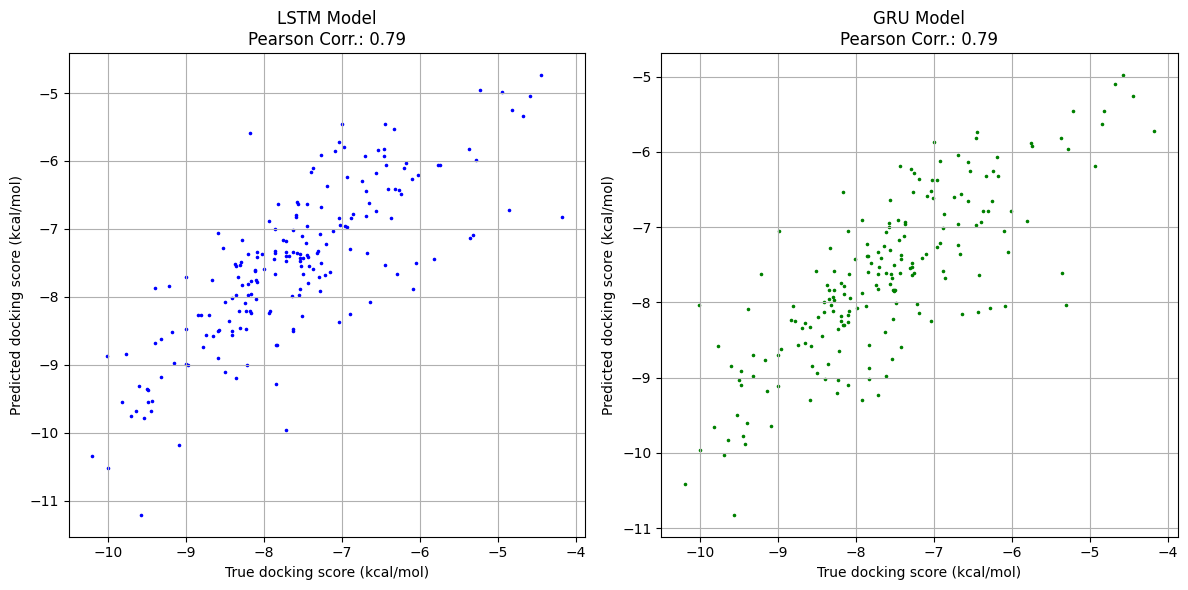

In [ ]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(lstm_truth, lstm_preds, s=10.0, marker='.', color='blue')
plt.title(f"LSTM Model\nPearson Corr.: {pearson_lstm:.2f}")
plt.xlabel("True docking score (kcal/mol)")
plt.ylabel("Predicted docking score (kcal/mol)")
plt.grid()


plt.subplot(1, 2, 2)
plt.scatter(gru_truth, gru_preds, s=10.0, marker='.', color='green')
plt.title(f"GRU Model\nPearson Corr.: {pearson_gru:.2f}")
plt.xlabel("True docking score (kcal/mol)")
plt.ylabel("Predicted docking score (kcal/mol)")
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
gru_pred_results = []
for input, smi in zip(X_test, zinc_list):
    inp = torch.tensor(input, dtype=torch.float).unsqueeze(0).to(device)
    output = gru_model(inp)
    gru_pred_results.append((smi, output.item()))
gru_pred_results.sort(key=lambda x: x[1])


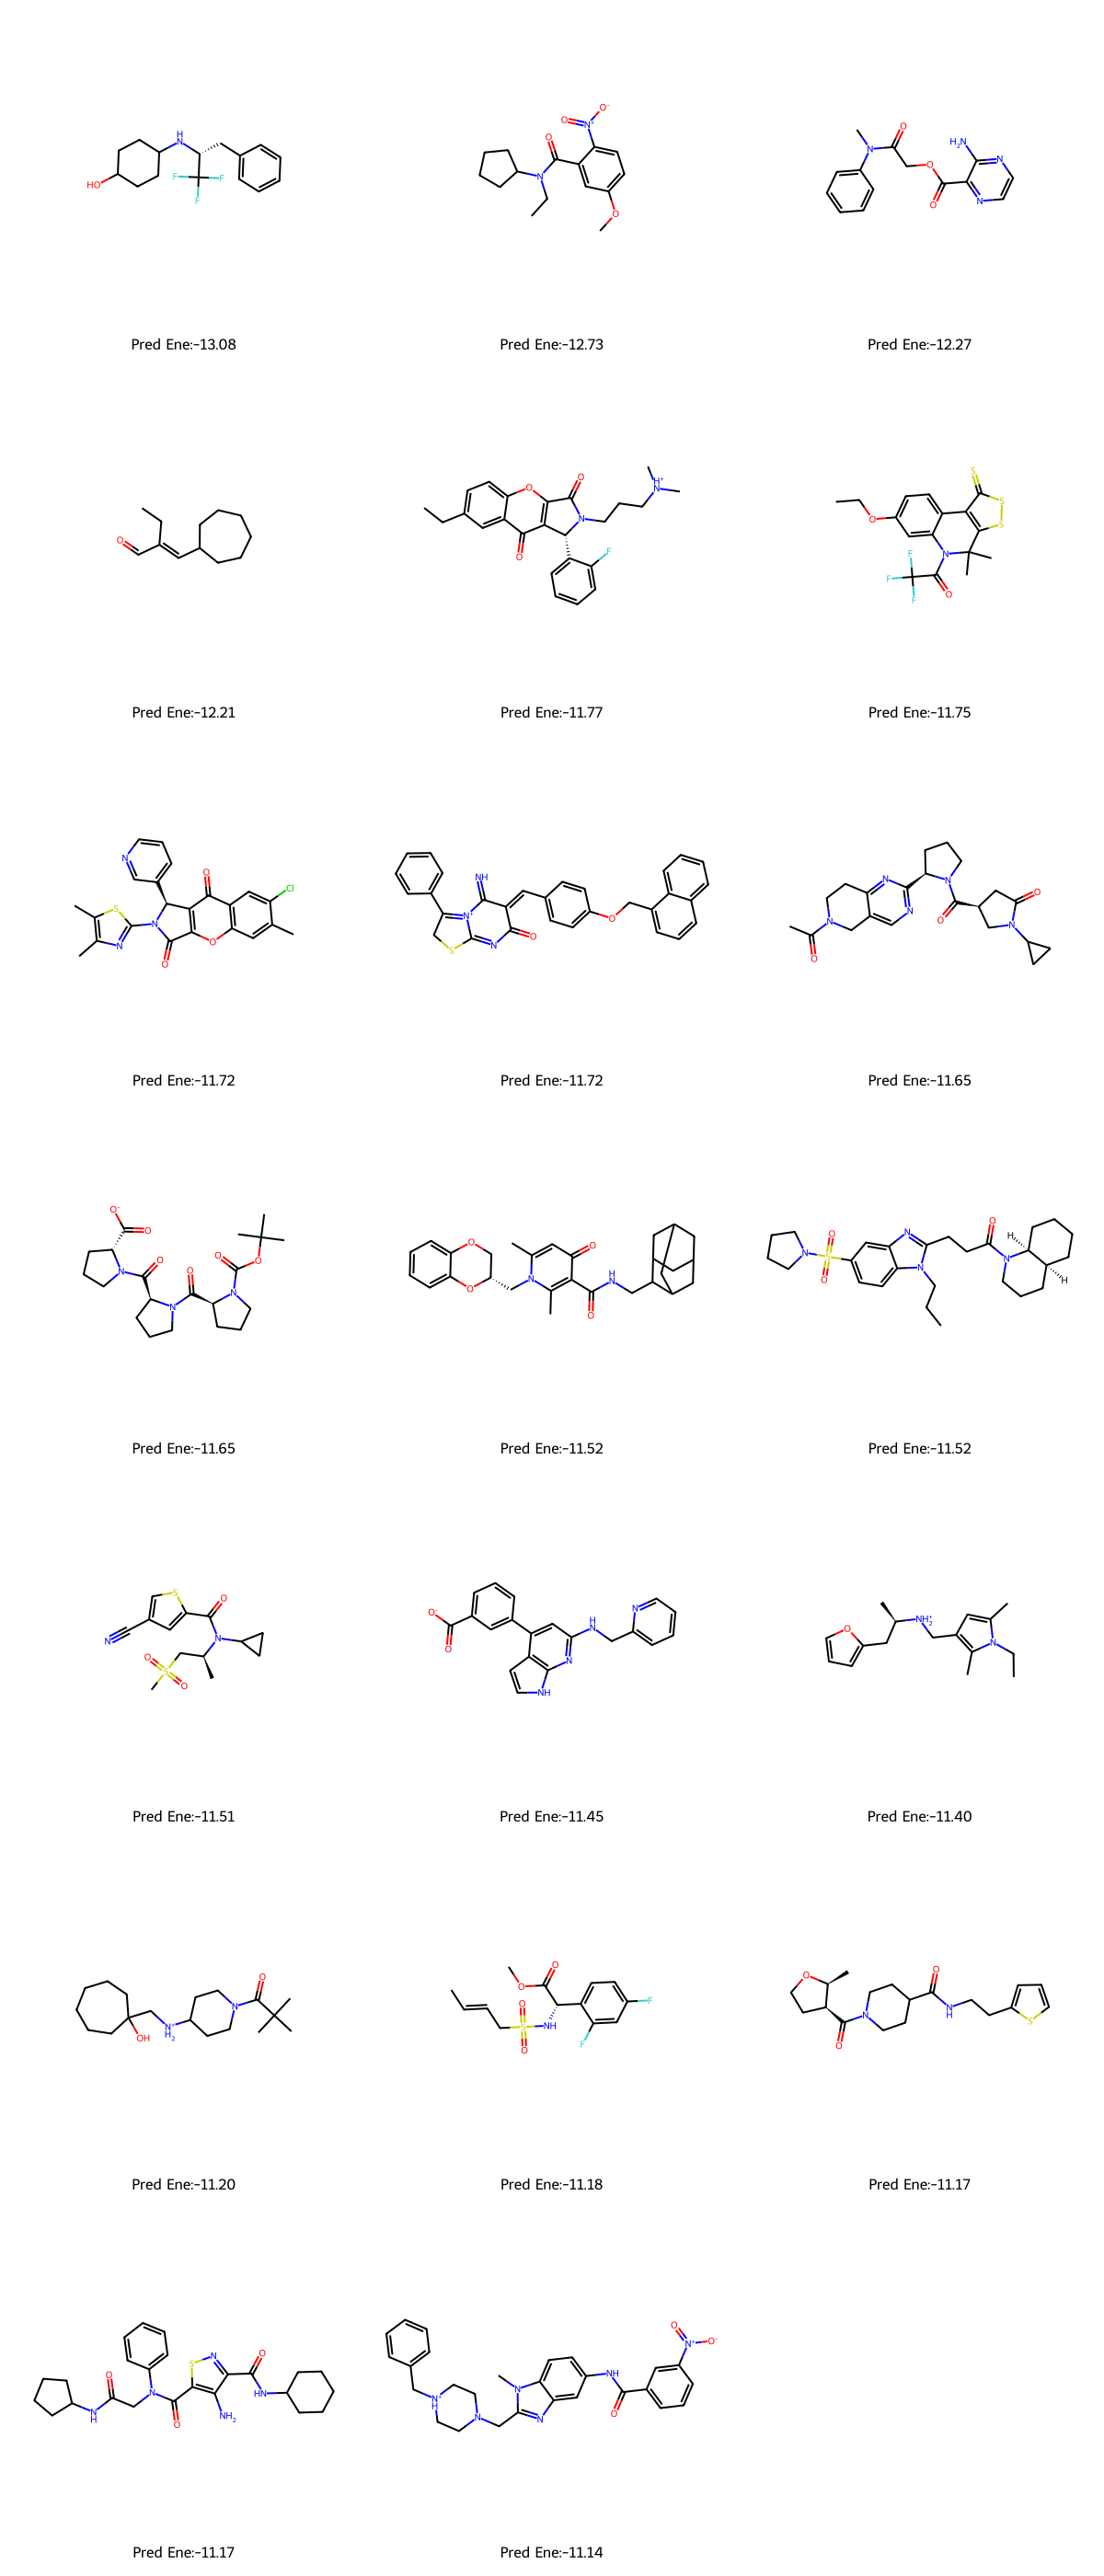

In [ ]:
top_gru_candidates = []
n_top = 20
for smi, score in gru_pred_results[:n_top]:
    top_gru_candidates.append(
        {
            "smiles": smi,
            "rdkit_molecule": Chem.MolFromSmiles(smi),
            "score": f"Pred Ene:{score:.2f}",
        }
    )
top_gru_mols = pd.DataFrame(top_gru_candidates)
Chem.Draw.MolsToGridImage(
    list(top_gru_mols.head(n_top).rdkit_molecule),
    legends=list(top_gru_mols.head(n_top)["score"]),
    subImgSize=(400,400),
)


In [ ]:

gru_matches = []
gru_clean = []
for smi, score in gru_pred_results:
    molecule = Chem.MolFromSmiles(smi)
    entry = catalog.GetFirstMatch(molecule)
    if entry is not None:
        gru_matches.append(
            {
                "smiles": smi,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        gru_clean.append((smi, score))


gru_matches = pd.DataFrame(gru_matches)

print(gru_matches)

                                                smiles  \
0    N=C1/C(=C/c2ccc(OCc3cccc4ccccc34)cc2)C(=O)N=C2...   
1         CCc1ccc(N2CC[NH+](CCn3cnc4ccccc4c3=O)CC2)cc1   
2    CCOc1cccc(-c2nn(-c3ccccc3)cc2/C=C2\SC(N3C[C@@H...   
3                    CCN(Cc1ccc(N)cc1)c1ccc(C(N)=O)nn1   
4       O=C(CCN1c2ccccc2Sc2ccccc21)N[C@H]1CCCc2ccccc21   
..                                                 ...   
336       C[C@@H](Nc1ccc2c(c1)OCCCO2)c1nc(C(C)(C)C)no1   
337       Cc1[nH]c2[nH]n(-c3ccc(F)cc3)c(=O)c2c(=O)c1Cl   
338  Cc1[nH]c2ccc(CNS(=O)(=O)N3C[C@H](C)O[C@H](C)C3...   
339  CCCC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1ccc(Cl)cc1   
340        Cc1[nH]c2ccccc2c1C1CC[NH+](CC(=O)NC2CC2)CC1   

                                       rdkit_molecule                 pains  
0    <rdkit.Chem.rdchem.Mol object at 0x7825bcdb7920>    Ene_six_het_a(483)  
1    <rdkit.Chem.rdchem.Mol object at 0x7825bcdb77d0>    Anil_di_alk_e(186)  
2    <rdkit.Chem.rdchem.Mol object at 0x78272b94fed0>    Ene_five_het

- Both GRU and LSTM models show molecular structures with predicted docking scores in a similar range.
- Predicted scores for GRU candidates range from -11.5 to -12.8 kcal/mol.
- Predicted scores for LSTM candidates have a similar range, suggesting comparable performance.
- Some molecules appear in both lists, but there are unique selections in each model.
This suggests that GRU and LSTM may have slight differences in the molecular features they prioritize.

# Homework #2: 10만개 또는 25만개의 ZINC 분자를 이용해서 screening하고 결과 분석을 해보라.
1. ZINC 100k: https://www.dropbox.com/s/etcxhvoozoujhgs/zinc100k.smi?dl=1
2. ZINC 250k: https://www.dropbox.com/s/hs3hnxngkhq0y0p/zinc250k.smi?dl=1
3. If you are interested in screening more.. please check this out:
http://cache.docking.org/

In [ ]:
!wget -O zinc100k.smi https://www.dropbox.com/s/etcxhvoozoujhgs/zinc100k.smi?dl=1
!wget -O zinc250k.smi https://www.dropbox.com/s/hs3hnxngkhq0y0p/zinc250k.smi?dl=1


--2024-11-21 10:39:44--  https://www.dropbox.com/s/etcxhvoozoujhgs/zinc100k.smi?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/bm2e4utgg3bdkiaa24pmt/zinc100k.smi?rlkey=s8e59xcuth918zfa54dtpjtvk&dl=1 [following]
--2024-11-21 10:39:44--  https://www.dropbox.com/scl/fi/bm2e4utgg3bdkiaa24pmt/zinc100k.smi?rlkey=s8e59xcuth918zfa54dtpjtvk&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4eddf0c4f5915dc2cd1809ad25.dl.dropboxusercontent.com/cd/0/inline/Cez5X8vjZQgMMfEASS6KkLKWfCkiyskL6hUyW0CMrdHmxLVAfmISgKLDzO-5lEAiUAjr2DKfSTF6AfAbPCUBtny0eqdtuXNdsKuhdJJaZ6j_MOCZsSXUscDAESpm1yUMuZ1Q-tweis2ckRCliSAumwQb/file?dl=1# [following]
--2024-11-21 10:39:45--  https://uc4eddf0c4f5915dc2cd1809ad25.dl.dropboxuserco

In [ ]:
zinc_list = []
with open("zinc100k.smi") as fp:
  for l in fp:
    zinc_list.append(l.strip())

padded_zinc_list = []
for smi in zinc_list:
  if len(smi) > max_len: continue
  padded_smi = add_padding(smi)
  padded_zinc_list.append(padded_smi)
print(len(padded_zinc_list))


X_test, X_test_int = vectorize(padded_zinc_list)



99939


In [ ]:

%%time
pred_results=[]
for input, smi in zip(X_test, zinc_list):
  inp = torch.tensor(input, dtype=torch.float).to(device)
  #print(inp)
  output = lstm_model(inp)
  #print(f"{smi}, {output.item():.3f}")
  pred_results.append((smi, output.item()))
pred_results.sort(key=lambda x:x[1])



CPU times: user 49.9 s, sys: 30.9 ms, total: 49.9 s
Wall time: 49.8 s


Number of unwanted substructures in collection: 481


  0%|          | 0/1000 [00:00<?, ?it/s]

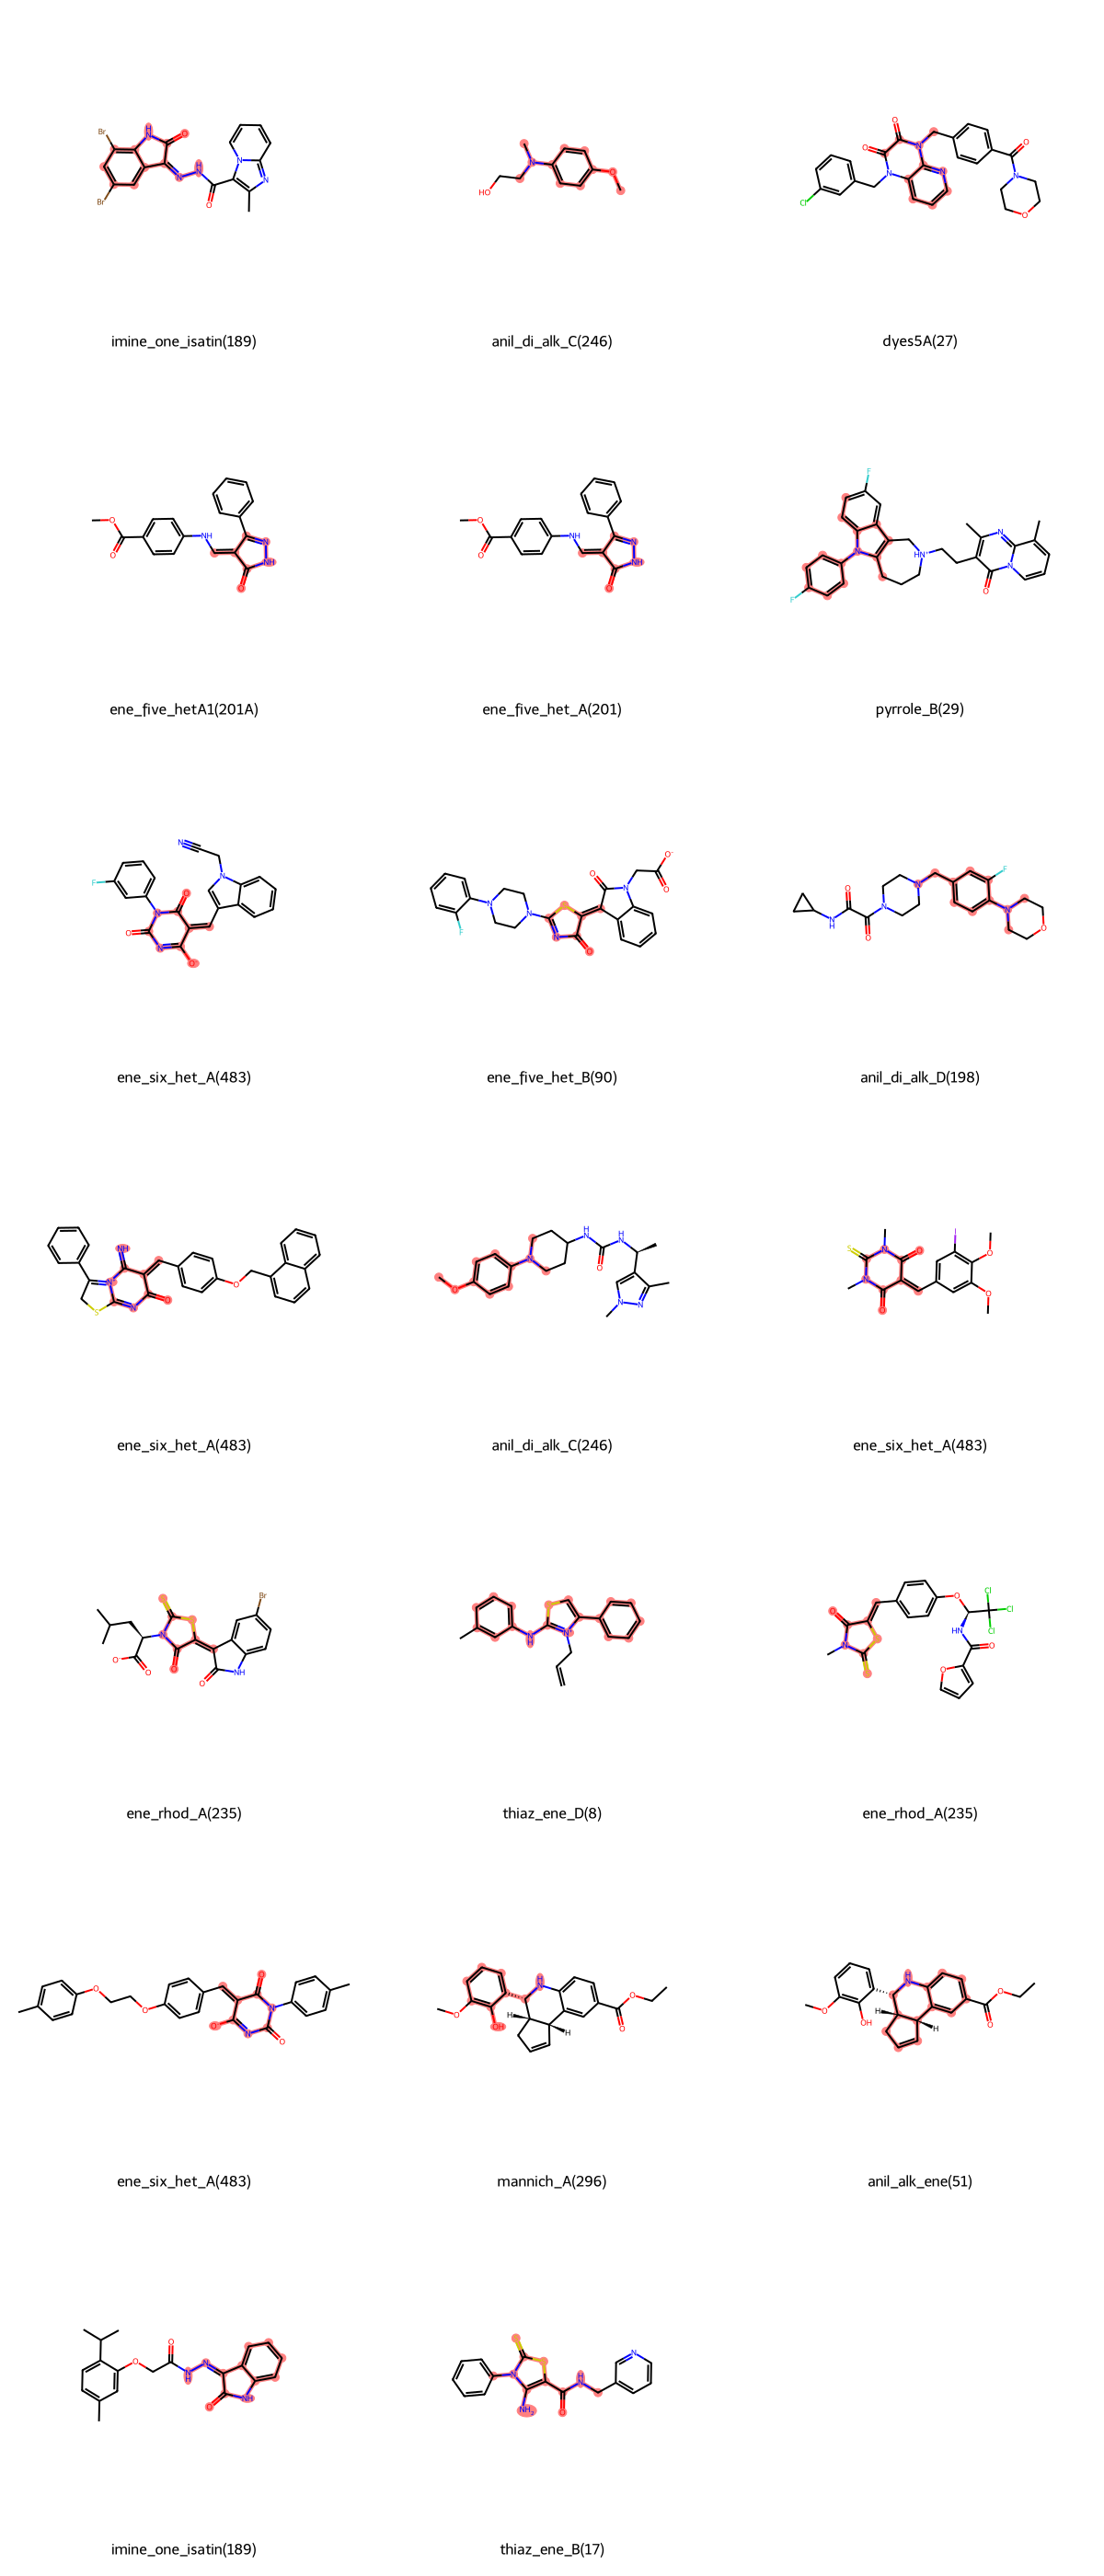

In [ ]:

mol = Chem.MolFromSmiles(pred_results[0][0])
pred_results[0][0]

top_candidates = []
n_top = 20
for smi, score in pred_results[:n_top]:
  top_candidates.append(
    {
      "smiles": smi,
      "rdkit_molecule": Chem.MolFromSmiles(smi),
      "score": f"Pred Ene:{score:.2f}",
    }
  )
top_mols = pd.DataFrame(top_candidates)
Chem.Draw.MolsToGridImage(
    list(top_mols.head(n_top).rdkit_molecule),
    legends=list(top_mols.head(n_top)["score"]),
    subImgSize=(400,400),
)
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for PAINS
matches = []
clean = []
for smi, score in pred_results:
    molecule = Chem.MolFromSmiles(smi)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "smiles": smi,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append((smi, score))

matches = pd.DataFrame(matches)

Chem.Draw.MolsToGridImage(
    list(matches.head(10).rdkit_molecule),
    legends=list(matches.head(10)["pains"]),
    subImgSize=(400,400),
)

substructures = pd.read_csv("https://raw.githubusercontent.com/iwatobipen/rdkit_pains/master/pains.txt", sep=' ', header=None)

substructures["rdkit_molecule"] = substructures[0].apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))


# search for unwanted substructure
matches = []
clean = []
for smi, score in tqdm(pred_results[:1000]):
  molecule = Chem.MolFromSmiles(smi)
  match = False
  for _, substructure in substructures.iterrows():
    if molecule.HasSubstructMatch(substructure.rdkit_molecule):
        matches.append(
          {
              "smiles": smi,
              "rdkit_molecule": molecule,
              "substructure": substructure.rdkit_molecule,
              "substructure_name": substructure[1],
          }
        )
        match = True
  if not match:
    clean.append(smi)

matches = pd.DataFrame(matches)
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(n_top).iterrows()
]

Chem.Draw.MolsToGridImage(
    list(matches.head(n_top).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(n_top).substructure_name),
    subImgSize=(400,400),
)



250k version

In [ ]:
zinc_list = []
with open("zinc250k.smi") as fp:
  for l in fp:
    zinc_list.append(l.strip())

padded_zinc_list = []
for smi in zinc_list:
  if len(smi) > max_len: continue
  padded_smi = add_padding(smi)
  padded_zinc_list.append(padded_smi)
print(len(padded_zinc_list))


X_test, X_test_int = vectorize(padded_zinc_list)



249287


In [ ]:

%%time
pred_results=[]
for input, smi in zip(X_test, zinc_list):
  inp = torch.tensor(input, dtype=torch.float).to(device)
  #print(inp)
  output = lstm_model(inp)
  #print(f"{smi}, {output.item():.3f}")
  pred_results.append((smi, output.item()))
pred_results.sort(key=lambda x:x[1])



CPU times: user 2min 3s, sys: 159 ms, total: 2min 3s
Wall time: 2min 3s


Number of unwanted substructures in collection: 481


  0%|          | 0/1000 [00:00<?, ?it/s]

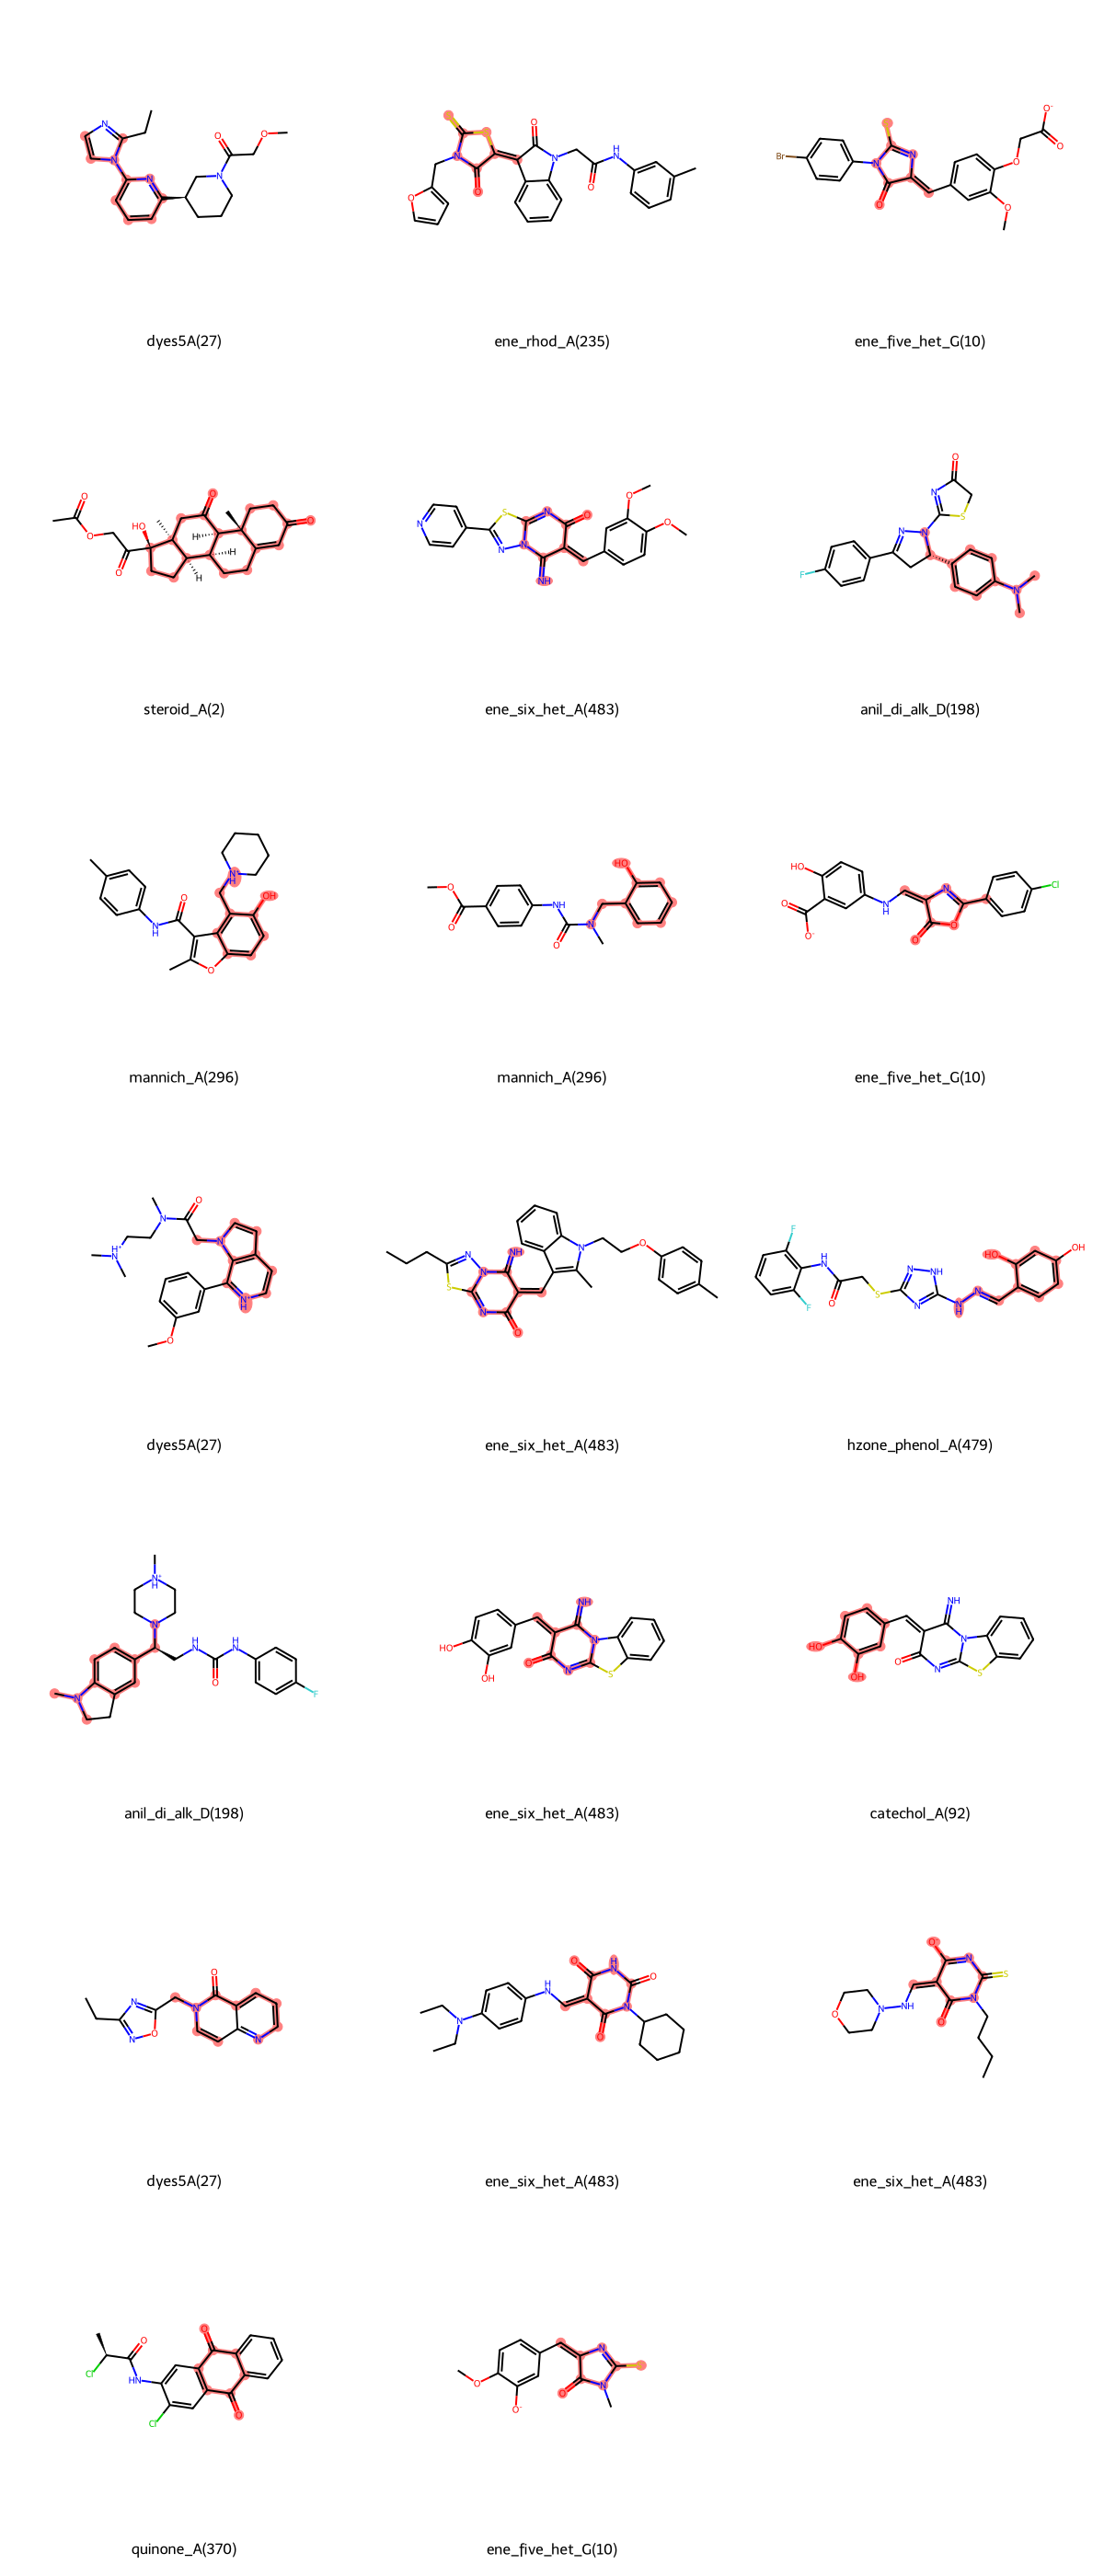

In [86]:

mol = Chem.MolFromSmiles(pred_results[0][0])
pred_results[0][0]

top_candidates = []
n_top = 20
for smi, score in pred_results[:n_top]:
  top_candidates.append(
    {
      "smiles": smi,
      "rdkit_molecule": Chem.MolFromSmiles(smi),
      "score": f"Pred Ene:{score:.2f}",
    }
  )
top_mols = pd.DataFrame(top_candidates)
Chem.Draw.MolsToGridImage(
    list(top_mols.head(n_top).rdkit_molecule),
    legends=list(top_mols.head(n_top)["score"]),
    subImgSize=(400,400),
)
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for PAINS
matches = []
clean = []
for smi, score in pred_results:
    molecule = Chem.MolFromSmiles(smi)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "smiles": smi,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append((smi, score))

matches = pd.DataFrame(matches)

Chem.Draw.MolsToGridImage(
    list(matches.head(10).rdkit_molecule),
    legends=list(matches.head(10)["pains"]),
    subImgSize=(400,400),
)

substructures = pd.read_csv("https://raw.githubusercontent.com/iwatobipen/rdkit_pains/master/pains.txt", sep=' ', header=None)

substructures["rdkit_molecule"] = substructures[0].apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))


# search for unwanted substructure
matches = []
clean = []
for smi, score in tqdm(pred_results[:1000]):
  molecule = Chem.MolFromSmiles(smi)
  match = False
  for _, substructure in substructures.iterrows():
    if molecule.HasSubstructMatch(substructure.rdkit_molecule):
        matches.append(
          {
              "smiles": smi,
              "rdkit_molecule": molecule,
              "substructure": substructure.rdkit_molecule,
              "substructure_name": substructure[1],
          }
        )
        match = True
  if not match:
    clean.append(smi)

matches = pd.DataFrame(matches)
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(n_top).iterrows()
]

Chem.Draw.MolsToGridImage(
    list(matches.head(n_top).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(n_top).substructure_name),
    subImgSize=(400,400),
)



**Computational Times**

Observation: The computational time increases proportionally with the dataset size.

10k to 100k Dataset: ~10x increase in both dataset size and computational time.
100k to 250k Dataset: ~2.5x increase in dataset size and computational time.
Per Molecule Processing Time:

10k Dataset: ~0.00049 seconds per molecule
100k Dataset: ~0.0005 seconds per molecule
250k Dataset: ~0.0005 seconds per molecule
Explanation: The per-molecule processing time remains consistent across datasets, indicating that the computational efficiency of your code is maintained as the dataset size increases.

**10k dataset**

The predicted docking scores (ranging around ~11.5 to ~12.5) indicate relatively strong binding affinities.
No highlighted regions for unwanted substructures (e.g., PAINS) suggest that these molecules passed the filtering step.

=> Given the smaller dataset, the pool of candidates might not fully represent the chemical space. However, it offers a faster computational pipeline to test the model's efficiency and relevance.
Fewer top candidates might limit the diversity of structural scaffolds for further exploration.

**100k dataset**

Highlighted regions in molecules (e.g., marked in red) indicate the presence of potential unwanted substructures identified by filtering algorithms (PAINS or custom substructure filters).
Predicted docking scores remain consistent with the range observed in the 10k dataset, demonstrating that the larger dataset did not drastically alter the distribution of top-ranked candidates.

=> Larger dataset size allows for a broader exploration of chemical space, resulting in more unique candidates.
Despite increased diversity, some unwanted substructures are identified, which might require careful consideration in downstream analysis (e.g., synthesis feasibility or toxicity risks).
The presence of more candidates allows for better prioritization based on a combination of docking scores and chemical features.

**250k dataset**

Several molecules still contain highlighted regions corresponding to unwanted substructures, but these are scattered across a broader set of scaffolds.
Predicted docking scores are consistent with the trends observed in the 10k and 100k datasets.

=> The large dataset offers the best opportunity to identify novel scaffolds and prioritize candidates with both high docking scores and desirable chemical properties.
More top-ranked molecules may fall into challenging categories (e.g., synthesis complexity, PAINS), which would require additional computational or manual filtering steps.
Despite the increased dataset size, it is crucial to evaluate whether the additional diversity justifies the longer computation and analysis time, especially if the top candidates are chemically similar to those identified in smaller datasets.

**Docking Scores:**

The top candidates across all datasets show similar docking scores, suggesting that the model consistently identifies strong binders regardless of dataset size.

**Structural Diversity:**

Diversity increases with dataset size, offering more opportunities to explore novel scaffolds in larger datasets.

**Unwanted Substructures:**

Some molecules in the 100k and 250k datasets contain undesirable substructures, highlighting the importance of efficient filtering mechanisms.

**Computational Trade-offs:**

Larger datasets provide more comprehensive exploration but require significantly more computational resources and time.
The marginal gain in novel candidates might diminish beyond a certain dataset size.